In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import math
from scipy import stats
from scipy import optimize as opt
import torch
import glob
import os
import warnings
import itertools
import hessian
from torch.utils import data as torchdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"

Failed to import duecredit due to No module named 'duecredit'


# Model motivation

To explain the motivation behind this model, let's step through some reasoning.

In [2]:
# Load in data
df = pd.read_csv(df_path)

Let's look at some voxels that have good GLM $R^2$ values and pick one

In [12]:
df[(df.varea==1)&(df.R2>40)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(20)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision']]

voxel         R2  varea hemi     angle     eccen  precision
2811   2811  46.440060      1   rh  1.570793  2.088507   5.460466
2812   2812  44.630062      1   rh  1.574770  2.106033   4.484139
2805   2805  44.474243      1   rh  1.602626  2.028465   4.590699
2818   2818  44.376331      1   rh  1.571172  2.071329   5.733254
2817   2817  43.290607      1   rh  1.578023  1.975799   7.439803
2804   2804  43.142612      1   rh  1.591477  1.997247   5.161090
2819   2819  41.135906      1   rh  1.632733  2.116547   6.454978
1961   1961  40.302860      1   lh  4.735274  2.738998   2.115435

In [13]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([2811]))]#, 1421]))]
voxel_df.head()

varea  voxel stimulus_superclass  w_r   w_a     eccen     angle  \
2811       1   2811             angular  0.0   6.0  2.088507  1.570793   
8489       1   2811             angular  0.0   8.0  2.088507  1.570793   
14167      1   2811             angular  0.0  11.0  2.088507  1.570793   
19845      1   2811             angular  0.0  16.0  2.088507  1.570793   
25523      1   2811             angular  0.0  23.0  2.088507  1.570793   

       stimulus_class  amplitude_estimate_std_error hemi  \
2811                0                      0.398486   rh   
8489                1                      0.374436   rh   
14167               2                      0.472738   rh   
19845               3                      0.447664   rh   
25523               4                      0.474922   rh   

                      ...                      local_w_r  local_w_a  \
2811                  ...                   2.799731e-17   0.457231   
8489                  ...                   3.732974e-17   0.609641   
14167                 ...                   5.132840e-17   0.838256   
19845                 ...                   7.465949e-17   1.219282   
25523                 ...                   1.073230e-16   1.752718   

       local_sf_magnitude  local_sf_xy_direction  local_sf_ra_direction  \
2811             0.457231               3.141589               1.570796   
8489             0.609641               3.141589               1.570796   
14167            0.838256               3.141589               1.570796   
19845            1.219282               3.141589               1.570796   
25523            1.752718               3.141589               1.570796   

       baseline  precision  amplitude_estimate_norm  \
2811          0   5.460466                28.254143   
8489          0   5.460466                28.254143   
14167         0   5.460466                28.254143   
19845         0   5.460466                28.254143   
25523         0   5.460466                28.254143   

       amplitude_estimate_median_normed  amplitude_estimate_std_error_normed  
2811                           0.105021                             0.014104  
8489                           0.124197                             0.013252  
14167                          0.159354                             0.016732  
19845                          0.176313                             0.015844  
25523                          0.214248                             0.016809  

[5 rows x 31 columns]

In [14]:
sns.set_context('notebook')
sns.set_style('white')

In [15]:
pal = sns.palettes.color_palette('deep', 5)
pal = {'radial': pal[0], 'reverse spiral': pal[4], 'forward spiral': pal[2], 'angular': pal[3], 'mixtures': pal[1]}
hue_order = ['radial', 'reverse spiral', 'forward spiral', 'angular', 'mixtures']

Let's examine the response of this voxel as a function of spatial frequency. In the plot below, we plot the normed amplitude estimate as a function of the local spatial frequency. We see that the response looks roughly log-Normal, but there appears to be some difference between the different stimulus classes.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


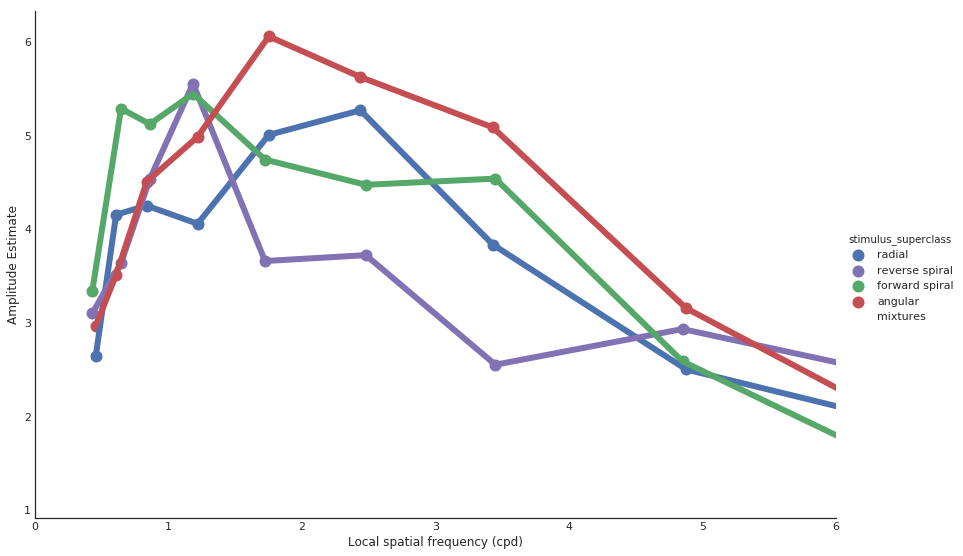

In [16]:
g = sns.FacetGrid(voxel_df[~voxel_df.stimulus_superclass.isin(['mixtures'])], hue='stimulus_superclass',palette=pal, size=8, aspect=1.5, hue_order=hue_order)
g.map(plt.scatter, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
g.map(plt.plot, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
# g.ax.set_xscale('log', basex=2)
g.add_legend()
g.ax.tick_params(size=0)
g.ax.set_xlim((0, 6))
g.set_xlabels('Local spatial frequency (cpd)')
g.set_ylabels('Amplitude Estimate')

These classes differ in their local orientation, so we can look at a plot of the response as a function of the local spatial frequency with respect to x and y (size represents the response). This plot is difficult to parse, but the main point is that these different stimulus classes are not arbitrary and discrete: they lie on a continuum, related by the stimulus orientation, and so we can fit the response of the voxel as a 2d tuning curve.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, U

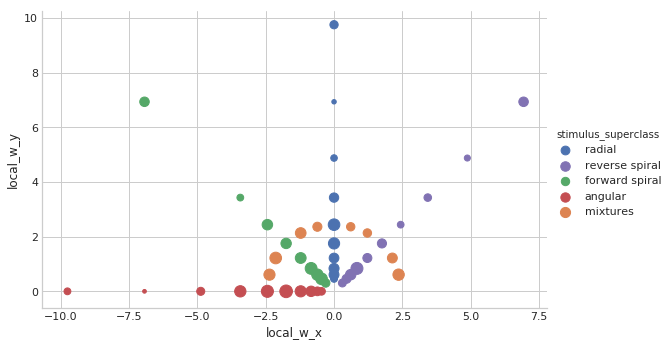

In [17]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, size_scale=1, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80*size_scale, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80*size_scale, **kwargs)

with sns.axes_style('whitegrid'):
    voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
    voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
    g=sns.FacetGrid(voxel_df, size=8, aspect=1, hue='stimulus_superclass', palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False, size_scale=2)
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_aspect('equal')
    g.ax.tick_params(size=0)

This is just that same data, but rotated and plotted on a semi-log plots.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


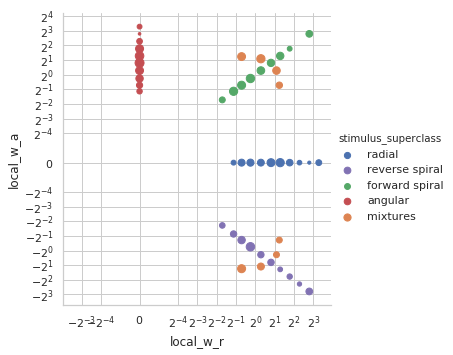

In [18]:
with sns.axes_style('whitegrid'), sns.plotting_context('notebook'):
    g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1, palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-4))
    scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-4))

But then the question is: how does the tuning change with orientation? Two possibilities are:

1. The preferred frequency of the tuning curve / mode of the log-Gaussian distribution changes with orientation.
2. The amplitude of the tuning curve changes with orientation.

Then there's the question of how either the mode or the amplitude changes with orientation. Let's assume it changes smoothly and periodically, symmetrically about 180 degrees (because 2d orientation is runs from 0 to 180 degrees). We'll examine three possibilities in the plots below, from left to right:

1. all orientation are equally important (mode/amplitude does not depend on orientation; constant)
2. horizontal or vertical is preferred, but the other is anti-preferred (sinusoid with frequency $2\theta$)
3. the cardinals are preferred, the obliques are anti-preferred (sinusoid with frequency $4\theta$)

The following plots show these three possibilities, with the top showing a plot of orientation vs mode/response, while the bottom shows this on an x/y plot: the line represents either the mode or the level set of the max amplitude.

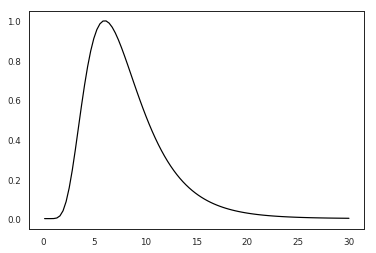

In [19]:
with sns.plotting_context('paper'), sns.axes_style('white'):
    x = np.linspace(.1, 30, 100)
    y = sfp.tuning_curves.log_norm_pdf(x,1, 6, .45)
    plt.plot(x, y, 'k')

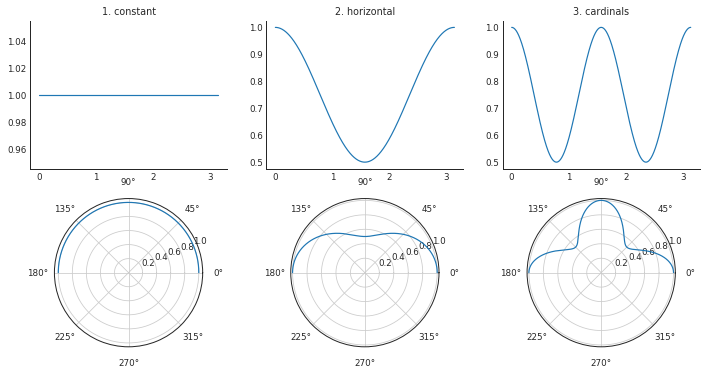

In [20]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(12,6))
    theta = np.linspace(0, np.pi, 1000)
    for i, f, title in zip(range(3), [0, 2, 4], ['1. constant', '2. horizontal', '3. cardinals']):
        r = (np.cos(f*theta) + 3) / 4
        ax = plt.subplot(2,3,i+1)
        ax.plot(theta, r)
        ax.tick_params(size=0)
        sns.despine(ax=ax)
        ax.set_title(title)
        ax = plt.subplot(2,3,4+i, projection='polar')
        ax.plot(theta, r)

Okay so then how do we set up the function that we're going to fit? First, let's look at the 1d log-Normal distribution we used before. Normally, this distribution is parameterized by $\mu$ and $\sigma^2$. These are *not* the mean and variance, the way they are for the regular Normal distribution. We'll keep using $\sigma^2$ but we'll use the mode, $M$ instead of $\mu$: $M = \exp(\mu - \sigma^2) \Rightarrow \mu = \ln(M) + \sigma^2$.

Thus, when we're modeling the response, $R$ as a 1d log-Normal tuning curve with respect to the spatial frequency $\omega$, it's: $R=A * \exp(-\frac{(\ln(\omega)-\ln(M)-\sigma^2)^2}{2\sigma^2})$.

Now we're extending this to make it 2d, as a funtion of spatial frequency $\omega$ and orientation $\theta$. To allow for the amplitude varying with orientation, we expand upon $A$ and make it orientation-dependent: $A_0 + A_1\cos2\theta + A_2\cos4\theta$. To allow the mode to vary, we make similarly make $M$ orientation-dependent: $M_0 + M_1\cos2\theta + M_2\cos4\theta$.

Putting it altogether we get:

$(A_0 + A_1\cos2\theta + A_2\cos4\theta)\exp(-\frac{(\ln(\omega)-\ln(M_0 + M_1\cos2\theta + M_2\cos4\theta)-\sigma^2)^2}{2\sigma^2})$

which gives us 7 parameters to fit: $A_0, A_1, A_2, M_0, M_1, M_2, \sigma$

Let's look at some examples of this function, to get a sense of its expressive power.

In [21]:
omega = np.logspace(-3, 3, 100, base=2)
theta = np.linspace(0, 2*np.pi, 100)

def log_norm_2d(omega, theta, A0=1, A1=0, A2=0, M0=1, M1=0, M2=0, sigma=1):
    omega = np.array(omega)
    theta = np.array(theta)
    amp = A0 + A1*np.cos(2*theta) + A2*np.cos(4*theta)
    mode = M0 + M1*np.cos(2*theta) + M2*np.cos(4*theta)
    #pdf = (1/(omega*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(omega)-mu)**2/(2*sigma**2))
    #pdf /= pdf.max()
    pdf = sfp.tuning_curves.log_norm_pdf(omega, amp, mode, sigma)
    return pdf

omega, theta = np.meshgrid(omega, theta)

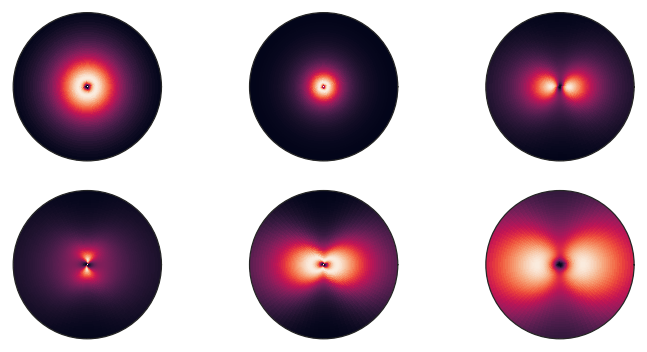

In [22]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

params = [{}, {'M0': .5}, {'A1': .5}, {'M1': .5}, {'A1': .5, 'M1': .5, 'M0': 1}, {'A1': .5, 'M1': .5, 'M0':2}]

with sns.plotting_context('notebook'):
    for i, ax in enumerate(axes.flatten()):
        R = log_norm_2d(omega, theta, **params[i])
        ax.pcolormesh(theta, omega, R)
        ax.set_xticks([])
        ax.set_rticks([])

This is on a voxel-by-voxel basis, but what about across the whole area? To extend it to all of V1, let's consider two frames of reference: fixed and relative.

In the fixed frame, all voxels have the same tuning. Orientation, $\theta_f$, above refers to Cartesian, world-relate orientation so that $\theta_f=0$ corresponds to "to the right". Spatial frequency, $\omega_f$, means the local spatial frequency in the image. This encodes our "constant" extreme possibility from earlier.

In the relative frame, voxel tuning depends on its location in the retinotopic map. We remap orientation and spatial frequency so that $\theta_r=0$ corresponds to "away from the fovea" and spatial frequency is scaled by eccentricity: $\omega_r=\omega_f(e+b)$, where $e$ is the eccentricity of the voxel's pRF and $b$ is some constant.

We then sum these two versions of the model so that we have a 15-parameter model (two versions of the 7 parameters above, plus $b$) that we fit simultaneously to all of V1.

# Voxel precision

One of the things we care about is the noisiness of our voxels. We'll use this in our loss function, so we want to know whether we can calculate the noise on a voxel-by-voxel basis or whether we have to worry about differing levels of noise for different stimulus classes.

In [63]:
df = pd.read_csv(df_path)

What's unclear from the following plot is whether the apparent relationship between the median amplitude estimate and the error is because of differences *between* voxels or *within* them. If it's between voxels, we're fine, but it's bad if it's within them (this would be like for a Poisson-process neuron, whose variance increases with the mean firing rate)

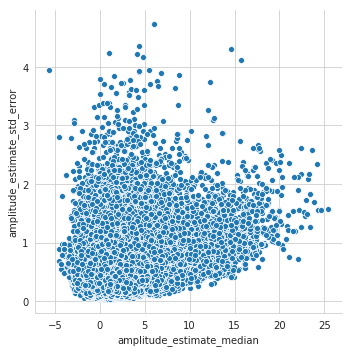

In [5]:
sns.relplot(x='amplitude_estimate_median', y='amplitude_estimate_std_error', data=df)

So to answer this question, we do a simple linear regression between the median amplitude estimate and the standard error.

In [30]:
def linear_regression(data, x='amplitude_estimate_median', y='amplitude_estimate_std_error'):
    s,i,r,p,e = stats.linregress(data[x], data[y])
    return pd.Series({'slope': s, 'intercept': i, 'r_squared': r**2, 'p_value': p, 'stderr': e})

linregress = df.groupby('voxel').apply(linear_regression)

And what we see here is that there doesn't appear to be a consistent relationship between the median amplitude estimate and the error of those estimates: the slope looks like it's distributed around zero, as does the relationship between slope and intercept. This is good, so we can treat precision as a voxel-by-voxel number

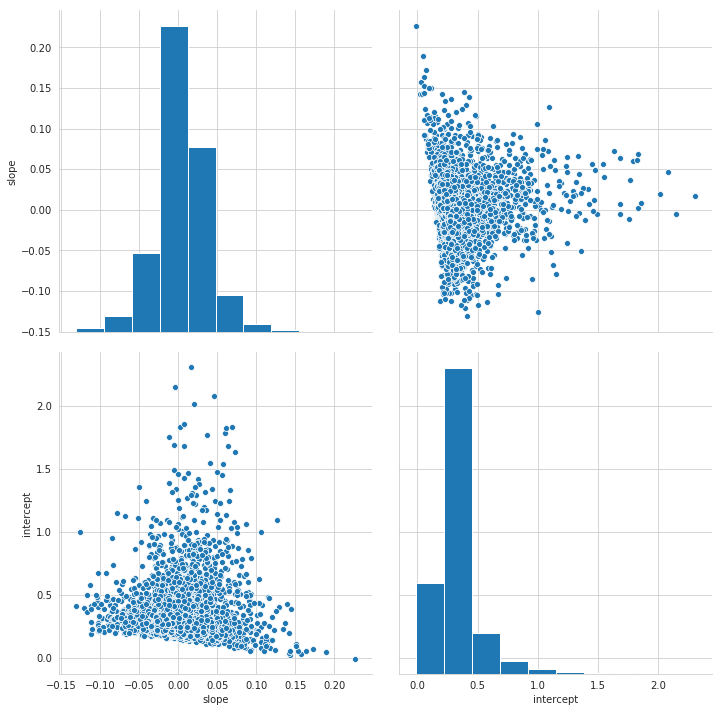

In [35]:
sns.pairplot(linregress, vars=['slope', 'intercept'], height=5)

# Torch

Model is:

$\exp{\frac{-(\log_2(\omega) + \log_2(ae+b))^2}{2 \sigma^2}}$

In [77]:
a = 1
b = 0
model = sfp.model.LogGaussianDonut(sf_ecc_slope=a, sf_ecc_intercept=b)
model.eval()

LogGaussianDonut(sigma: 0.400, sf_ecc_slope: 1.000, sf_ecc_intercept: 0.000, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)

When we build the model like this, we see it has a number of desirable features (note that for this version, there is no effect of orientation or retinal angle, so a single 1d tuning curve at each eccentricity completely characterizes the response of a voxel there). The following plots the responses on a log (left) and linear (right) x axis, for the perfectly scaling model at four different (log-spaced) eccentricities. We see that the tuning curve is log-normal, response peaks at 1, that the spatial frequency that drives the maximum response doubles as the eccentricity halves, and that the standard deviation is 1 octave (thus, the width of the tuning curve is constant in log space, but increases with the mode in linear space).

[(0, 10), Text(0.5,0,'spatial frequency (linear scale)')]

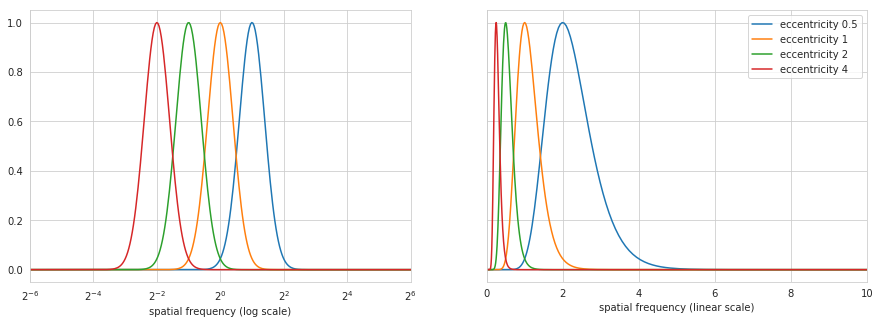

In [8]:
x = np.logspace(-6, 5, 1000)
es = [.5, 1, 2, 4]
fig, axes = plt.subplots(1,2, sharey='all', figsize=(15,5))
for e in es:
    # with this parameterization, orientation and retinal angle don't matter, so we just make them 0s
    r = model.forward(x, np.zeros_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes[0].semilogx(x, r, label='eccentricity %s'%e, basex=2)
    axes[1].plot(x, r, label='eccentricity %s'%e)
    plt.legend()
axes[0].set(xlim=(2**-6, 2**6), xlabel='spatial frequency (log scale)')
axes[1].set(xlim=(0, 10), xlabel='spatial frequency (linear scale)')

We can see what this looks like a little better by plotting the response as a heatmap, with eccentricity on the x-axis and period (the reciprocal of the spatial frequency) on the y-axis. (We plot against the period because then this will be linear, rather than hyperbolic.) The solid line here shows the (analytic) mode of the responses, while the dashed lines show one standard deviation above and below

In [10]:
eccen = np.linspace(0.01, 12, 120)
period = np.linspace(.01, eccen.max()*a+b, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = model.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

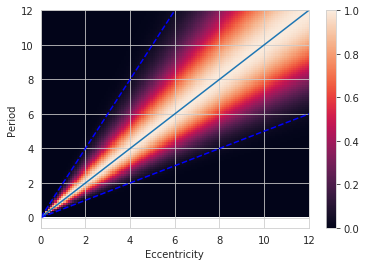

In [11]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
plt.plot(eccen,(a/2.*eccen+b), 'b--')
y = a*2*eccen+b
plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()

Clean this up and explain it

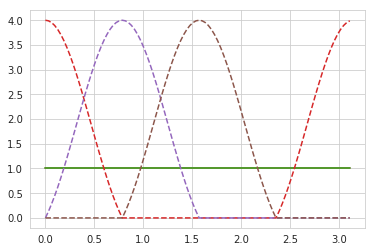

In [13]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = sfp.model.LogGaussianDonut('relative', sigma=1, sf_ecc_slope=1, rel_mode_cardinals=0, rel_amplitude_cardinals=2, rel_amplitude_obliques=1)
plt.plot(theta, model.preferred_period(theta, 1, [0, np.pi/4, np.pi/2]).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, [0, np.pi/4, np.pi/2]).detach().numpy().T, '--')
#model.preferred_period(theta, [1,2], 0)

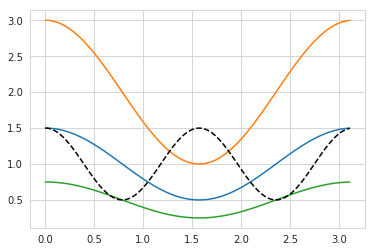

In [13]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = sfp.model.LogGaussianDonut('relative', sigma=1, sf_ecc_slope=1, rel_mode_cardinals=.5, rel_amplitude_obliques=.5)
plt.plot(theta, model.preferred_period(theta, [1,2, .5], 0).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, 0).detach().numpy(),'k--')
#model.preferred_period(theta, [1,2], 0)

[(0.015625, 32)]

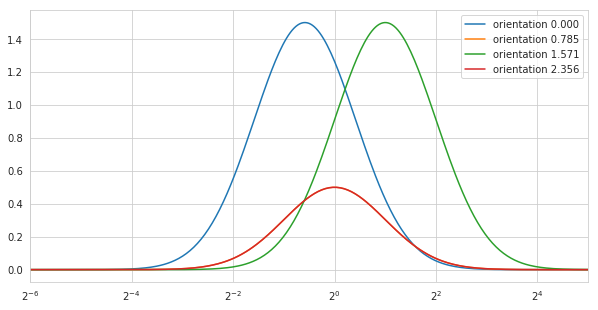

In [14]:
x = np.logspace(-6, 5, 1000)
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
for i, a in enumerate(theta):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r, basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

In [9]:
autoreload.reload(sfp.model)

<module 'sfp.model' from '../sfp/model.py'>

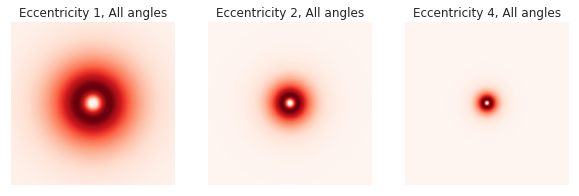

In [11]:
model = sfp.model.LogGaussianDonut(sigma=1)

eccens = [1,2,4]
angles = [0]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,3))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    sfp.model.show_image(model, e, a, show_colorbar=False, ax=ax)
    ax.set_title("Eccentricity %s, All angles" % (e))
# fig.savefig('iso.svg')

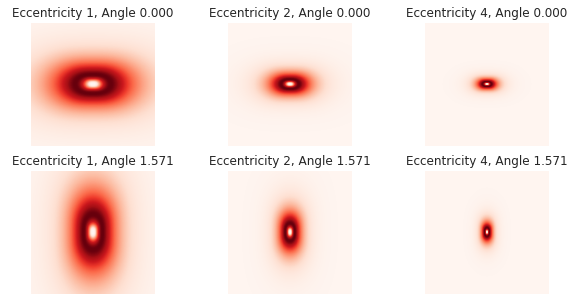

In [12]:
model = sfp.model.LogGaussianDonut('relative', sigma=1, rel_mode_cardinals=.3)

eccens = [1,2,4]
angles = [0, np.pi/2]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,5))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    sfp.model.show_image(model, e, a, show_colorbar=False, ax=ax)
    ax.set_title("Eccentricity %s, Angle %.03f" % (e,a))
# fig.savefig('rel.svg')

[(0.015625, 32)]

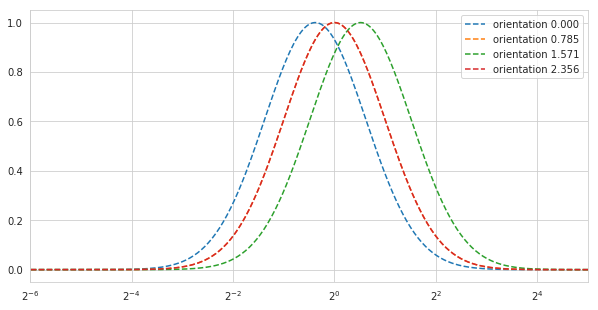

In [13]:
x = np.logspace(-6, 5, 1000)
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
for i, a in enumerate(angles):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r,'--', basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

Here's an example really complicated model. These parameter values are all very small, so I'm not sure they can be fit, but I'm checking here that we don't get weird things like preferred period or max amplitude hitting 0.

In [335]:
m = sfp.model.LogGaussianDonut('full', 'full', True, 1, .75, .25, .1, .05, .03, .1, .2, .05, .04, .3)

In [344]:
features = sfp.analyze_model.create_feature_df([m], orientation_n_steps=48, retinotopic_angle_n_steps=48)
example_oris = np.linspace(0, np.pi, num=4, endpoint=False)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


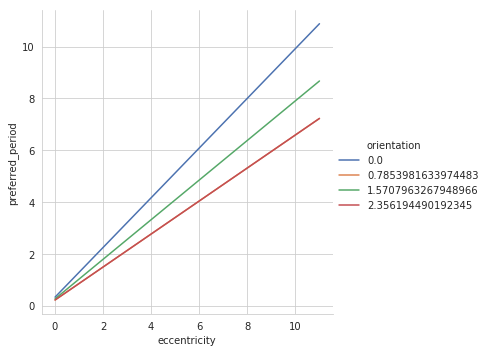

In [347]:
sns.relplot('eccentricity', 'preferred_period', 'orientation', data=features[(features.retinotopic_angle==0)&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


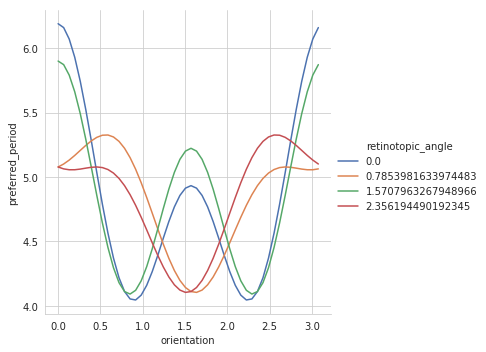

In [357]:
sns.relplot('orientation', 'preferred_period', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


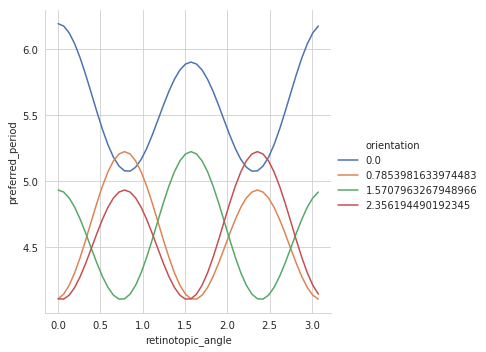

In [350]:
sns.relplot('retinotopic_angle', 'preferred_period', 'orientation', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


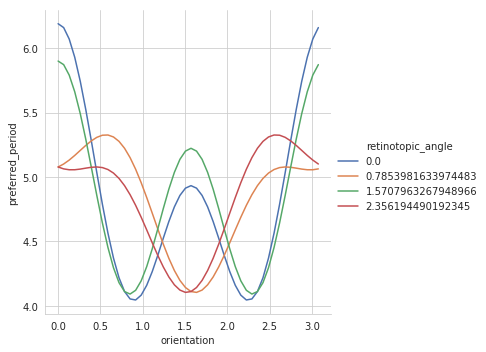

In [351]:
sns.relplot('orientation', 'preferred_period', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


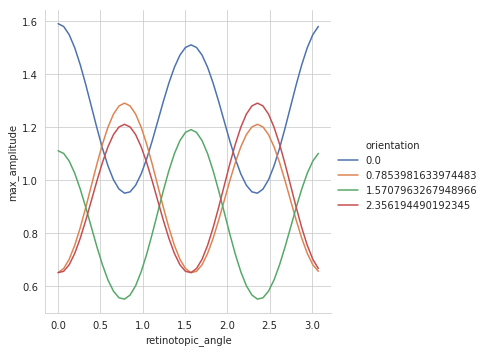

In [354]:
sns.relplot('retinotopic_angle', 'max_amplitude', 'orientation', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


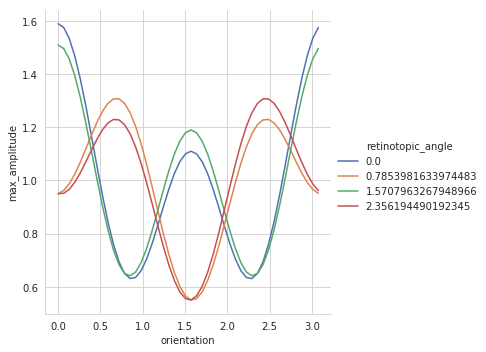

In [353]:
sns.relplot('orientation', 'max_amplitude', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

# Run some things 

In [237]:
df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"
s = sfp.simulate_data.main('iso', 'full', False, 1, .5, .5, save_path='tmp.csv', noise_source_path=df_path, noise_level=1)# abs_amplitude_cardinals=2, abs_amplitude_obliques=1, )
m,l,r,h = sfp.model.main('iso', 'full', False, 'tmp.csv',
                         batch_size=10, learning_rate=1e-3, max_epochs=100, test_set_stimulus_class=None)

../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:161: UserWarning: When orientation_type is iso, all relative variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:161: UserWarning: When orientation_type is iso, all relative variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type

Beginning training, treating stimulus classes [0, 1] as test set!
Average train loss on epoch 0: 1.9664292931556702
Average test loss on epoch 0: 6.610590982437134
LogGaussianDonut(sigma: 0.275, sf_ecc_slope: 0.440, sf_ecc_intercept: 0.044, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)
Average train loss on epoch 1: 1.7744083285331727
Average test loss on epoch 1: 6.404294538497925
LogGaussianDonut(sigma: 0.284, sf_ecc_slope: 0.449, sf_ecc_intercept: 0.052, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)
Average train loss on epoch 2: 1.6373260378837586
Average test loss on epoch 2: 6.144560933113098
LogGaussianDonut(sigma

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


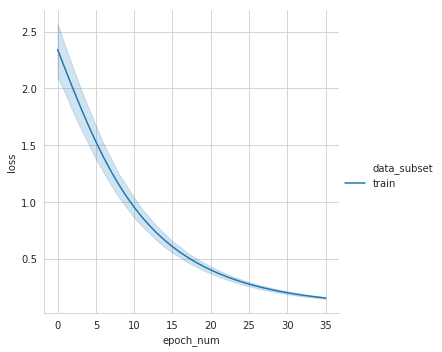

In [234]:
sns.relplot('epoch_num', 'loss', 'data_subset', data=l, kind='line')

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


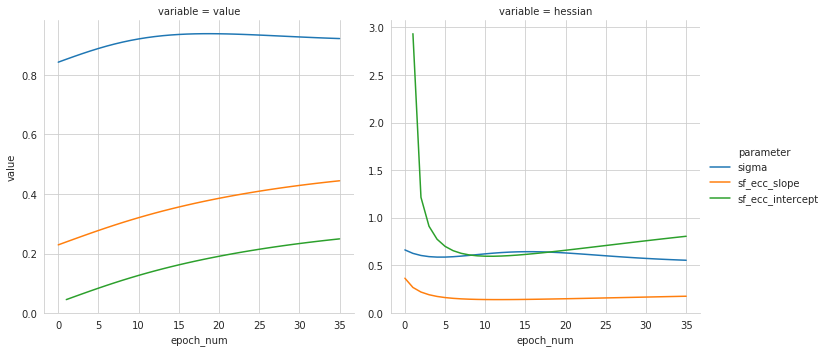

In [235]:
sns.relplot('epoch_num', 'value', 'parameter', col='variable', data=h.dropna().melt(['parameter', 'epoch_num'], ['value', 'hessian']), kind='line', facet_kws={'sharey': False})

In [331]:
dataset = sfp.model.FirstLevelDataset('tmp.csv', device)
dataloader = torchdata.DataLoader(dataset, len(dataset))

In [332]:
feat, target = next(iter(dataloader))
H = hessian.hessian(sfp.model.weighted_normed_loss(m(feat), target), [p for p in m.parameters() if p.requires_grad])

['sigma', 'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'abs_mode_cardinals', 'abs_mode_obliques', 'sf_ecc_slope', 'sf_ecc_intercept']


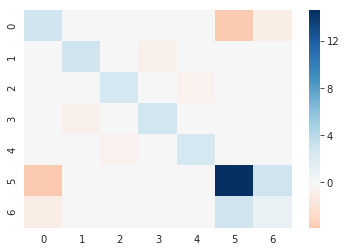

In [333]:
print([p[0] for p in m.named_parameters() if p[1].requires_grad])
sns.heatmap(H, cmap='RdBu', center=0)

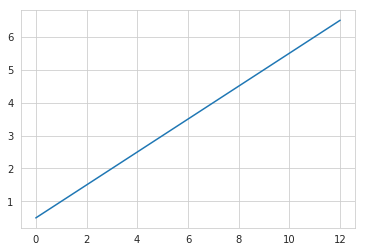

In [99]:
x = np.linspace(0, np.pi, 100)
e = np.linspace(0, 12, 100)
a = m.preferred_period(0, e, 0).detach().numpy()
plt.plot(e, a)

# Analyzing outputs

In [23]:
base_path = '/scratch/wfb229/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g1_all_'
base_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g0_all_'
models = pd.read_csv(base_path+'model.csv')
loss_df = pd.read_csv(base_path+'loss.csv')
# results_df = pd.read_csv(base_path+'model_df.csv')

## Learning hyperparameters

There's a huge amount of information to wade through here, since I'm looking at 3 learning rates by 3 batch sizes by 2 true models by 2 fit models, with the goal of finding out what combination of learning rates, batch sizes, and thresholds make the most sense.

We're going to go with `batch_size=10`, `learning_rate=1e-3`, which finds the correct parameters (as long as that's possible) and finishes in a reasonable number of epochs. Compared to `batch_size=1`, each epoch is faster; this isn't enough to make it finish in a quicker amount of time, but it always finds the correct solution, which `batch_size=1` does not.

I'm also going to change the convergence threshold to `1e-6`, and check that all parameters have converged using that same threshold.

In [4]:
models, loss_df, _, model_history = sfp.analyze_model.combine_models('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/learning_hyperparams_full/*', False)

In [5]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

In [6]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'epoch_num'])[['time']].max().reset_index()

In [105]:
avg_loss = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'epoch_num'])[['loss', 'time']].mean().reset_index()
avg_loss['loss_diff'] = avg_loss.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type'])['loss'].diff()
avg_loss['time_diff'] = avg_loss.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type'])['time'].diff()

In [80]:
model_history['value_diff'] = model_history.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'parameter'])['value'].diff()

In [76]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

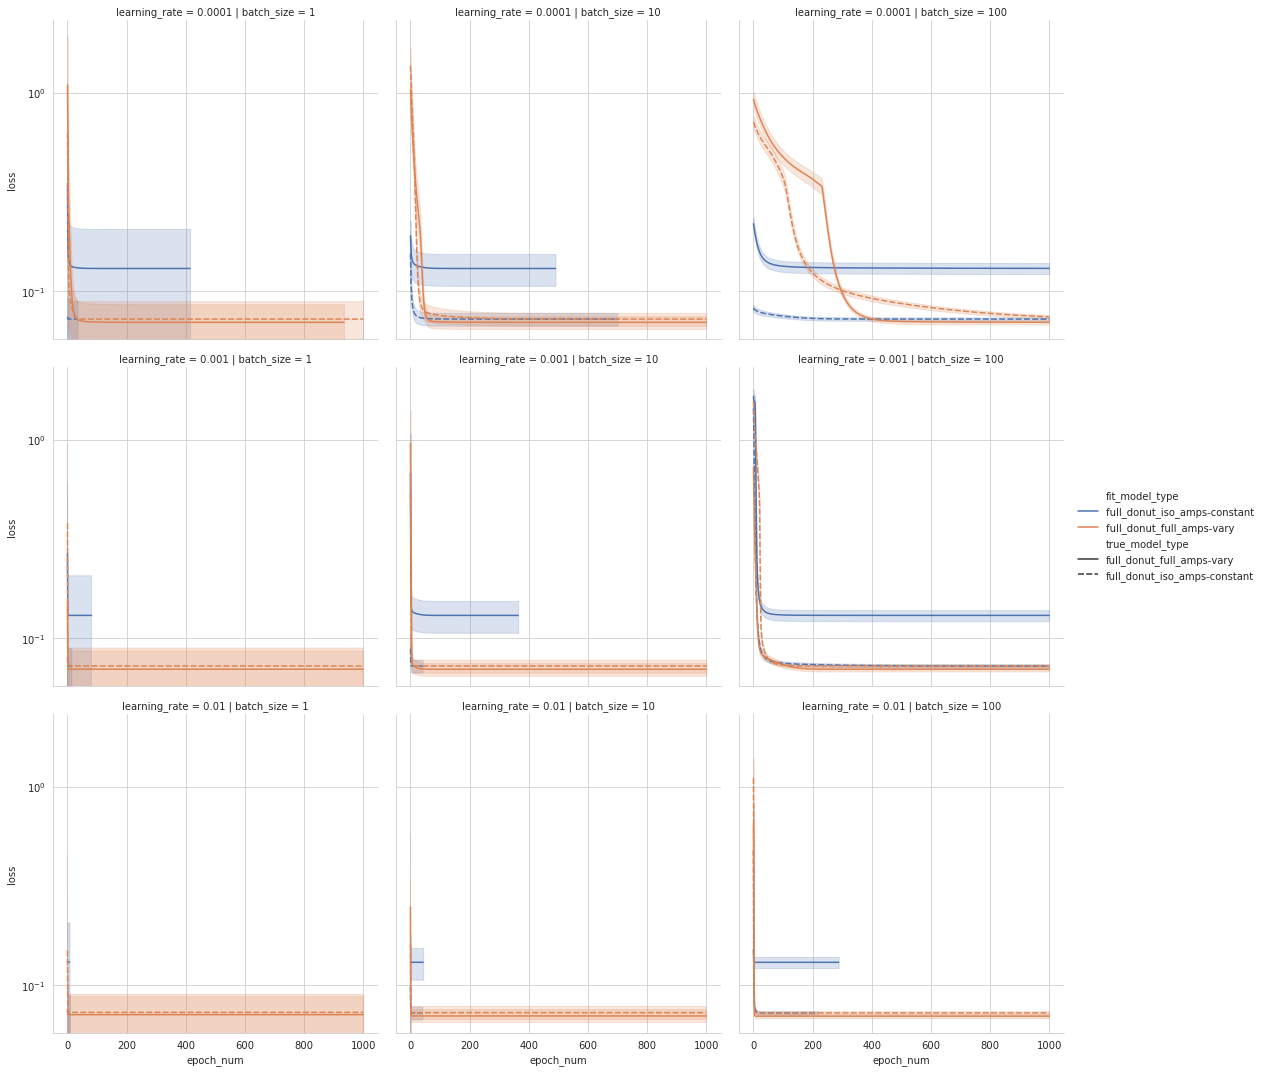

In [36]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('log', basey=10)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


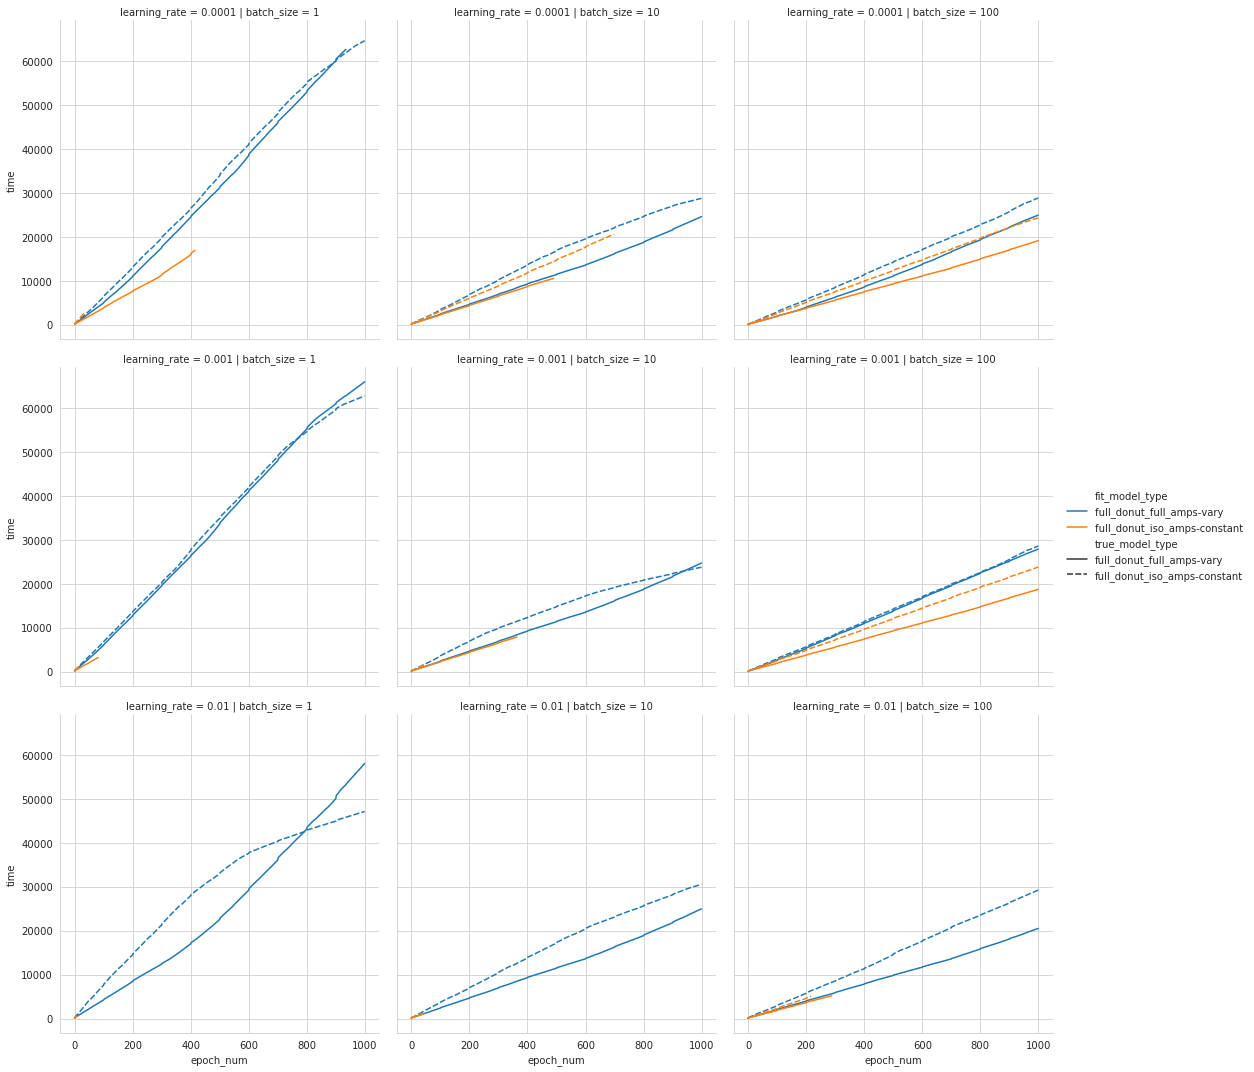

In [558]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', style='true_model_type', data=timing_df, col='batch_size', row='learning_rate', kind='line', legend='full')

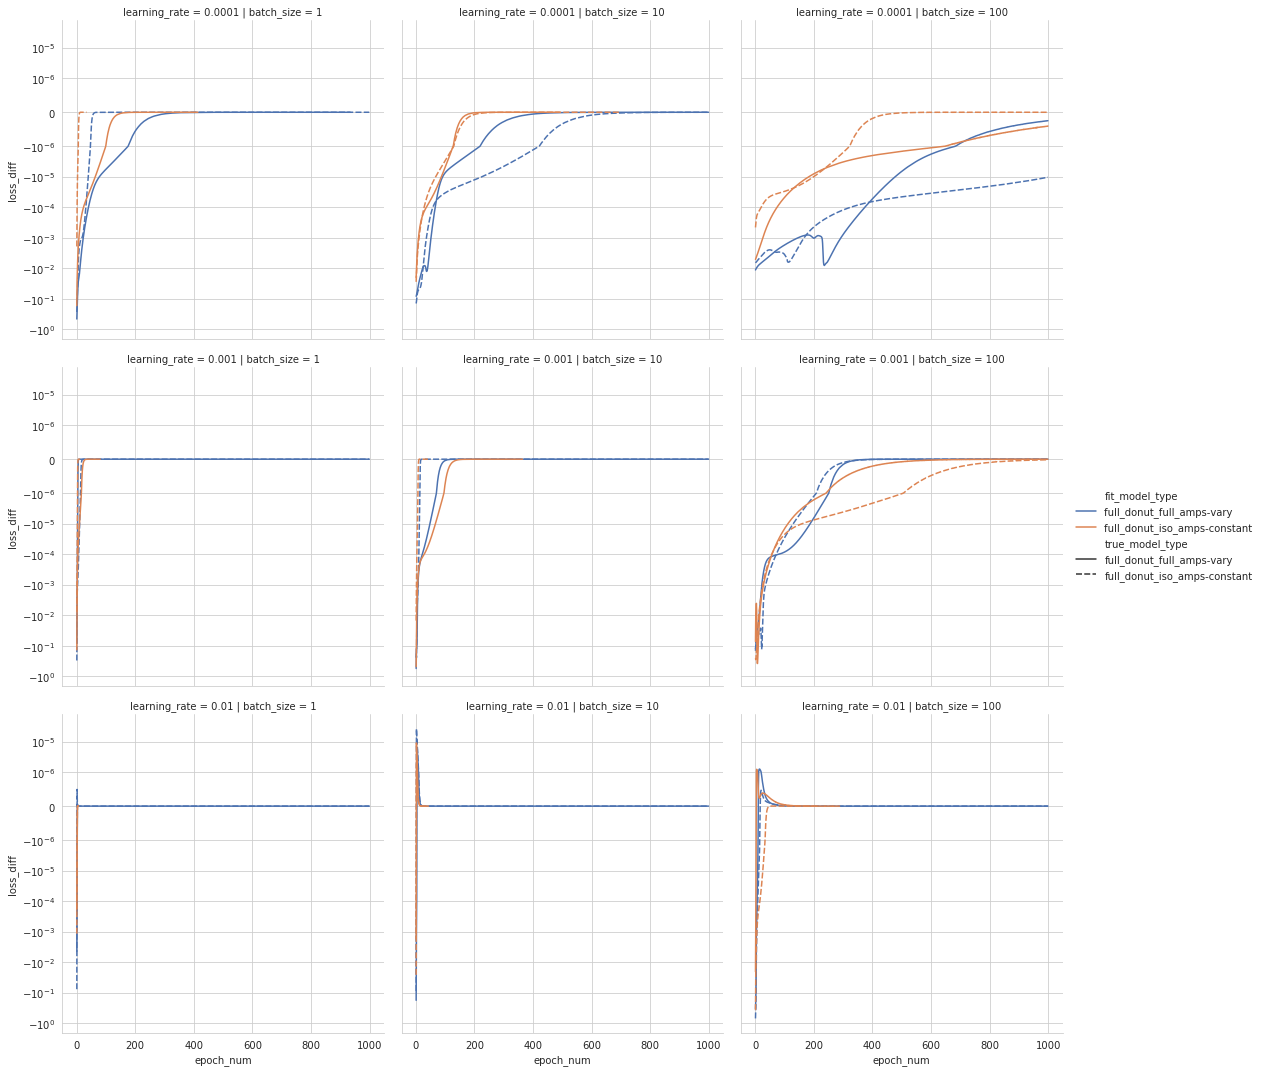

In [107]:
g = sns.relplot('epoch_num', 'loss_diff', 'fit_model_type', style='true_model_type', data=avg_loss, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

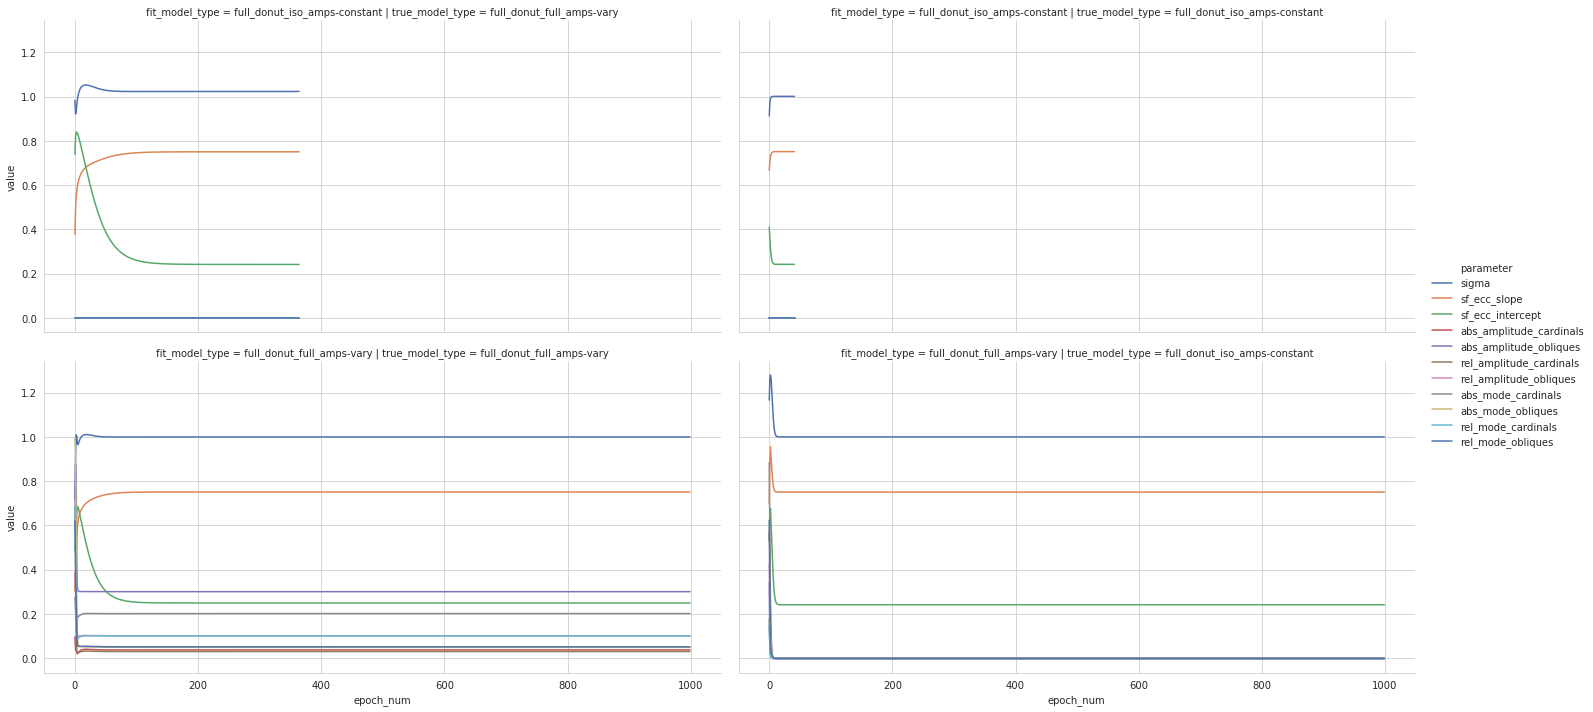

In [111]:
g=sns.relplot('epoch_num', 'value', 'parameter', row='fit_model_type', col='true_model_type', hue_order=param_col_order,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

This is really bad, looks like the model thinks we know nothing about anything

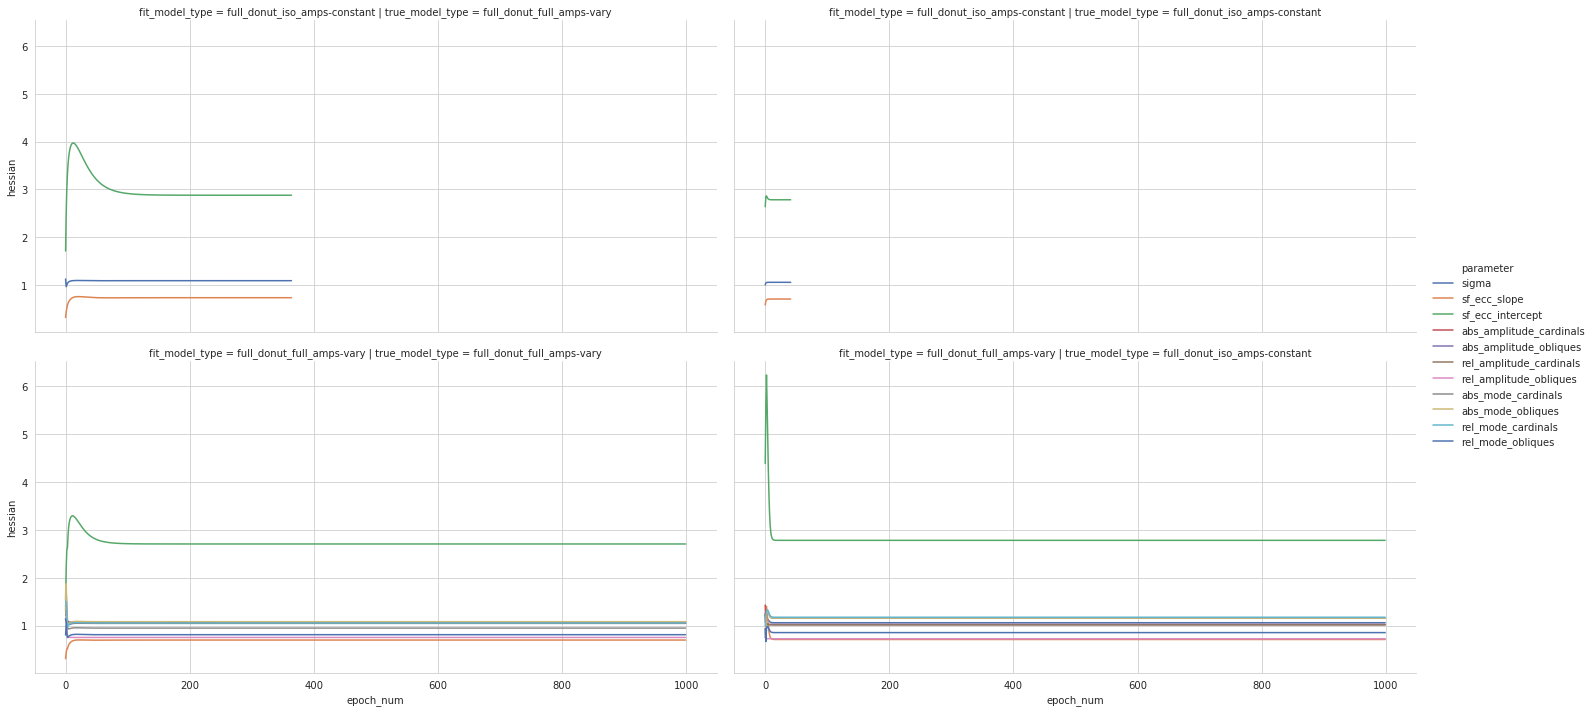

In [152]:
g=sns.relplot('epoch_num', 'hessian', 'parameter', row='fit_model_type', col='true_model_type', hue_order=param_col_order,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

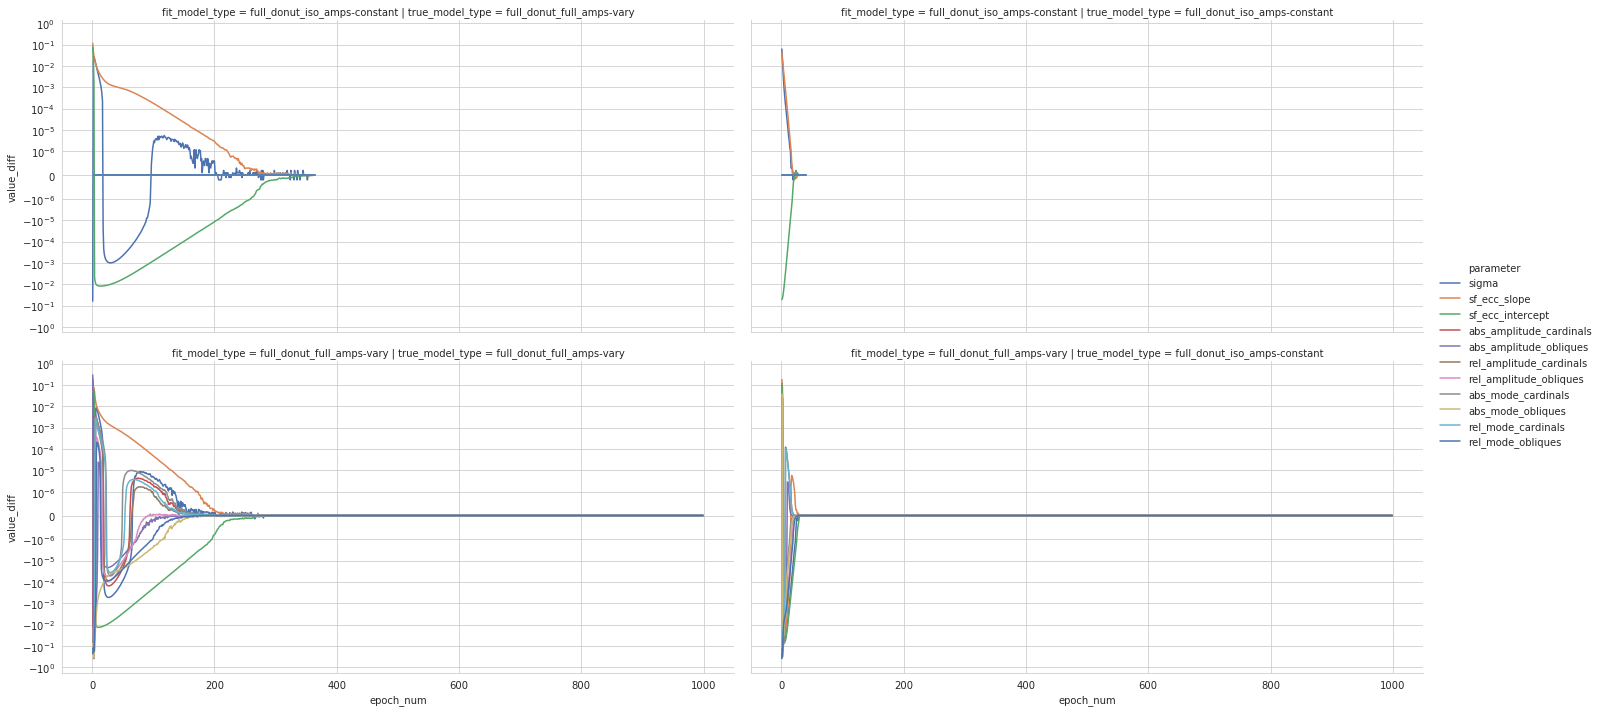

In [109]:
g=sns.relplot('epoch_num', 'value_diff', 'parameter', row='fit_model_type', col='true_model_type', hue_order=param_col_order,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

In [112]:
grouped_loss = loss_df.groupby(['true_model_type', 'fit_model_type', 'learning_rate', 'batch_size', 'epoch_num']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['true_model_type', 'fit_model_type', 'learning_rate', 'batch_size']).last().reset_index()

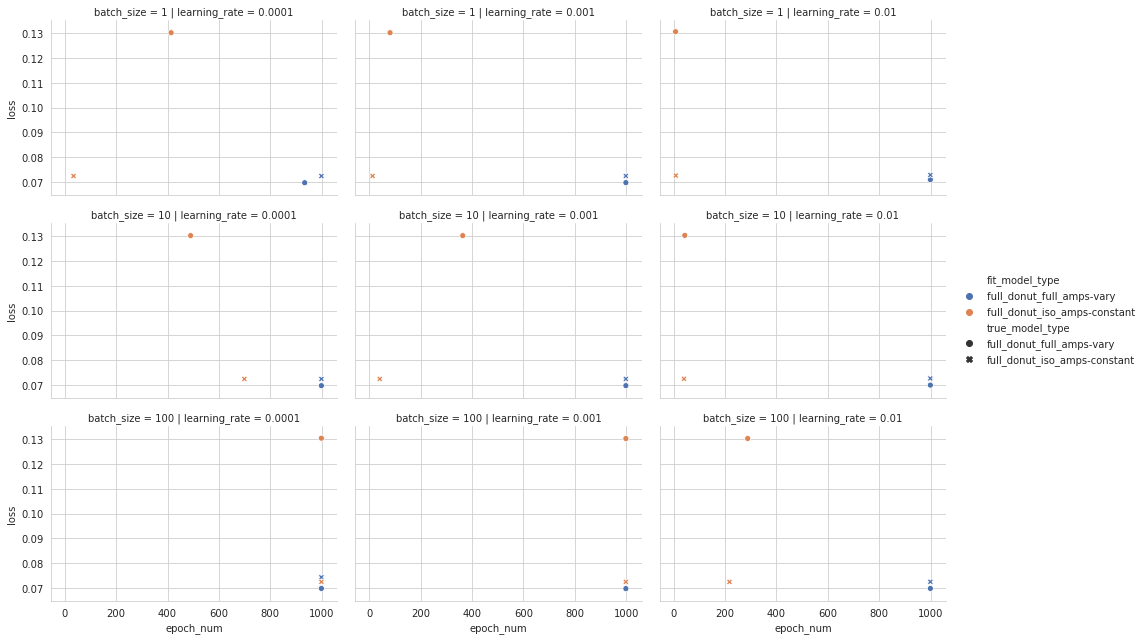

In [116]:
sns.relplot('epoch_num', 'loss', row='batch_size', col='learning_rate', data=grouped_loss, hue='fit_model_type', style='true_model_type', legend='full', palette=sns.color_palette('deep', 2), aspect=1.5, height=3)

In [125]:
params = models.pivot_table('fit_value', ['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type'], 'model_parameter')

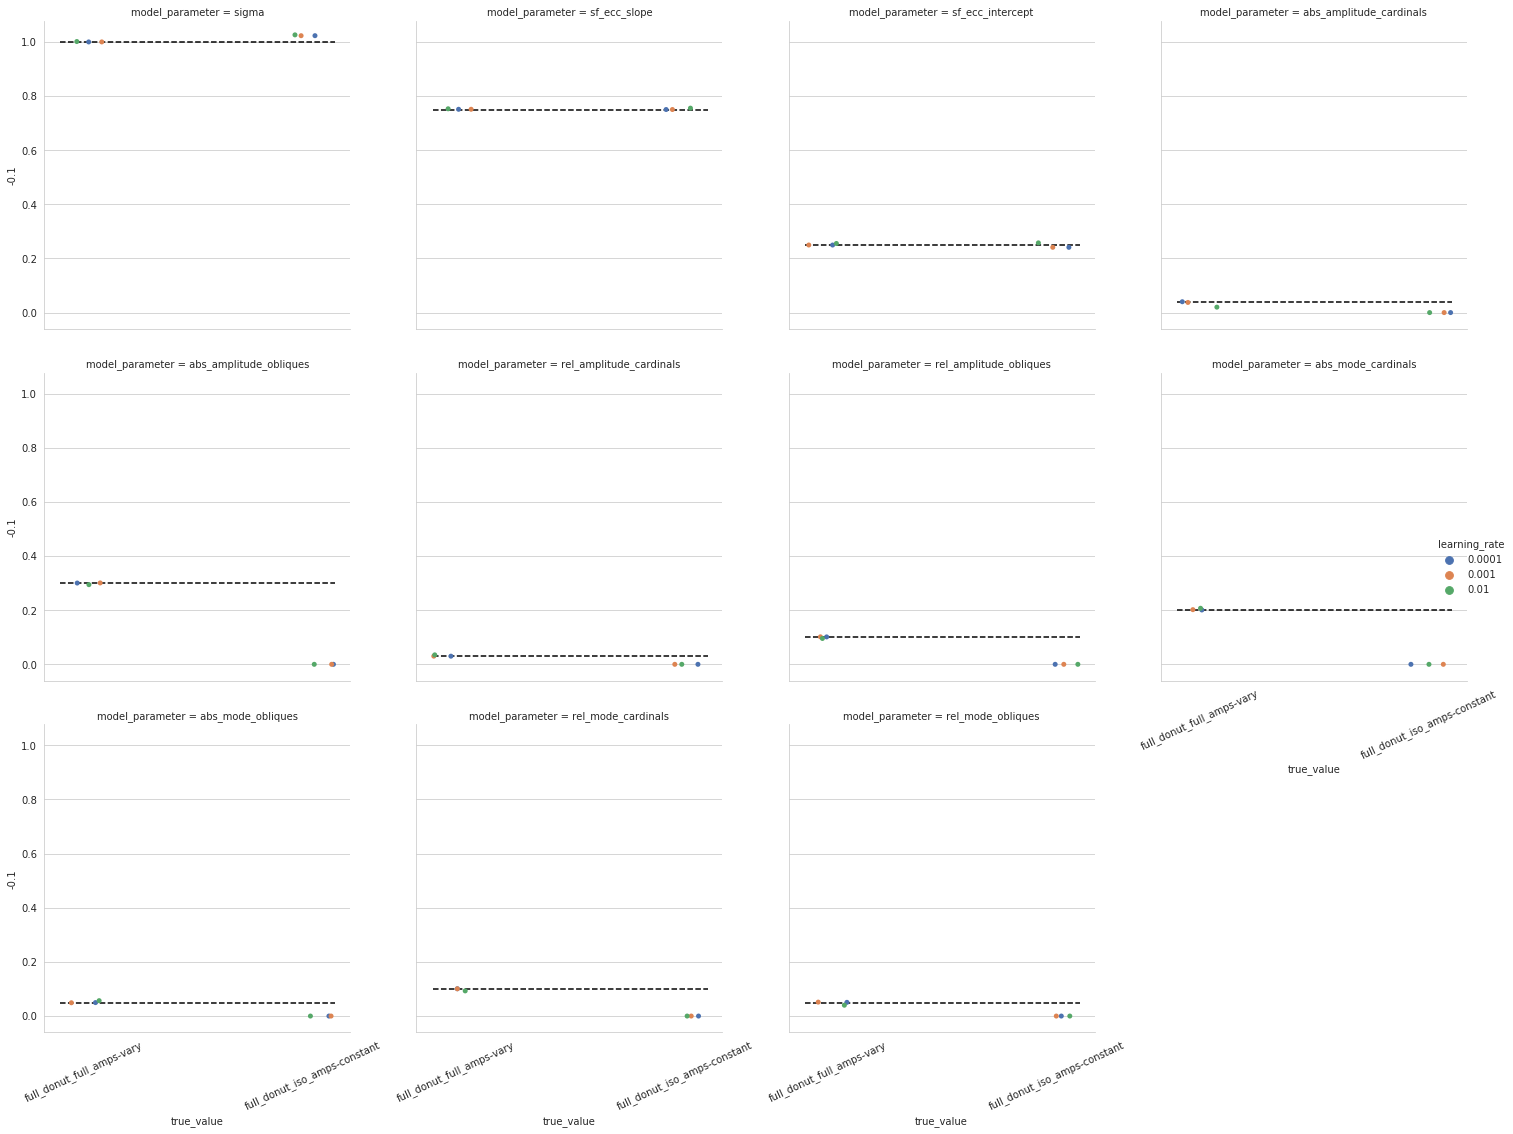

In [145]:
def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.catplot('fit_model_type', 'fit_value', 'learning_rate', data=models.query('true_model_type=="full_donut_full_amps-vary" & batch_size==10'), col='model_parameter', #style='learning_rate',
                  palette=sns.color_palette('deep', 3), col_wrap=4, col_order=param_col_order,)
g.map_dataframe(custom_hline, 'true_value', -.1, 1.1, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

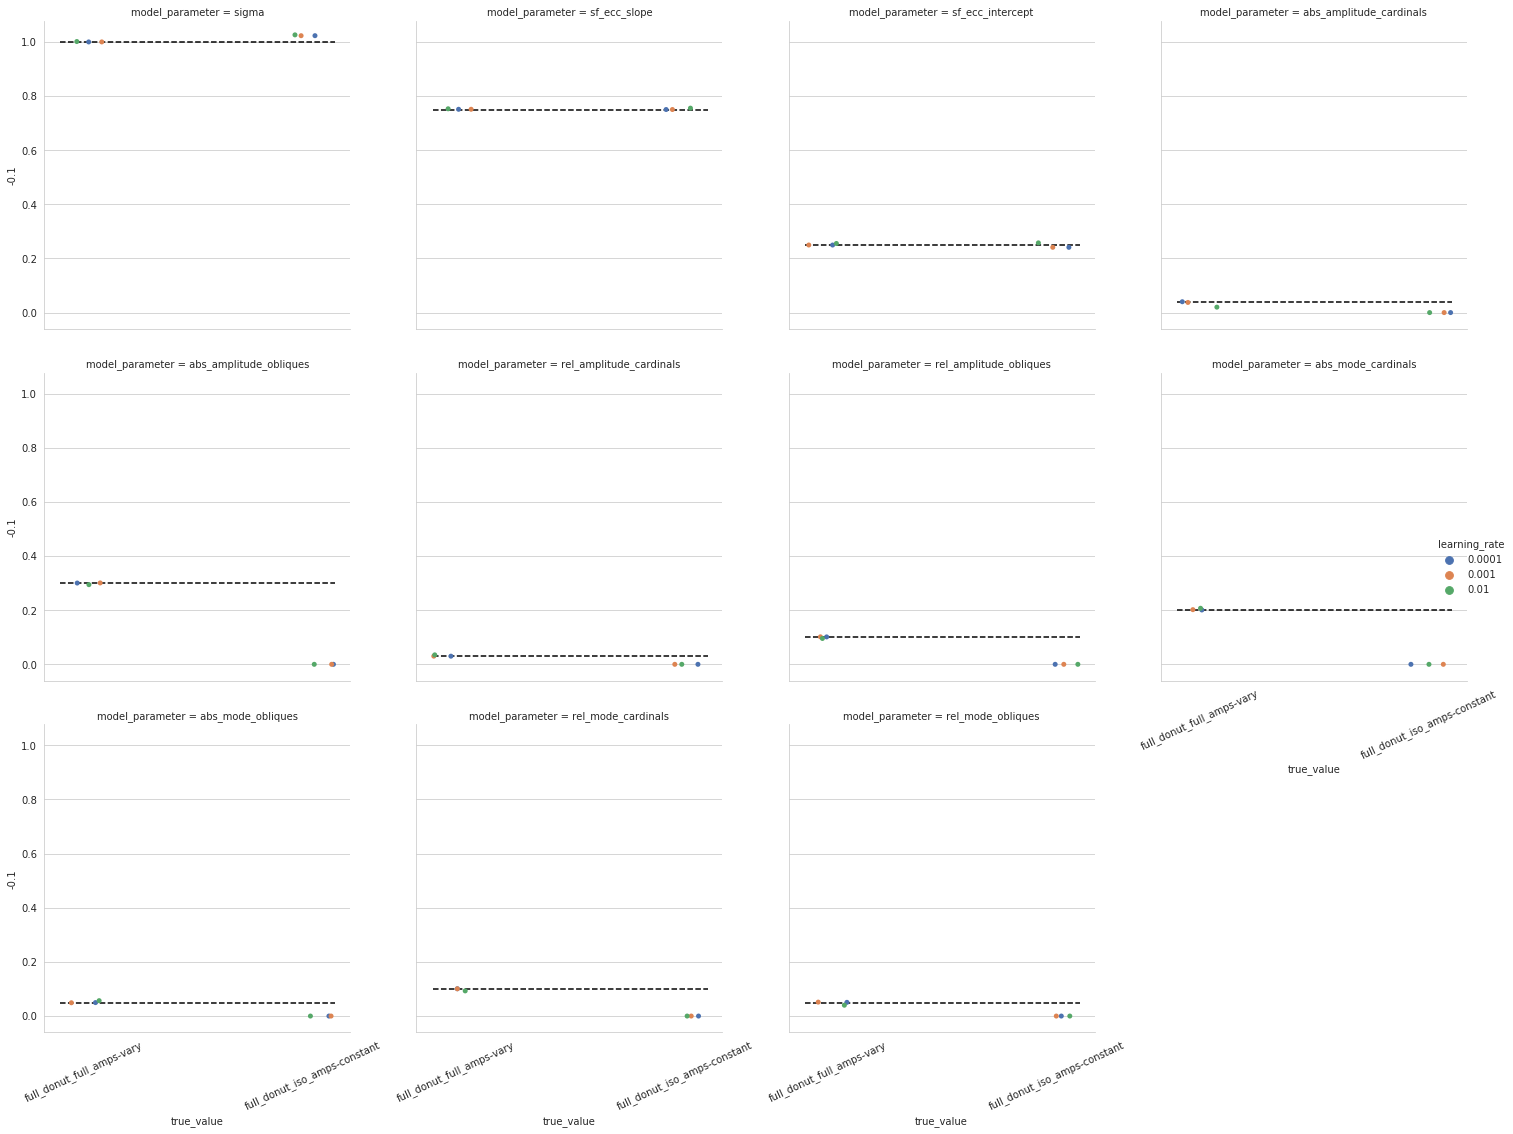

In [145]:
def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.catplot('fit_model_type', 'fit_value', 'learning_rate', data=models.query('true_model_type=="full_donut_full_amps-vary" & batch_size==10'), col='model_parameter', #style='learning_rate',
                  palette=sns.color_palette('deep', 3), col_wrap=4, col_order=param_col_order,)
g.map_dataframe(custom_hline, 'true_value', -.1, 1.1, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

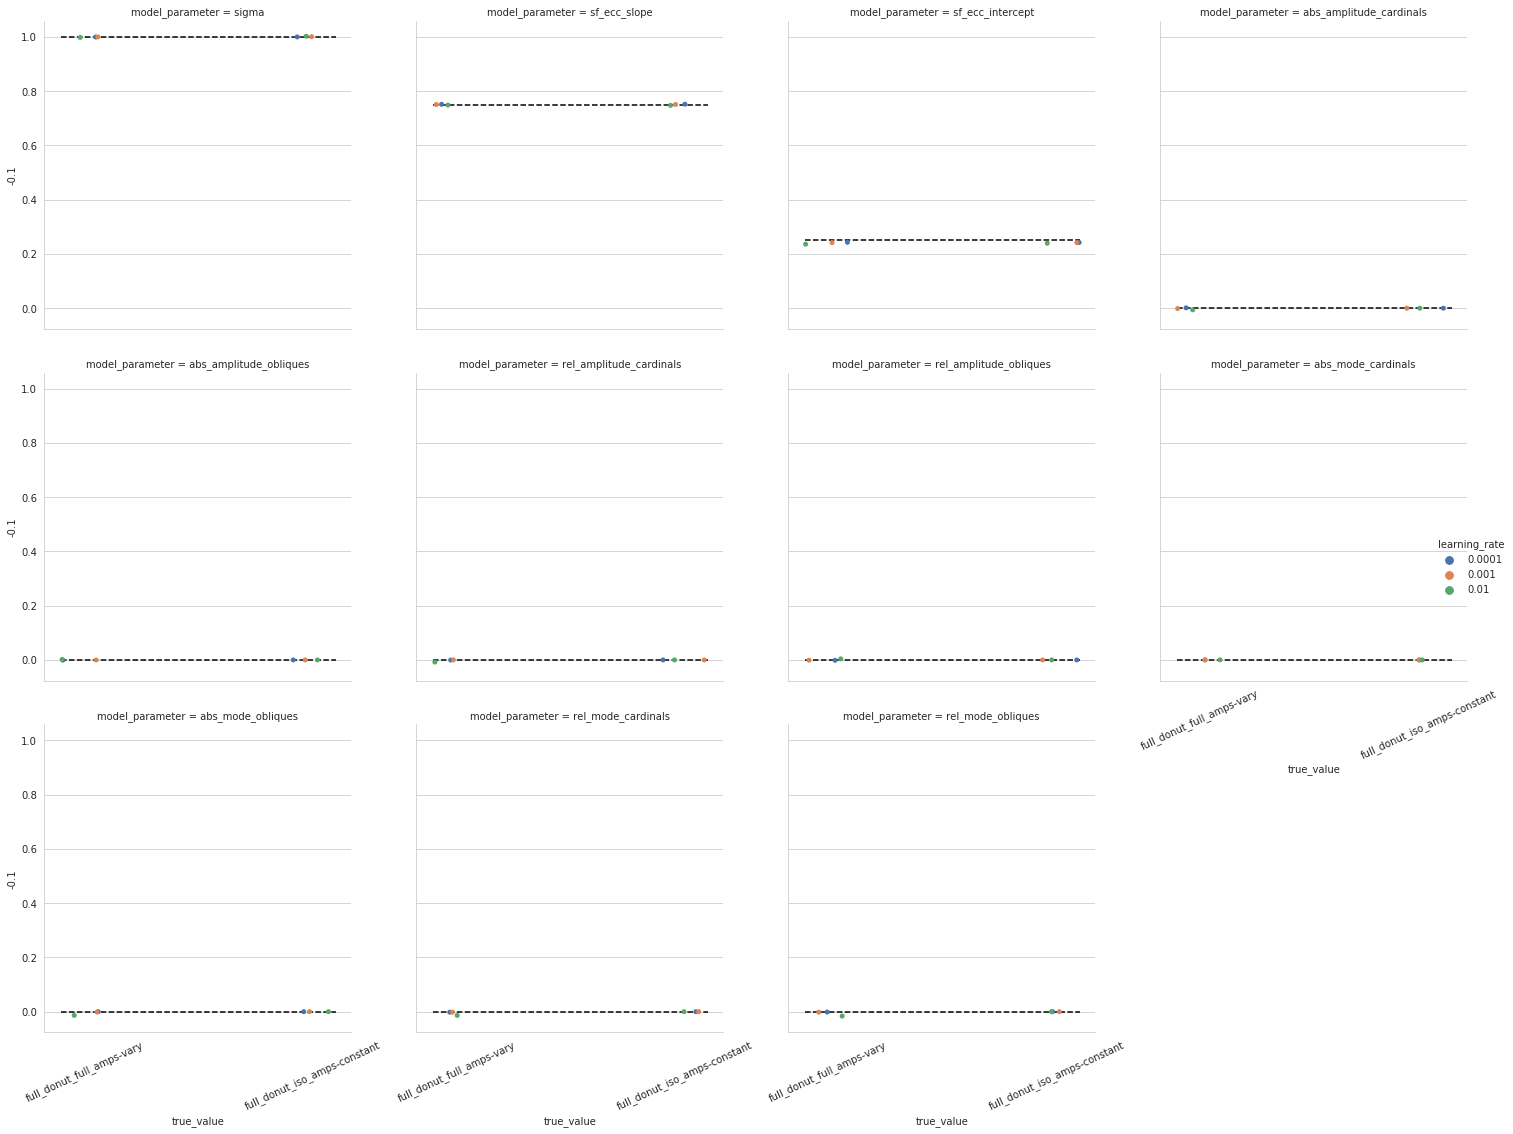

In [146]:
def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.catplot('fit_model_type', 'fit_value', 'learning_rate', data=models.query('true_model_type=="full_donut_iso_amps-constant" & batch_size==10'), col='model_parameter',
                  palette=sns.color_palette('deep', 3), col_wrap=4, col_order=param_col_order,)
g.map_dataframe(custom_hline, 'true_value', -.1, 1.1, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated model recovery

In [290]:
models, loss_df, results_df, model_history = sfp.analyze_model.combine_models('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery/*', False)

../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "


In [126]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [33]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

In [34]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'epoch_num'])[['time']].max().reset_index()

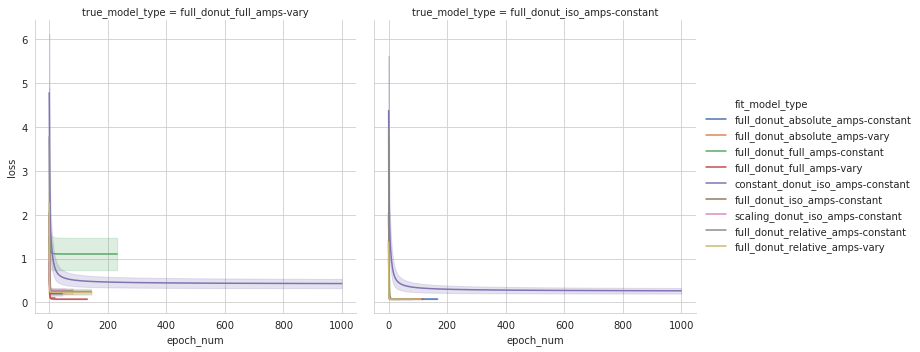

In [12]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', col='true_model_type', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 9) )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

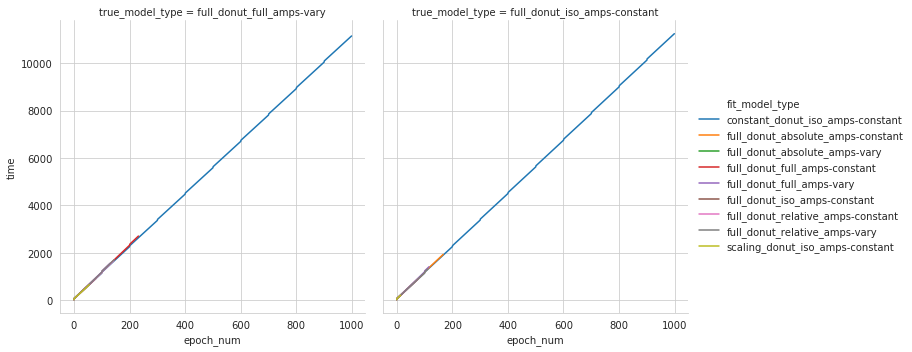

In [20]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', data=timing_df, col='true_model_type', kind='line', legend='full')

In [35]:
grouped_loss = loss_df.groupby(['fit_model_type', 'true_model_type','epoch_num', 'time']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type', 'true_model_type']).last().reset_index()

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


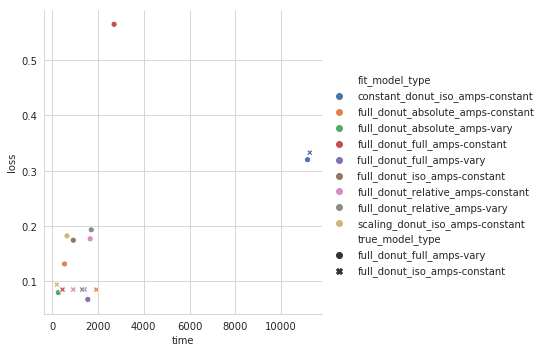

In [136]:
sns.relplot('time', 'loss', 'fit_model_type', data=grouped_loss, style='true_model_type', legend='full', palette=sns.color_palette('deep', 9), )#hue_order=[i+" " for i in model_order])

In [291]:
models.pivot_table('fit_value', ['true_model_type', 'fit_model_type'], 'model_parameter')

model_parameter                                                 abs_amplitude_cardinals  \
true_model_type              fit_model_type                                               
full_donut_full_amps-vary    constant_donut_iso_amps-constant                  0.000000   
                             full_donut_absolute_amps-constant                 0.000000   
                             full_donut_absolute_amps-vary                     0.044522   
                             full_donut_full_amps-constant                     0.000000   
                             full_donut_full_amps-vary                         0.045396   
                             full_donut_iso_amps-constant                      0.000000   
                             full_donut_relative_amps-constant                 0.000000   
                             full_donut_relative_amps-vary                     0.000000   
                             scaling_donut_iso_amps-constant                   0.000000   
full_donut_iso_amps-constant constant_donut_iso_amps-constant                  0.000000   
                             full_donut_absolute_amps-constant                 0.000000   
                             full_donut_absolute_amps-vary                     0.001382   
                             full_donut_full_amps-constant                     0.000000   
                             full_donut_full_amps-vary                         0.002444   
                             full_donut_iso_amps-constant                      0.000000   
                             full_donut_relative_amps-constant                 0.000000   
                             full_donut_relative_amps-vary                     0.000000   
                             scaling_donut_iso_amps-constant                   0.000000   

model_parameter                                                 abs_amplitude_obliques  \
true_model_type              fit_model_type                                              
full_donut_full_amps-vary    constant_donut_iso_amps-constant                 0.000000   
                             full_donut_absolute_amps-constant                0.000000   
                             full_donut_absolute_amps-vary                    0.289242   
                             full_donut_full_amps-constant                    0.000000   
                             full_donut_full_amps-vary                        0.300462   
                             full_donut_iso_amps-constant                     0.000000   
                             full_donut_relative_amps-constant                0.000000   
                             full_donut_relative_amps-vary                    0.000000   
                             scaling_donut_iso_amps-constant                  0.000000   
full_donut_iso_amps-constant constant_donut_iso_amps-constant                 0.000000   
                             full_donut_absolute_amps-constant                0.000000   
                             full_donut_absolute_amps-vary                   -0.000640   
                             full_donut_full_amps-constant                    0.000000   
                             full_donut_full_amps-vary                       -0.000917   
                             full_donut_iso_amps-constant                     0.000000   
                             full_donut_relative_amps-constant                0.000000   
                             full_donut_relative_amps-vary                    0.000000   
                             scaling_donut_iso_amps-constant                  0.000000   

model_parameter                                                 abs_mode_cardinals  \
true_model_type              fit_model_type                                          
full_donut_full_amps-vary    constant_donut_iso_amps-constant             0.000000   
                             full_donut_absolute_amps-constant            0.145346   
                             full_

In [292]:
models.pivot_table('true_value', ['true_model_type'], 'model_parameter')

model_parameter               abs_amplitude_cardinals  abs_amplitude_obliques  \
true_model_type                                                                 
full_donut_full_amps-vary                        0.04                     0.3   
full_donut_iso_amps-constant                     0.00                     0.0   

model_parameter               abs_mode_cardinals  abs_mode_obliques  \
true_model_type                                                       
full_donut_full_amps-vary                    0.2               0.05   
full_donut_iso_amps-constant                 0.0               0.00   

model_parameter               rel_amplitude_cardinals  rel_amplitude_obliques  \
true_model_type                                                                 
full_donut_full_amps-vary                        0.03                     0.1   
full_donut_iso_amps-constant                     0.00                     0.0   

model_parameter               rel_mode_cardinals  rel_mode_obliques  \
true_model_type                                                       
full_donut_full_amps-vary                    0.1               0.05   
full_donut_iso_amps-constant                 0.0               0.00   

model_parameter               sf_ecc_intercept  sf_ecc_slope  sigma  
true_model_type                                                      
full_donut_full_amps-vary                 0.25          0.75    1.0  
full_donut_iso_amps-constant              0.25          0.75    1.0

In [74]:
final_model_history = model_history.groupby(['fit_model_type', 'true_model_type', 'parameter']).last().reset_index().rename(columns={'parameter': 'model_parameter'})
models = pd.merge(models, final_model_history[['fit_model_type', 'true_model_type', 'model_parameter', 'hessian']])
models = models.fillna(0)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


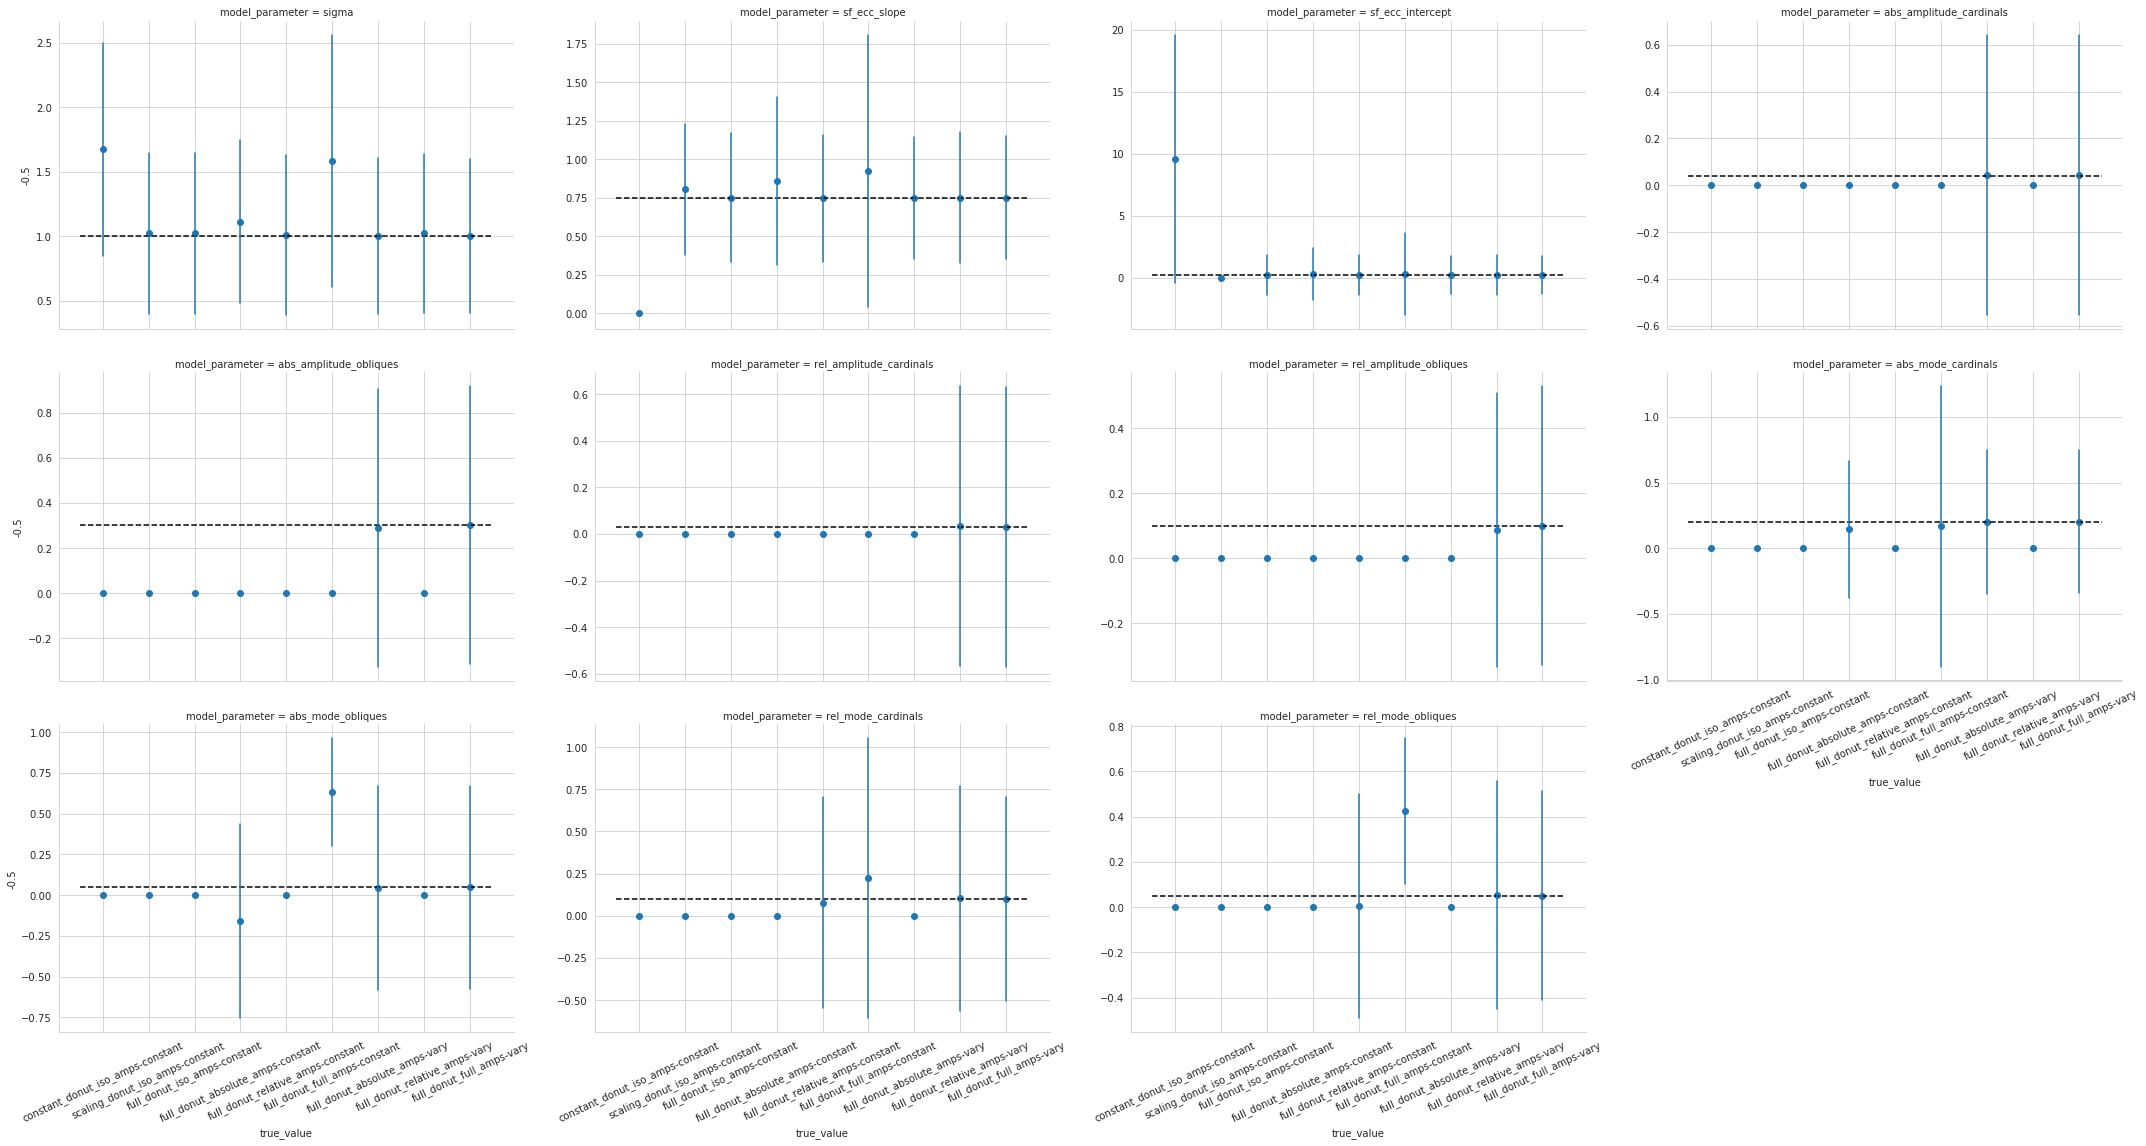

In [129]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary"'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


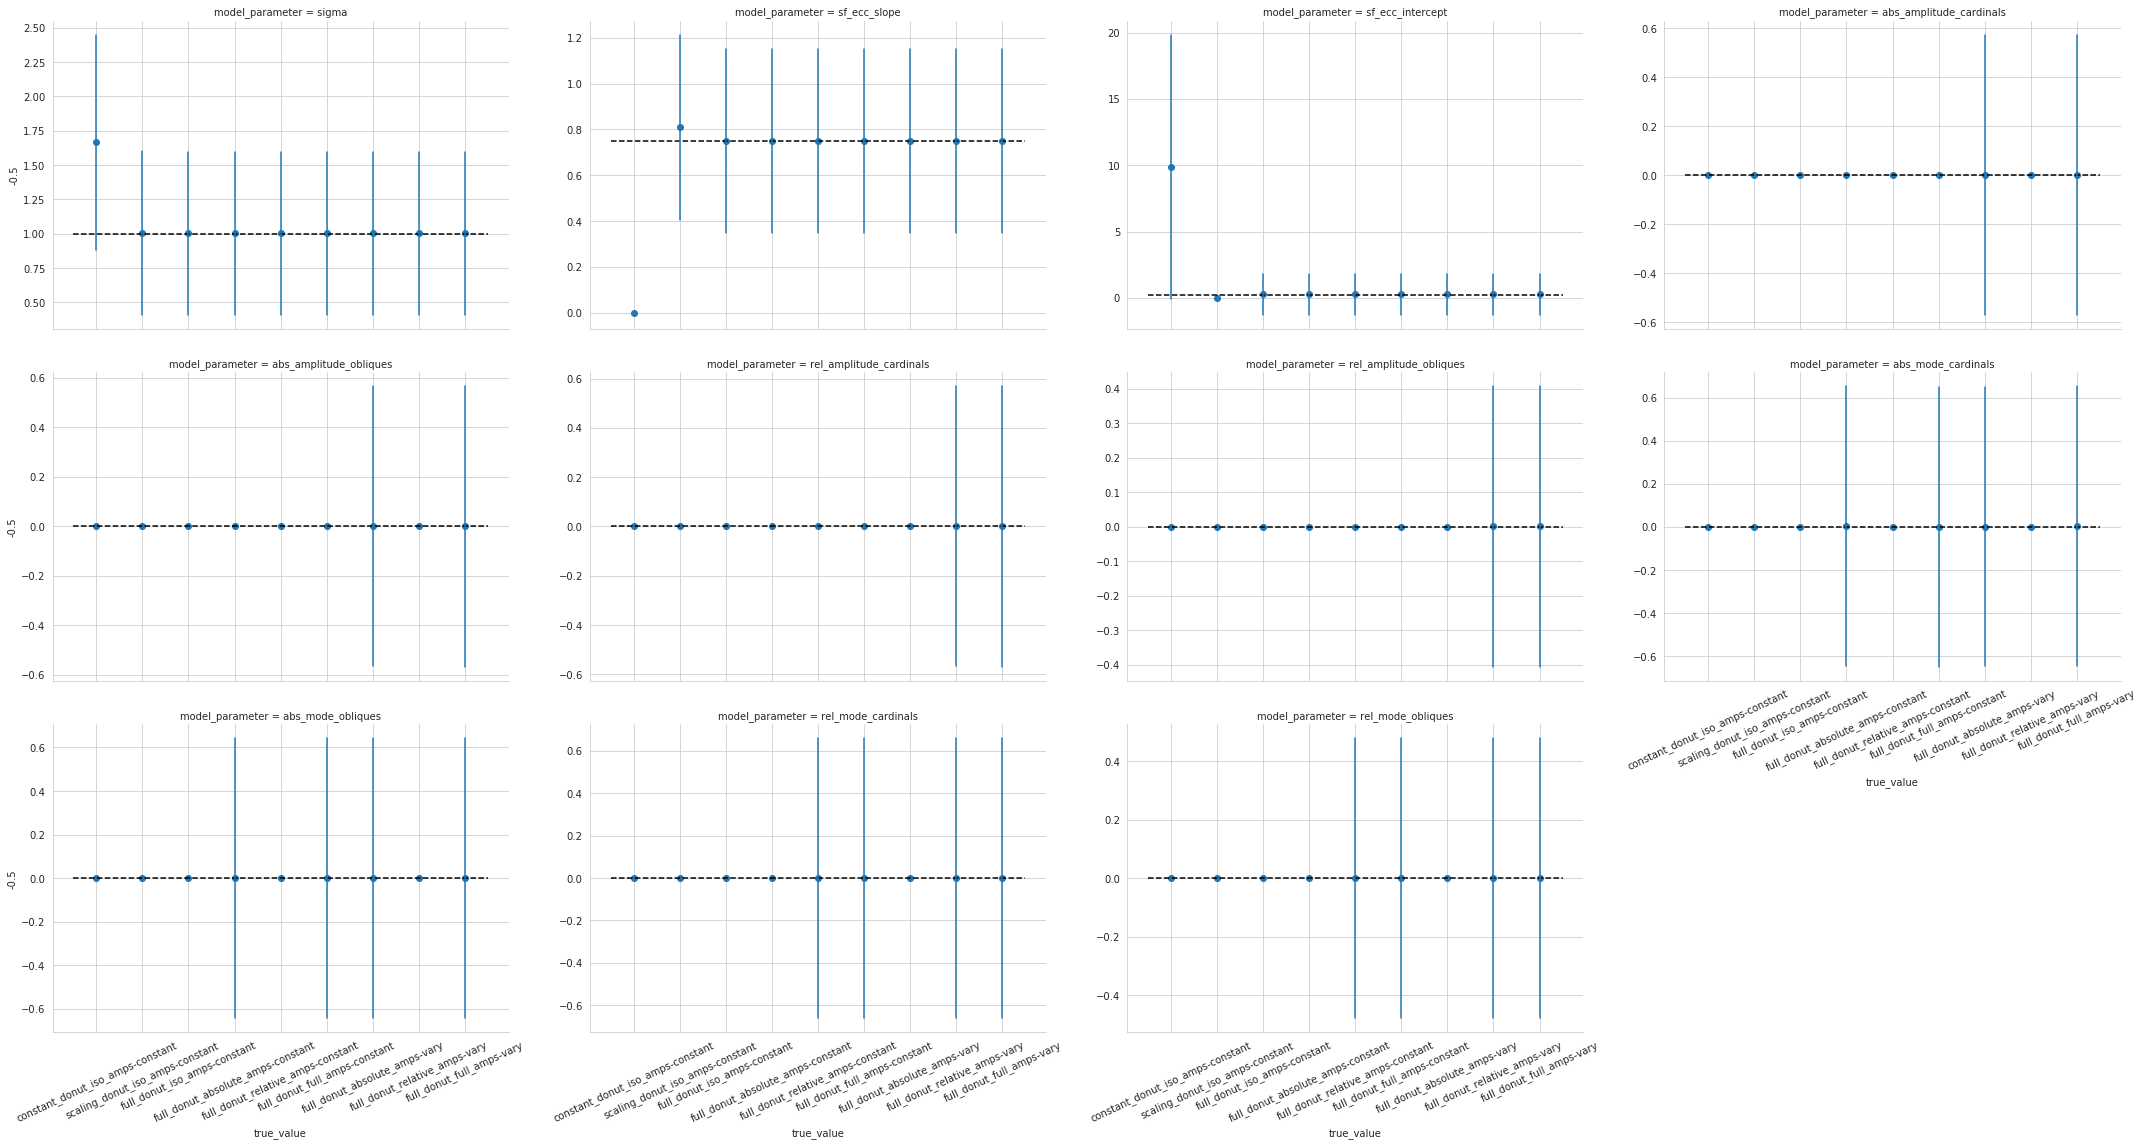

In [130]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant"'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated cross-validated model recovery

In [137]:
models, loss_df, results_df, model_history = sfp.analyze_model.combine_models('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery_cv/*', False)

../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is const

In [138]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

In [139]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'epoch_num'])[['time']].max().reset_index()

In [207]:
grouped_loss = loss_df.groupby(['fit_model_type', 'true_model_type','data_subset', 'test_subset','epoch_num', 'time']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type', 'true_model_type','data_subset', 'test_subset',]).last().reset_index()

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


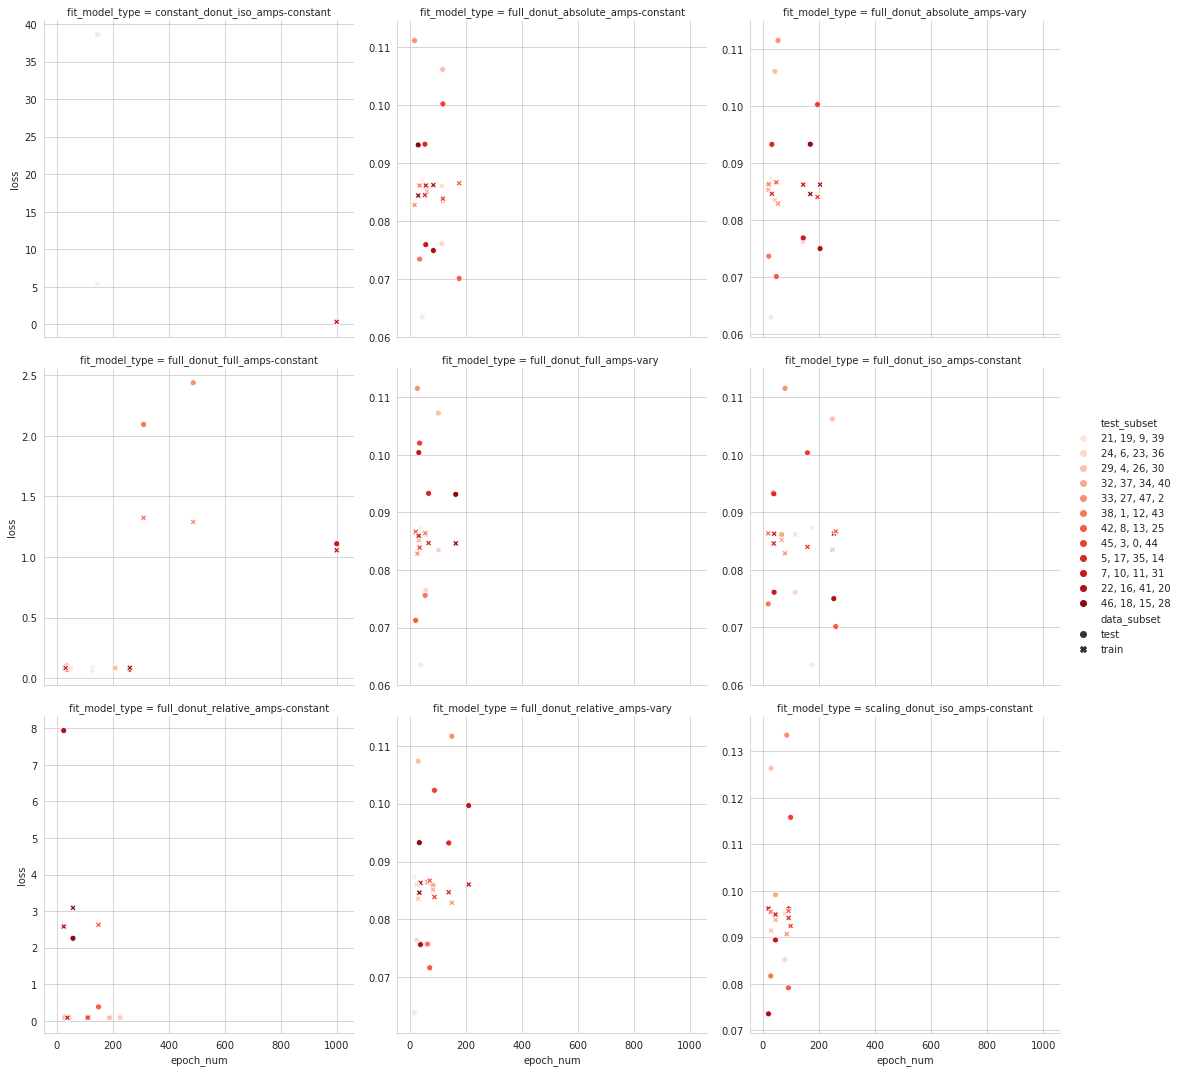

In [184]:
sns.relplot('epoch_num', 'loss', 'test_subset', style='data_subset', data=grouped_loss.query("true_model_type=='full_donut_iso_amps-constant'"), col='fit_model_type', 
            col_wrap=3, palette=sns.color_palette('Reds', 12), facet_kws={'sharey': False})

In [230]:
tmp = grouped_loss.groupby(['true_model_type', 'fit_model_type', 'data_subset'])[['loss', 'epoch_num', 'time']].mean().reset_index()
pd.pivot_table(tmp, 'loss', ['true_model_type', 'fit_model_type'], 'data_subset').sort_values(['true_model_type','test'])#.reindex(itertools.product(['full_donut_full_amps-vary', 'full_donut_iso_amps-constant'], model_order),)

data_subset                                                         test  \
true_model_type              fit_model_type                                
full_donut_full_amps-vary    full_donut_full_amps-vary          0.068986   
                             full_donut_absolute_amps-vary      0.083763   
                             full_donut_iso_amps-constant       0.175199   
                             scaling_donut_iso_amps-constant    0.183026   
                             constant_donut_iso_amps-constant   0.357567   
                             full_donut_relative_amps-vary      0.408402   
                             full_donut_absolute_amps-constant  0.416857   
                             full_donut_full_amps-constant      0.574266   
                             full_donut_relative_amps-constant  1.217600   
full_donut_iso_amps-constant full_donut_absolute_amps-constant  0.085332   
                             full_donut_absolute_amps-vary      0.085467   
                             full_donut_iso_amps-constant       0.085484   
                             full_donut_full_amps-vary          0.088003   
                             full_donut_relative_amps-vary      0.088048   
                             scaling_donut_iso_amps-constant    0.098014   
                             full_donut_full_amps-constant      0.572593   
                             full_donut_relative_amps-constant  0.947124   
                             constant_donut_iso_amps-constant   4.167214   

data_subset                                                        train  
true_model_type              fit_model_type                               
full_donut_full_amps-vary    full_donut_full_amps-vary          0.067395  
                             full_donut_absolute_amps-vary      0.079639  
                             full_donut_iso_amps-constant       0.174623  
                             scaling_donut_iso_amps-constant    0.182373  
                             constant_donut_iso_amps-constant   0.753949  
                             full_donut_relative_amps-vary      0.367552  
                             full_donut_absolute_amps-constant  0.342922  
                             full_donut_full_amps-constant      0.368954  
                             full_donut_relative_amps-constant  0.486508  
full_donut_iso_amps-constant full_donut_absolute_amps-constant  0.085211  
                             full_donut_absolute_amps-vary      0.085334  
                             full_donut_iso_amps-constant       0.085323  
                             full_donut_full_amps-vary          0.085276  
                             full_donut_relative_amps-vary      0.085291  
                             scaling_donut_iso_amps-constant    0.094010  
                             full_donut_full_amps-constant      0.395525  
                             full_donut_relative_amps-constant  0.755207  
                             constant_donut_iso_amps-constant   0.840645

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


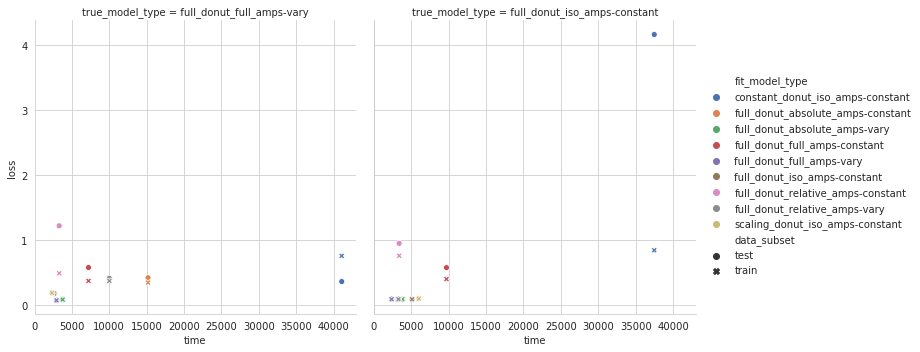

In [228]:
sns.relplot('time', 'loss', 'fit_model_type', data=tmp, style='data_subset', col='true_model_type', legend='full', palette=sns.color_palette('deep', 9), )#hue_order=[i+" " for i in model_order])

In [231]:
final_model_history = model_history.groupby(['fit_model_type', 'true_model_type', 'parameter']).last().reset_index().rename(columns={'parameter': 'model_parameter'})
models = pd.merge(models, final_model_history[['fit_model_type', 'true_model_type', 'model_parameter', 'hessian']])
models = models.fillna(0)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


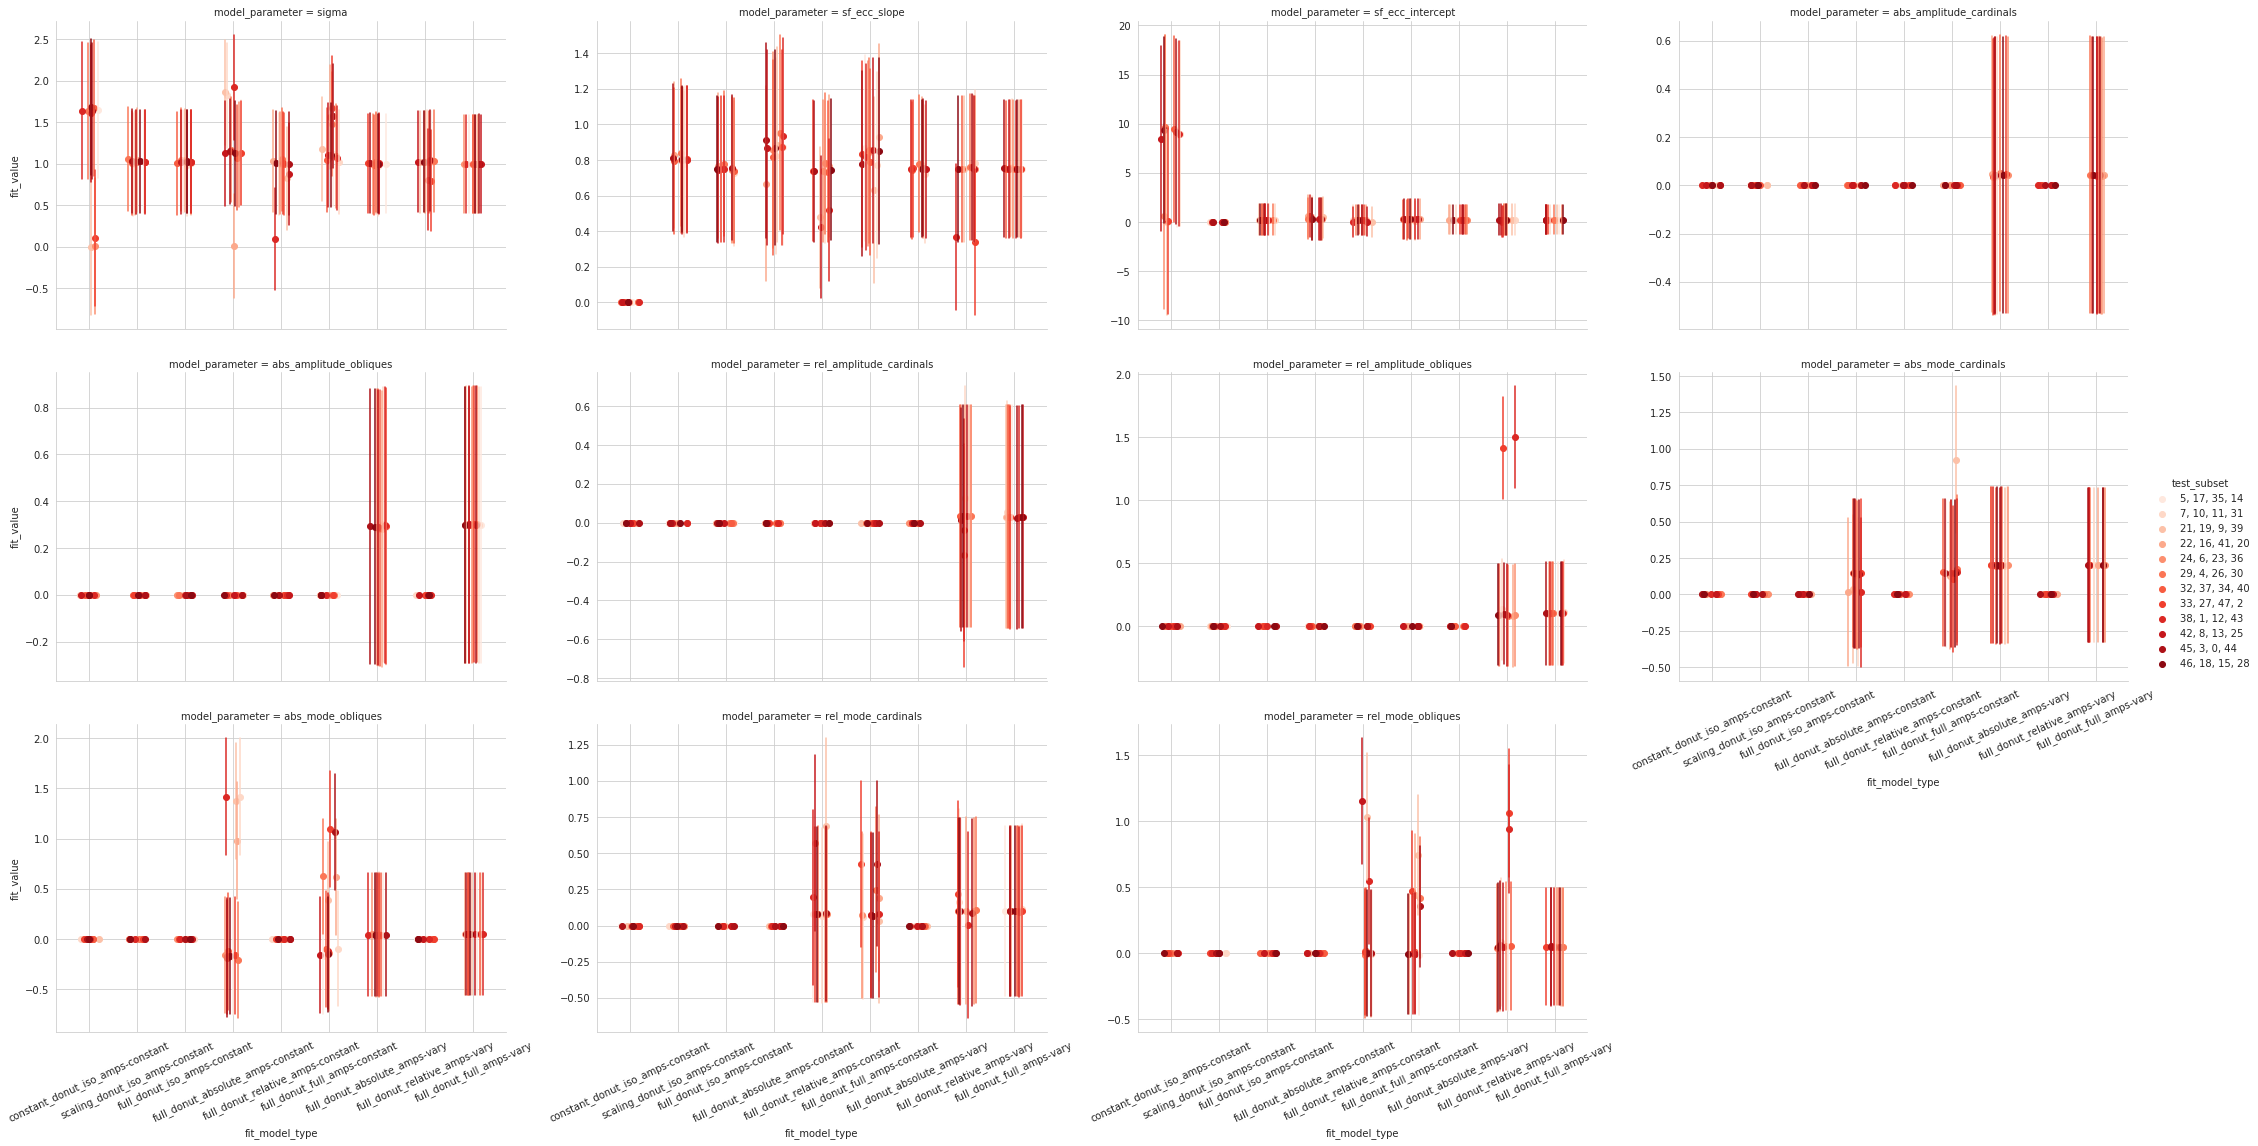

In [284]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary"'), col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


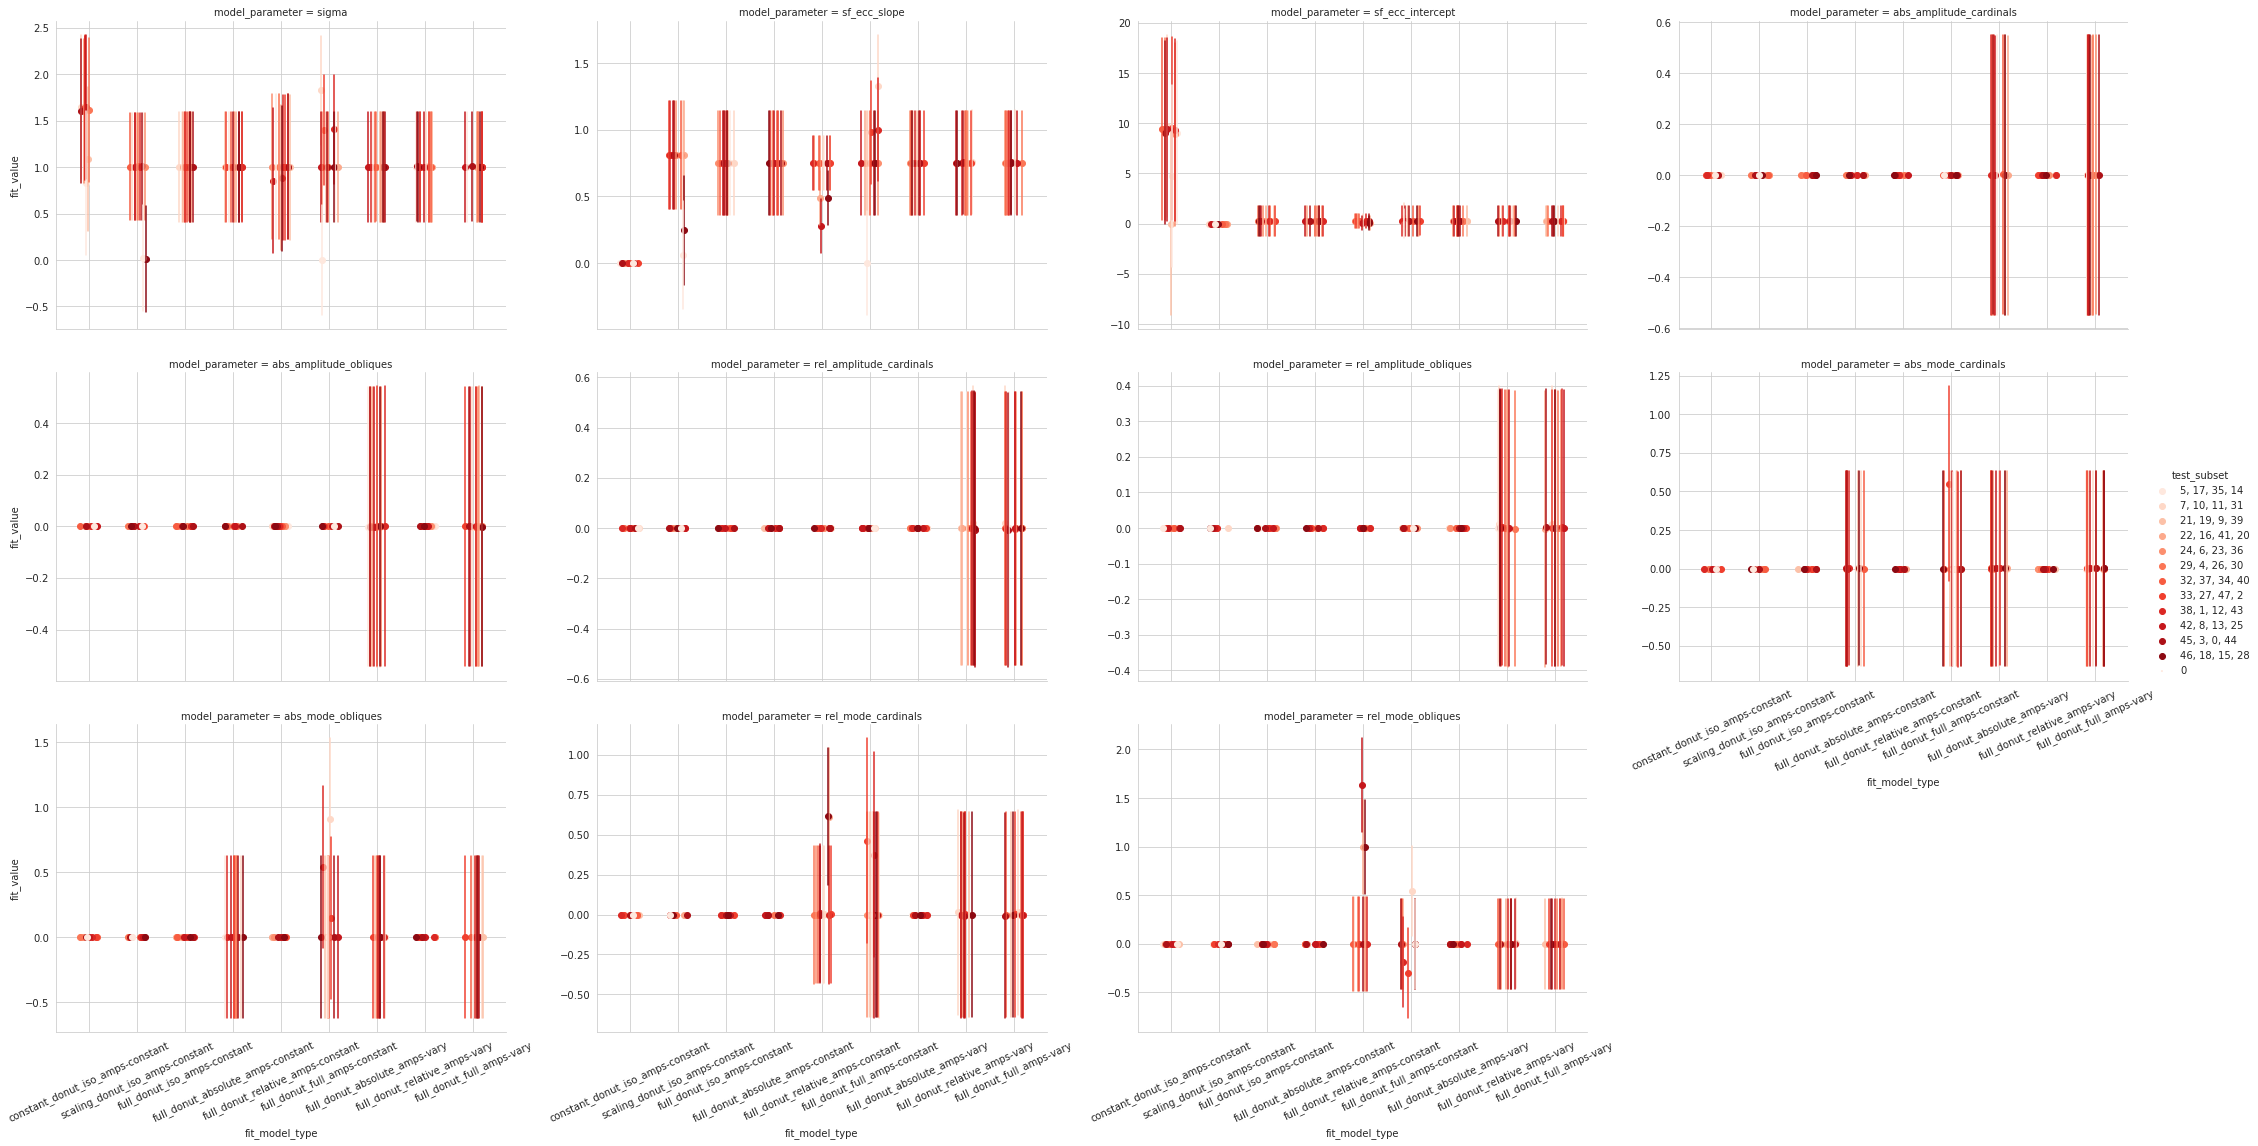

In [285]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant"'), col='model_parameter', hue='test_subset', 
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
# g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

## Looking at subjects' cross-validated model fits

### Single subject, single session

This is similar to the above, except there's only one true model and we don't know it.

In [2]:
models, loss_df, results_df, model_history = sfp.analyze_model.combine_models('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/initial/sub-wlsubj045/ses-04/*', False)

../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:181: UserWarning: When eccentricity_type is const

In [31]:
timing_df = loss_df.groupby(['fit_model_type', 'test_subset', 'epoch_num'])[['time']].max().reset_index()

In [12]:
grouped_loss = loss_df.groupby(['fit_model_type','data_subset', 'test_subset','epoch_num', 'time']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type','data_subset', 'test_subset',]).last().reset_index()

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


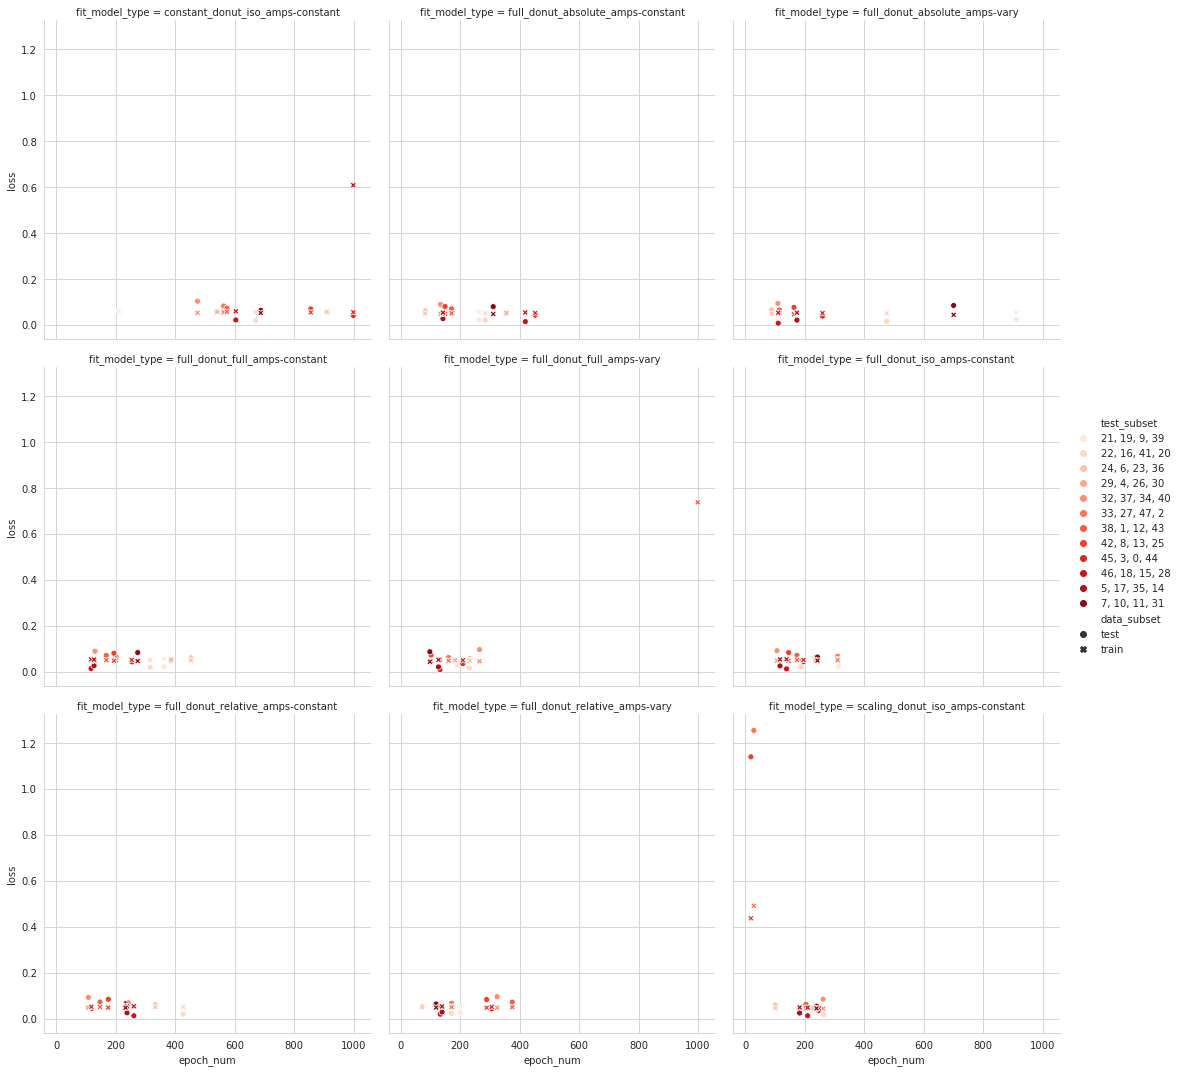

In [308]:
sns.relplot('epoch_num', 'loss', 'test_subset', style='data_subset', data=grouped_loss, col='fit_model_type', 
            col_wrap=3, palette=sns.color_palette('Reds', 12), facet_kws={'sharey': True})

In [306]:
tmp = grouped_loss.groupby(['fit_model_type', 'data_subset'])[['loss', 'epoch_num', 'time']].mean().reset_index()
pd.pivot_table(tmp, 'loss', 'fit_model_type', 'data_subset').sort_values('test')#.reindex(itertools.product(['full_donut_full_amps-vary', 'full_donut_iso_amps-constant'], model_order),)

data_subset                            test     train
fit_model_type                                       
full_donut_absolute_amps-vary      0.048044  0.049002
full_donut_full_amps-vary          0.048111  0.105785
full_donut_absolute_amps-constant  0.050796  0.050170
full_donut_iso_amps-constant       0.050858  0.050740
full_donut_relative_amps-constant  0.051261  0.050831
full_donut_full_amps-constant      0.051475  0.050312
full_donut_relative_amps-vary      0.051817  0.050346
constant_donut_iso_amps-constant   0.058021  0.100712
scaling_donut_iso_amps-constant    0.233417  0.115478

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


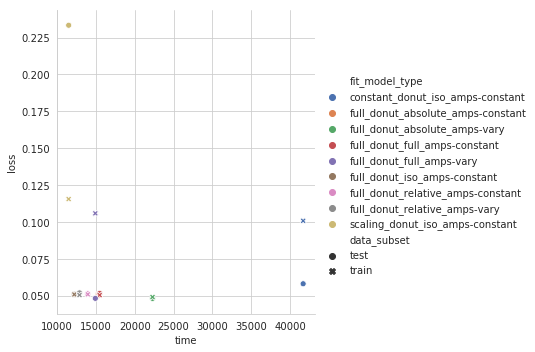

In [307]:
sns.relplot('time', 'loss', 'fit_model_type', data=tmp, style='data_subset', legend='full', palette=sns.color_palette('deep', 9), )#hue_order=[i+" " for i in model_order])

In [309]:
final_model_history = model_history.groupby(['fit_model_type', 'parameter']).last().reset_index().rename(columns={'parameter': 'model_parameter'})
models = pd.merge(models, final_model_history[['fit_model_type', 'model_parameter', 'hessian']])
models = models.fillna(0)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


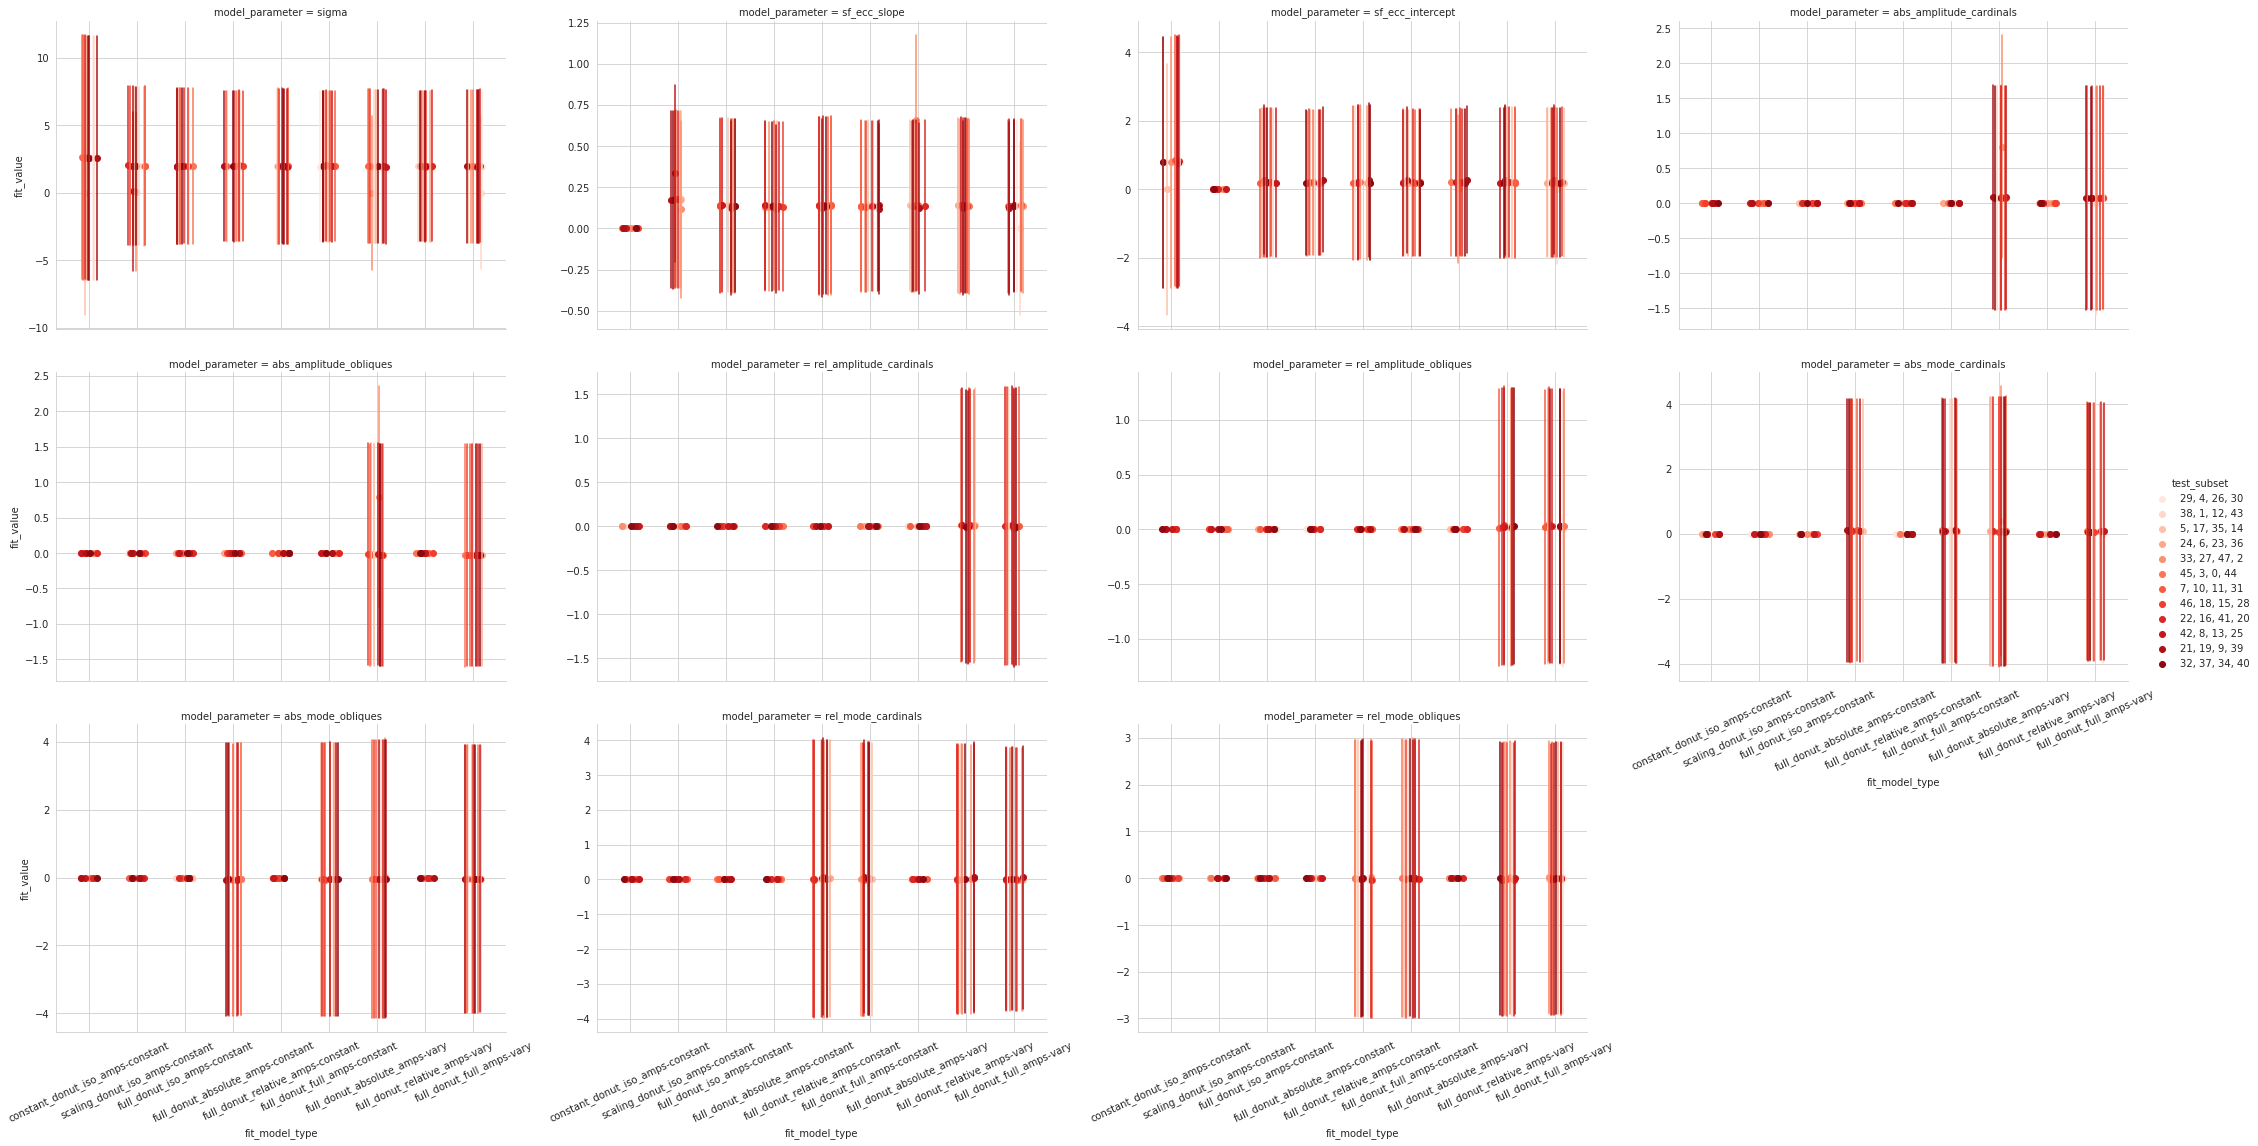

In [310]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models, col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


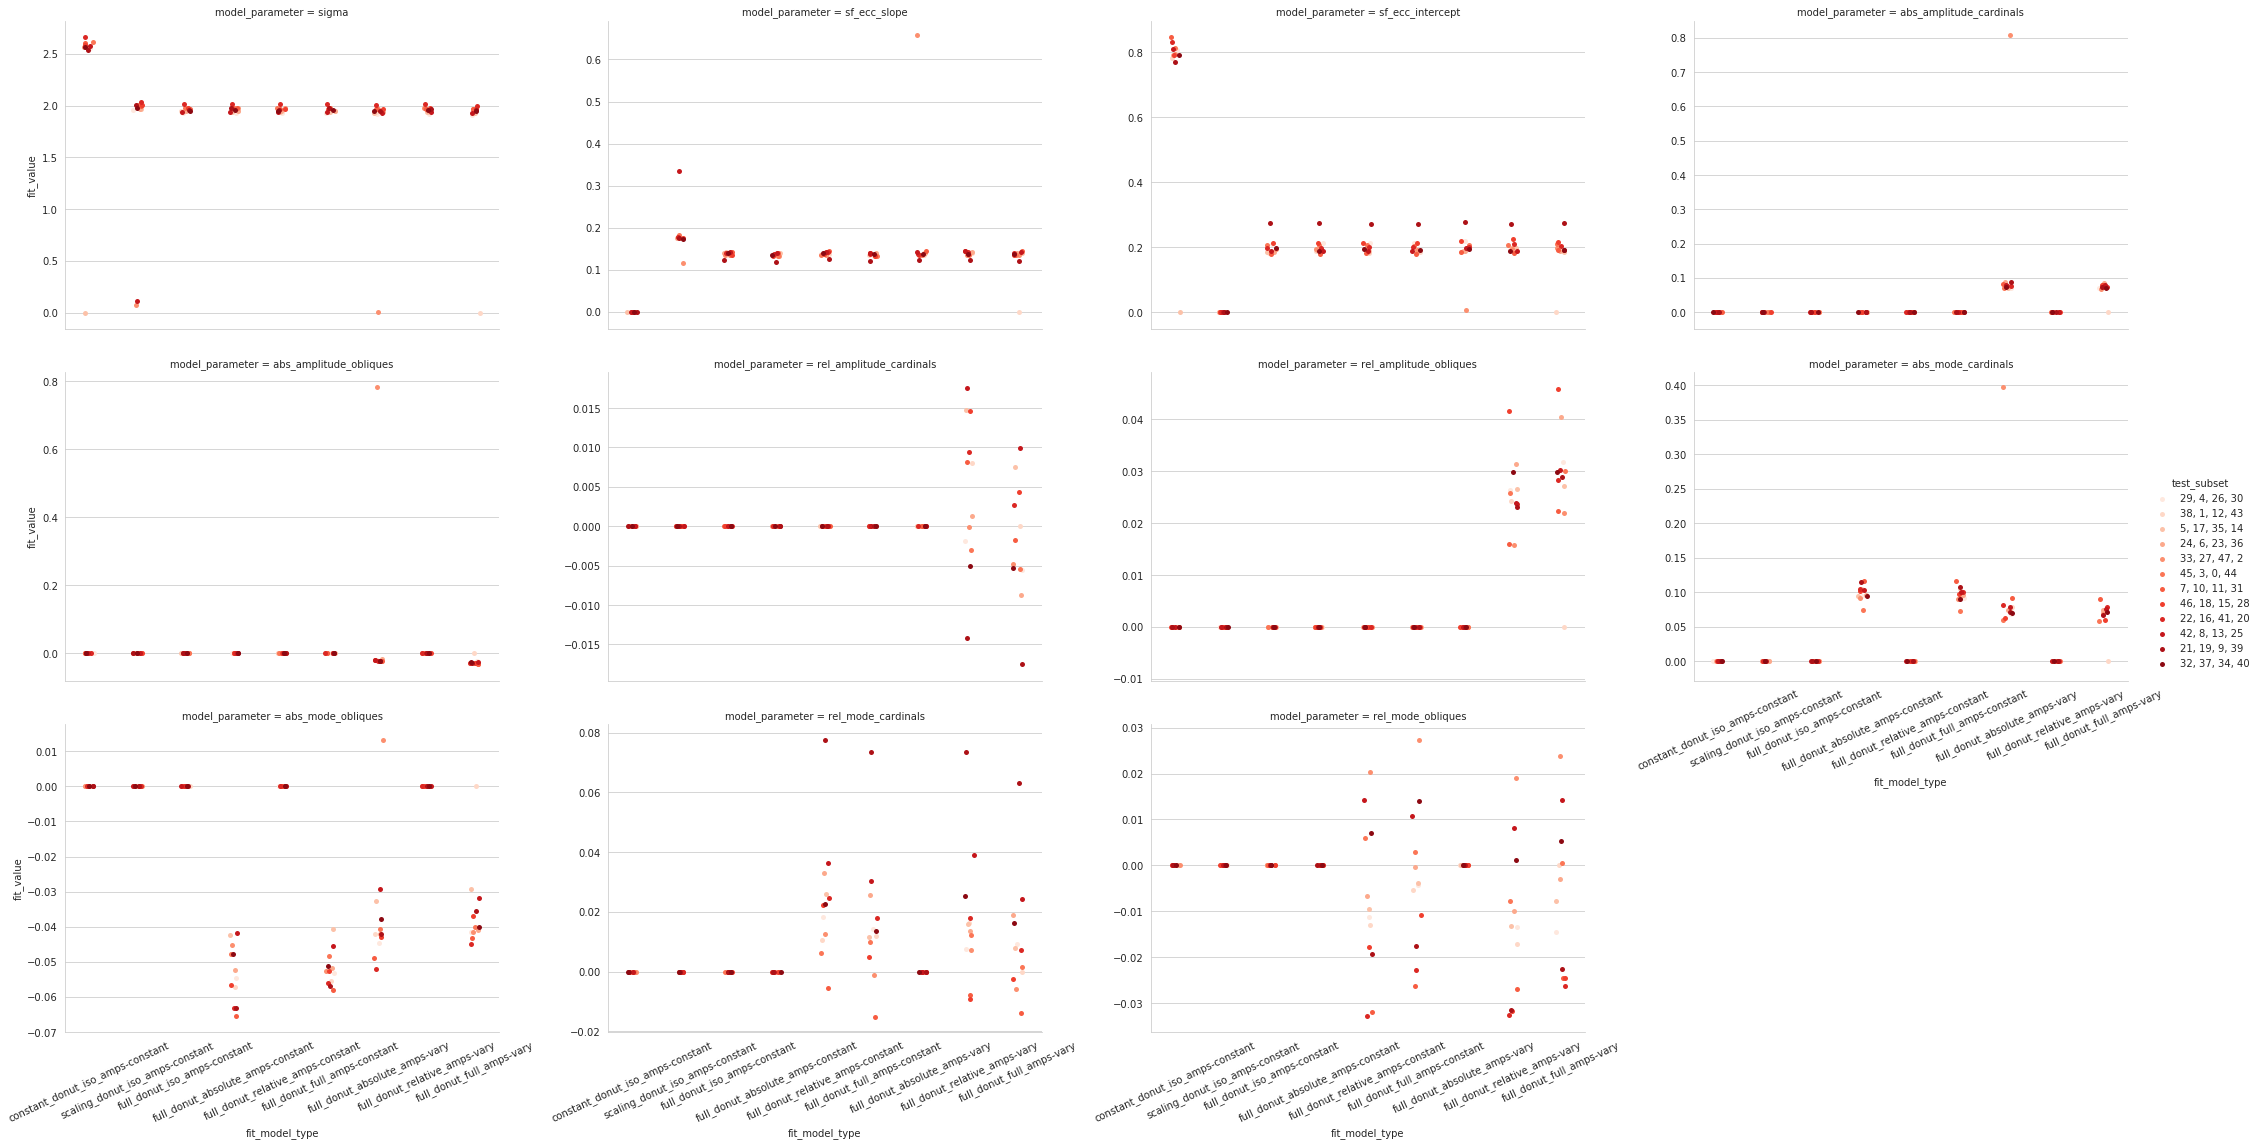

In [313]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models, col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sns.stripplot, 'fit_model_type', 'fit_value', order=model_order, )
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

### Across subjects and sessions

Now we look at all the cross-validated fits to subjects and sessions, using the pre-shrunk data computed by the snakemake rule `summarize_model_cv` (because the files are too big to hold all in memory).

In [85]:
subjects = ['sub-wlsubj045', 'sub-wlsubj045', 'sub-wlsubj001', 'sub-wlsubj064',
            'sub-wlsubj014', 'sub-wlsubj004', 'sub-wlsubj042']
sessions = ['ses-04', 'ses-03', 'ses-01', 'ses-04', 'ses-03', 'ses-03', 'ses-02']
tasks = [{'ses-04': 'task-sfprescaled'}.get(x, 'task-sfp') for x in sessions]
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [54]:
base_str = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/initial/{subject}/{session}/{subject}_{session}_{task}_v1_e1-12_summary_b10_r0.001_g0_s0'
models = []
grouped_loss_df = []
timing_df = []
for subj, ses, task in zip(subjects, sessions, tasks):
    models.append(pd.read_csv(base_str.format(subject=subj, session=ses, task=task)+'_all_models.csv'))
    grouped_loss_df.append(pd.read_csv(base_str.format(subject=subj, session=ses, task=task)+'_all_loss.csv'))
    timing_df.append(pd.read_csv(base_str.format(subject=subj, session=ses, task=task)+'_all_timing.csv'))
models = pd.concat(models, sort=False)
grouped_loss_df = pd.concat(grouped_loss_df, sort=False)
timing_df = pd.concat(timing_df, sort=False)

In [101]:
grouped_loss_df['indicator'] = grouped_loss_df.apply(lambda x: str((x.subject, x.task)), 1)
models['indicator'] = models.apply(lambda x: str((x.subject, x.task)), 1)

In [103]:
tmp = grouped_loss_df.groupby(['indicator', 'task', 'fit_model_type', 'data_subset'])[['loss', 'epoch_num', 'time']].mean().reset_index()
pd.pivot_table(tmp.query('data_subset=="test"'), 'loss', ['fit_model_type'], 'indicator')

indicator                          ('sub-wlsubj001', 'task-sfp')  \
fit_model_type                                                     
constant_donut_iso_amps-constant                        0.012424   
full_donut_absolute_amps-constant                       0.021059   
full_donut_absolute_amps-vary                           0.054767   
full_donut_full_amps-constant                           0.012193   
full_donut_full_amps-vary                               0.020322   
full_donut_iso_amps-constant                            0.017112   
full_donut_relative_amps-constant                       0.018883   
full_donut_relative_amps-vary                           0.015665   
scaling_donut_iso_amps-constant                         0.012888   

indicator                          ('sub-wlsubj004', 'task-sfp')  \
fit_model_type                                                     
constant_donut_iso_amps-constant                        0.014792   
full_donut_absolute_amps-constant                       0.013423   
full_donut_absolute_amps-vary                           0.012561   
full_donut_full_amps-constant                           0.012739   
full_donut_full_amps-vary                               0.010678   
full_donut_iso_amps-constant                            0.012931   
full_donut_relative_amps-constant                       0.012848   
full_donut_relative_amps-vary                           0.010920   
scaling_donut_iso_amps-constant                         0.011544   

indicator                          ('sub-wlsubj014', 'task-sfp')  \
fit_model_type                                                     
constant_donut_iso_amps-constant                        0.060835   
full_donut_absolute_amps-constant                       0.005214   
full_donut_absolute_amps-vary                           0.004456   
full_donut_full_amps-constant                           0.005376   
full_donut_full_amps-vary                               0.004784   
full_donut_iso_amps-constant                            0.005752   
full_donut_relative_amps-constant                       0.005317   
full_donut_relative_amps-vary                           0.005685   
scaling_donut_iso_amps-constant                         0.004235   

indicator                          ('sub-wlsubj042', 'task-sfp')  \
fit_model_type                                                     
constant_donut_iso_amps-constant                        0.069745   
full_donut_absolute_amps-constant                       0.064417   
full_donut_absolute_amps-vary                           0.059008   
full_donut_full_amps-constant                           0.062562   
full_donut_full_amps-vary                               0.059925   
full_donut_iso_amps-constant                            0.063395   
full_donut_relative_amps-constant                       0.061261   
full_donut_relative_amps-vary                           0.272740   
scaling_donut_iso_amps-constant                         0.137567   

indicator                          ('sub-wlsubj045', 'task-sfp')  \
fit_model_type                                                     
constant_donut_iso_amps-constant                        0.026806   
full_donut_absolute_amps-constant                       0.021366   
full_donut_absolute_amps-vary                           0.019665   
full_donut_full_amps-constant                           0.021890   
full_donut_full_amps-vary                               0.018342   
full_donut_iso_amps-constant                            0.020601   
full_donut_relative_amps-constant                       0.021015   
full_donut_relative_amps-vary                           0.019927   
scaling_donut_iso_amps-constant                         0.017305   

indicator                          ('sub-wlsubj045', 'task-sfprescaled')  \
fit_model_type                                                             
constant_donut_iso_amps-constant                                0.058021   
full_donut_absolute_amps-co

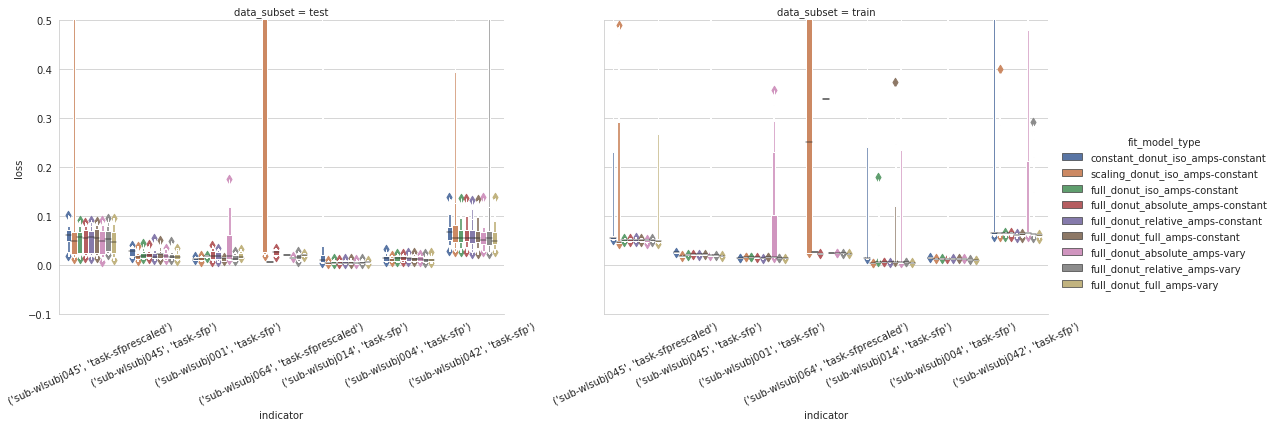

In [96]:
g = sns.catplot('indicator', 'loss', 'fit_model_type', data=grouped_loss_df, col='data_subset', legend='full', palette=sns.color_palette('deep', 9), hue_order=model_order, height=5, 
                aspect=1.5, kind='boxen',)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.set(ylim=(-.1,.5))

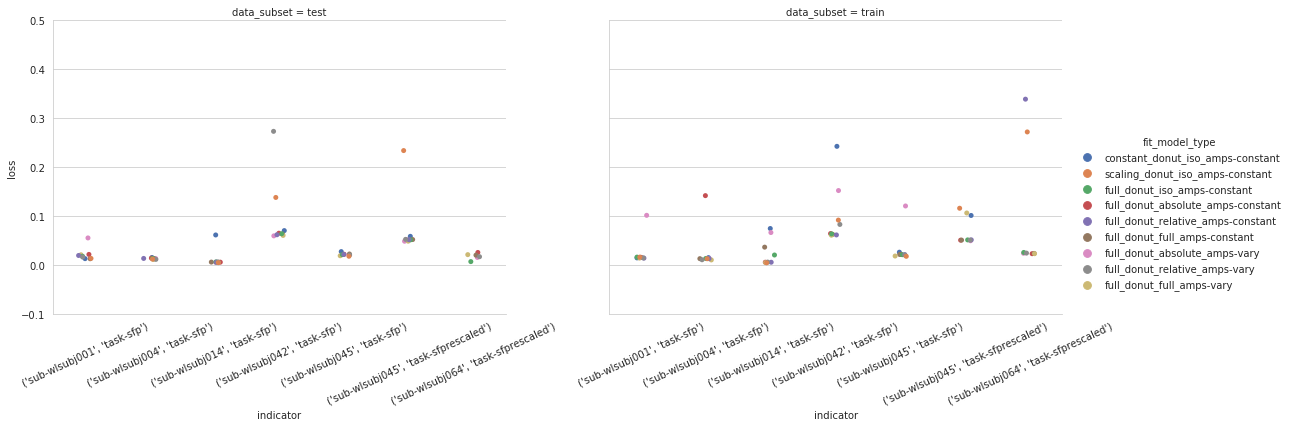

In [98]:
g = sns.catplot('indicator', 'loss', 'fit_model_type', data=tmp, col='data_subset', legend='full', palette=sns.color_palette('deep', 9), hue_order=model_order, height=5, 
                aspect=1.5, kind='strip',)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.set(ylim=(-.1,.5))

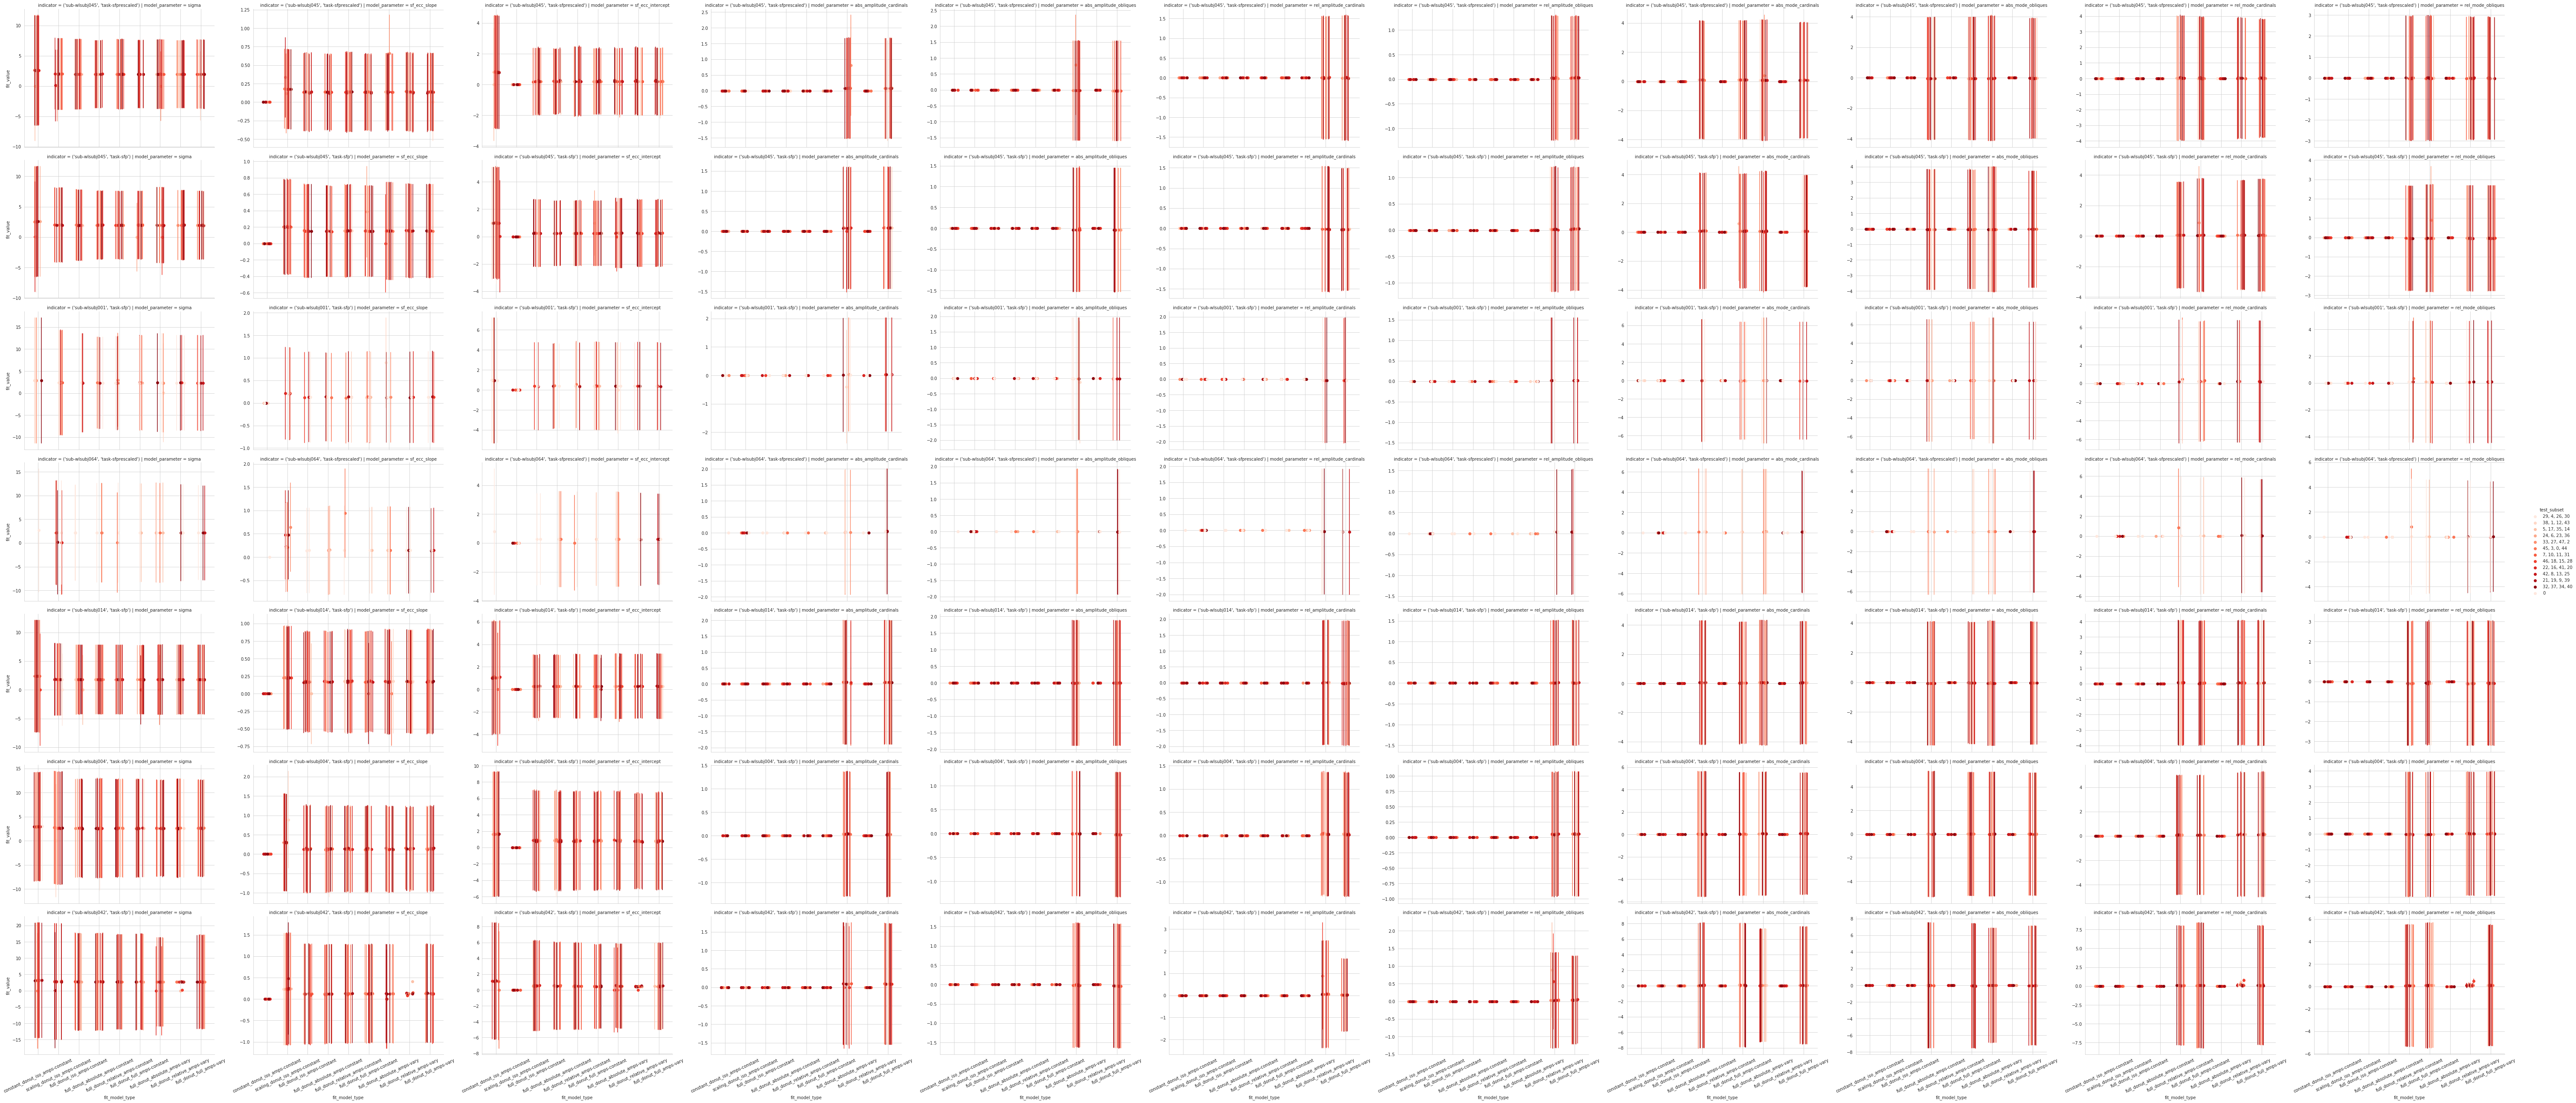

In [102]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models, col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), row='indicator', col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

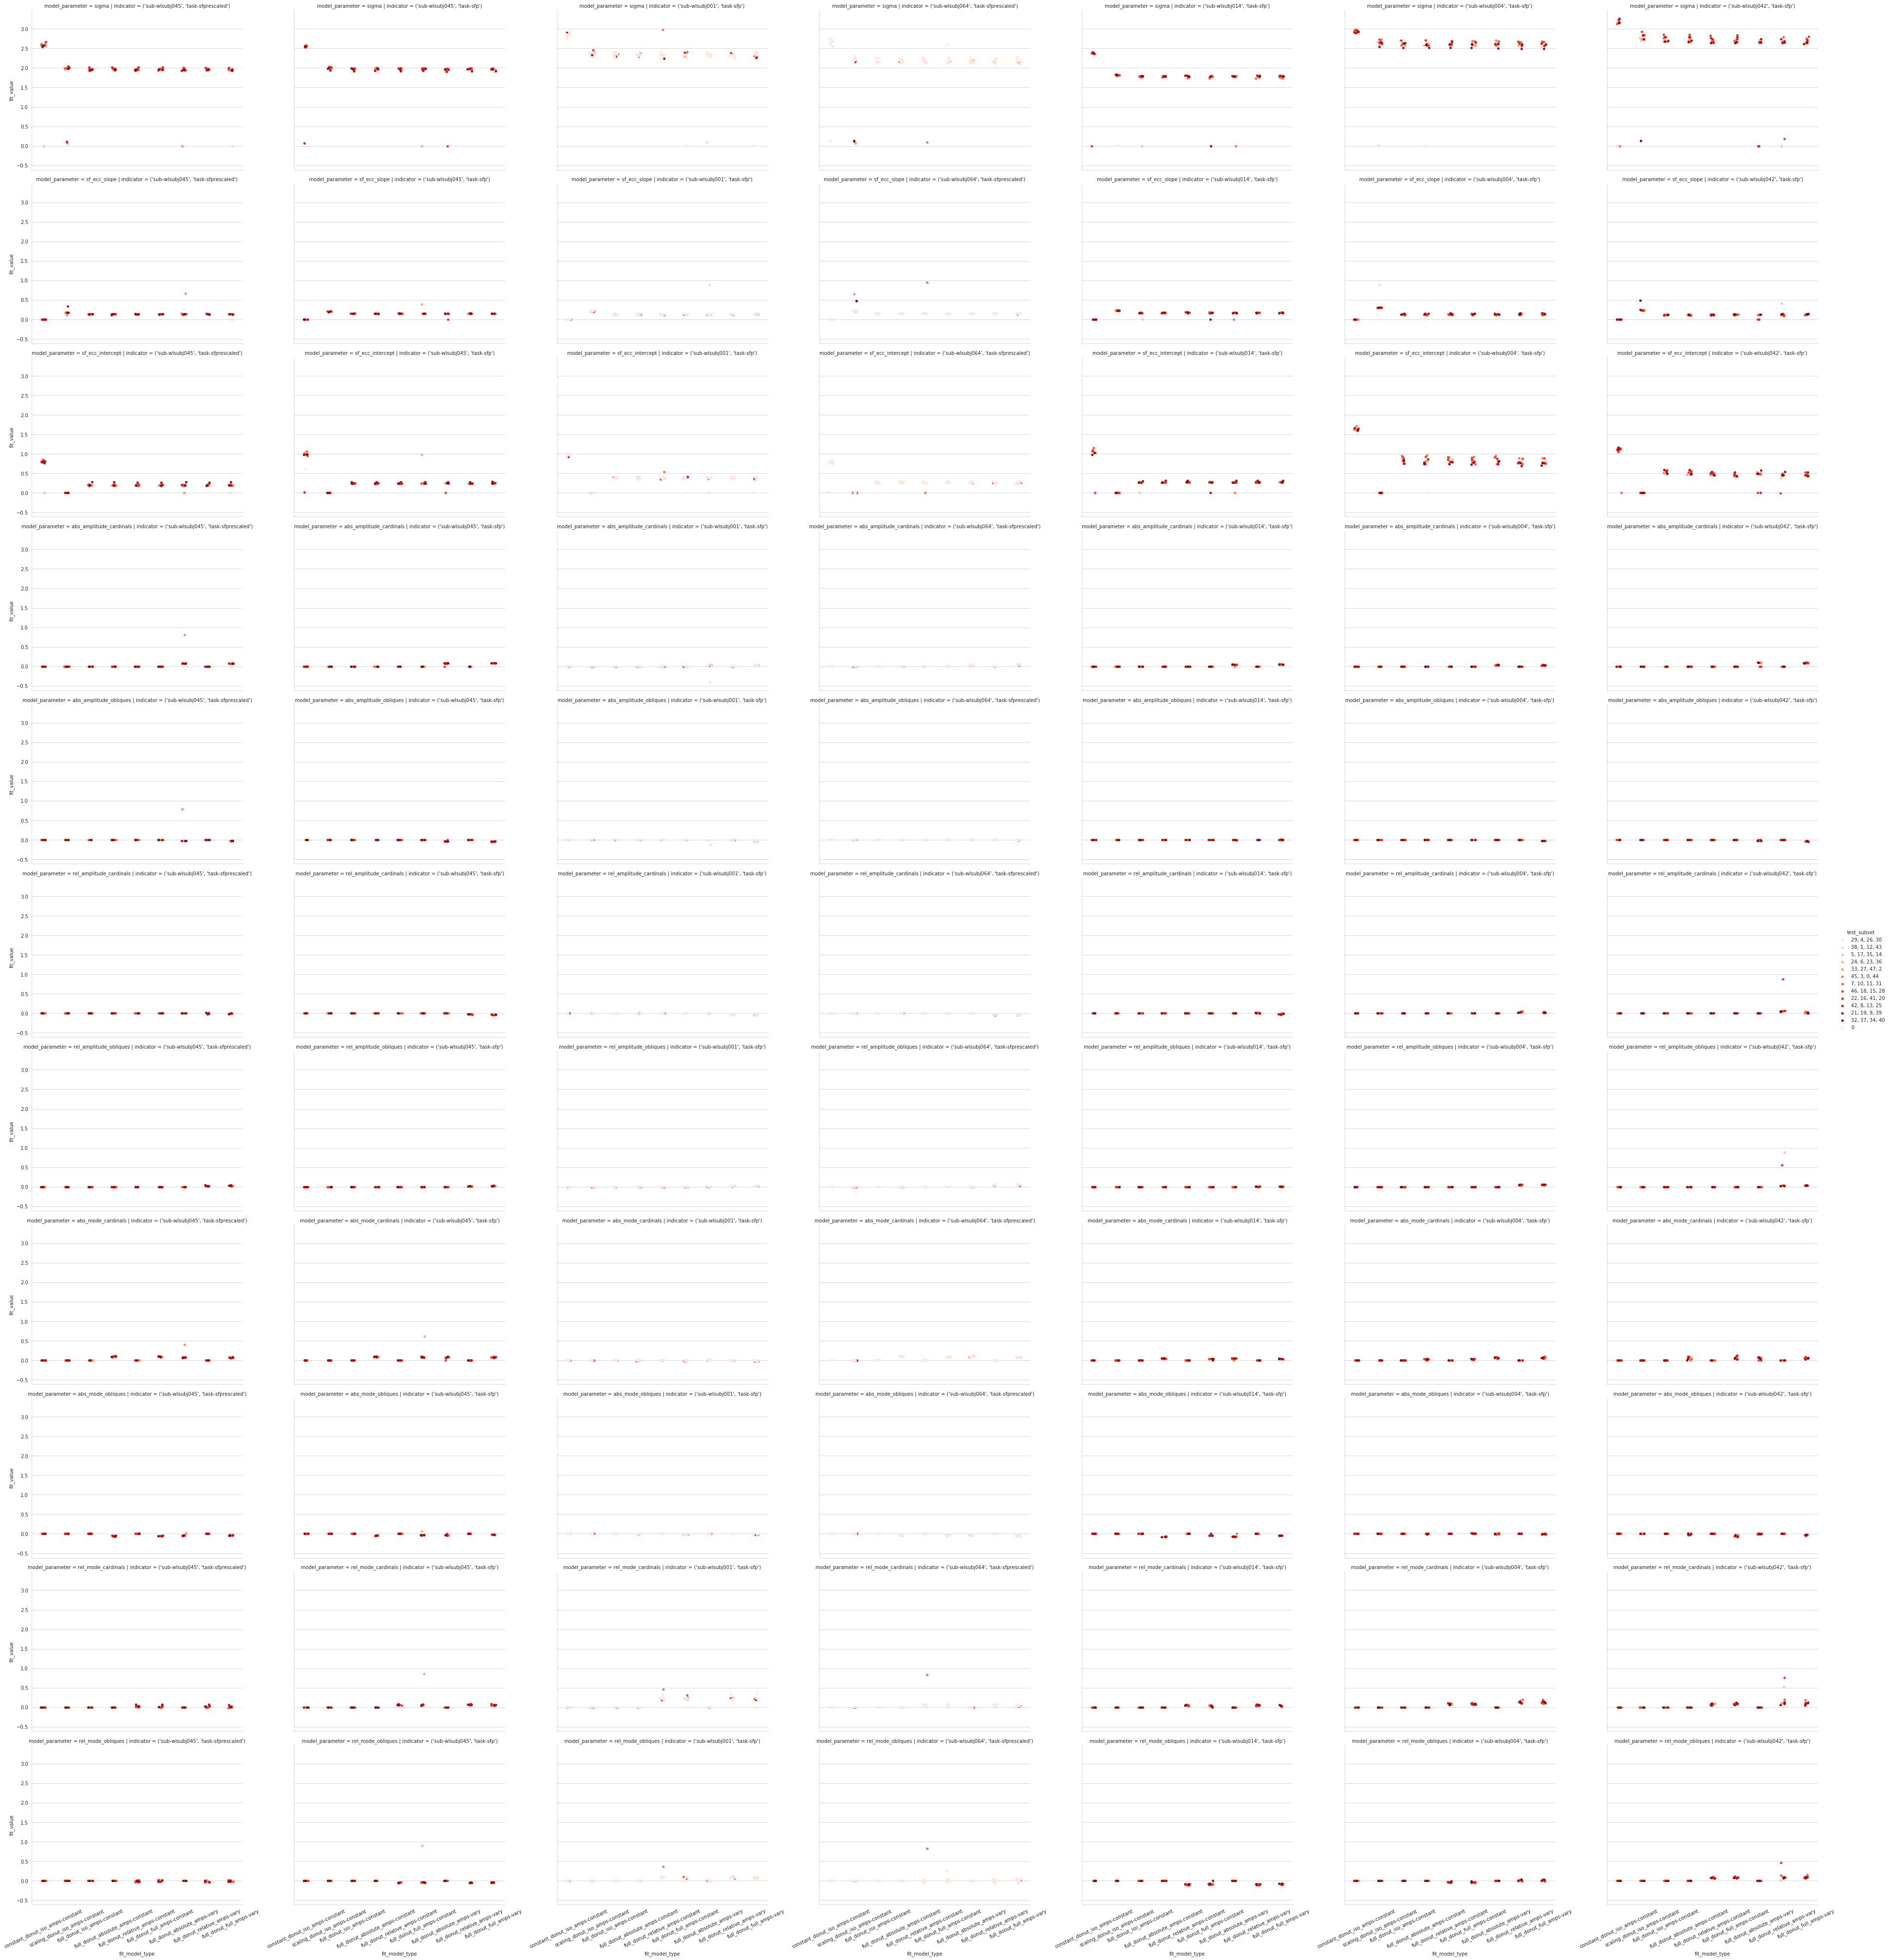

In [115]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models, row='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col='indicator', row_order=param_col_order, height=5, aspect=1.5, sharey=True)
g.map_dataframe(sns.stripplot, 'fit_model_type', 'fit_value', order=model_order, )
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

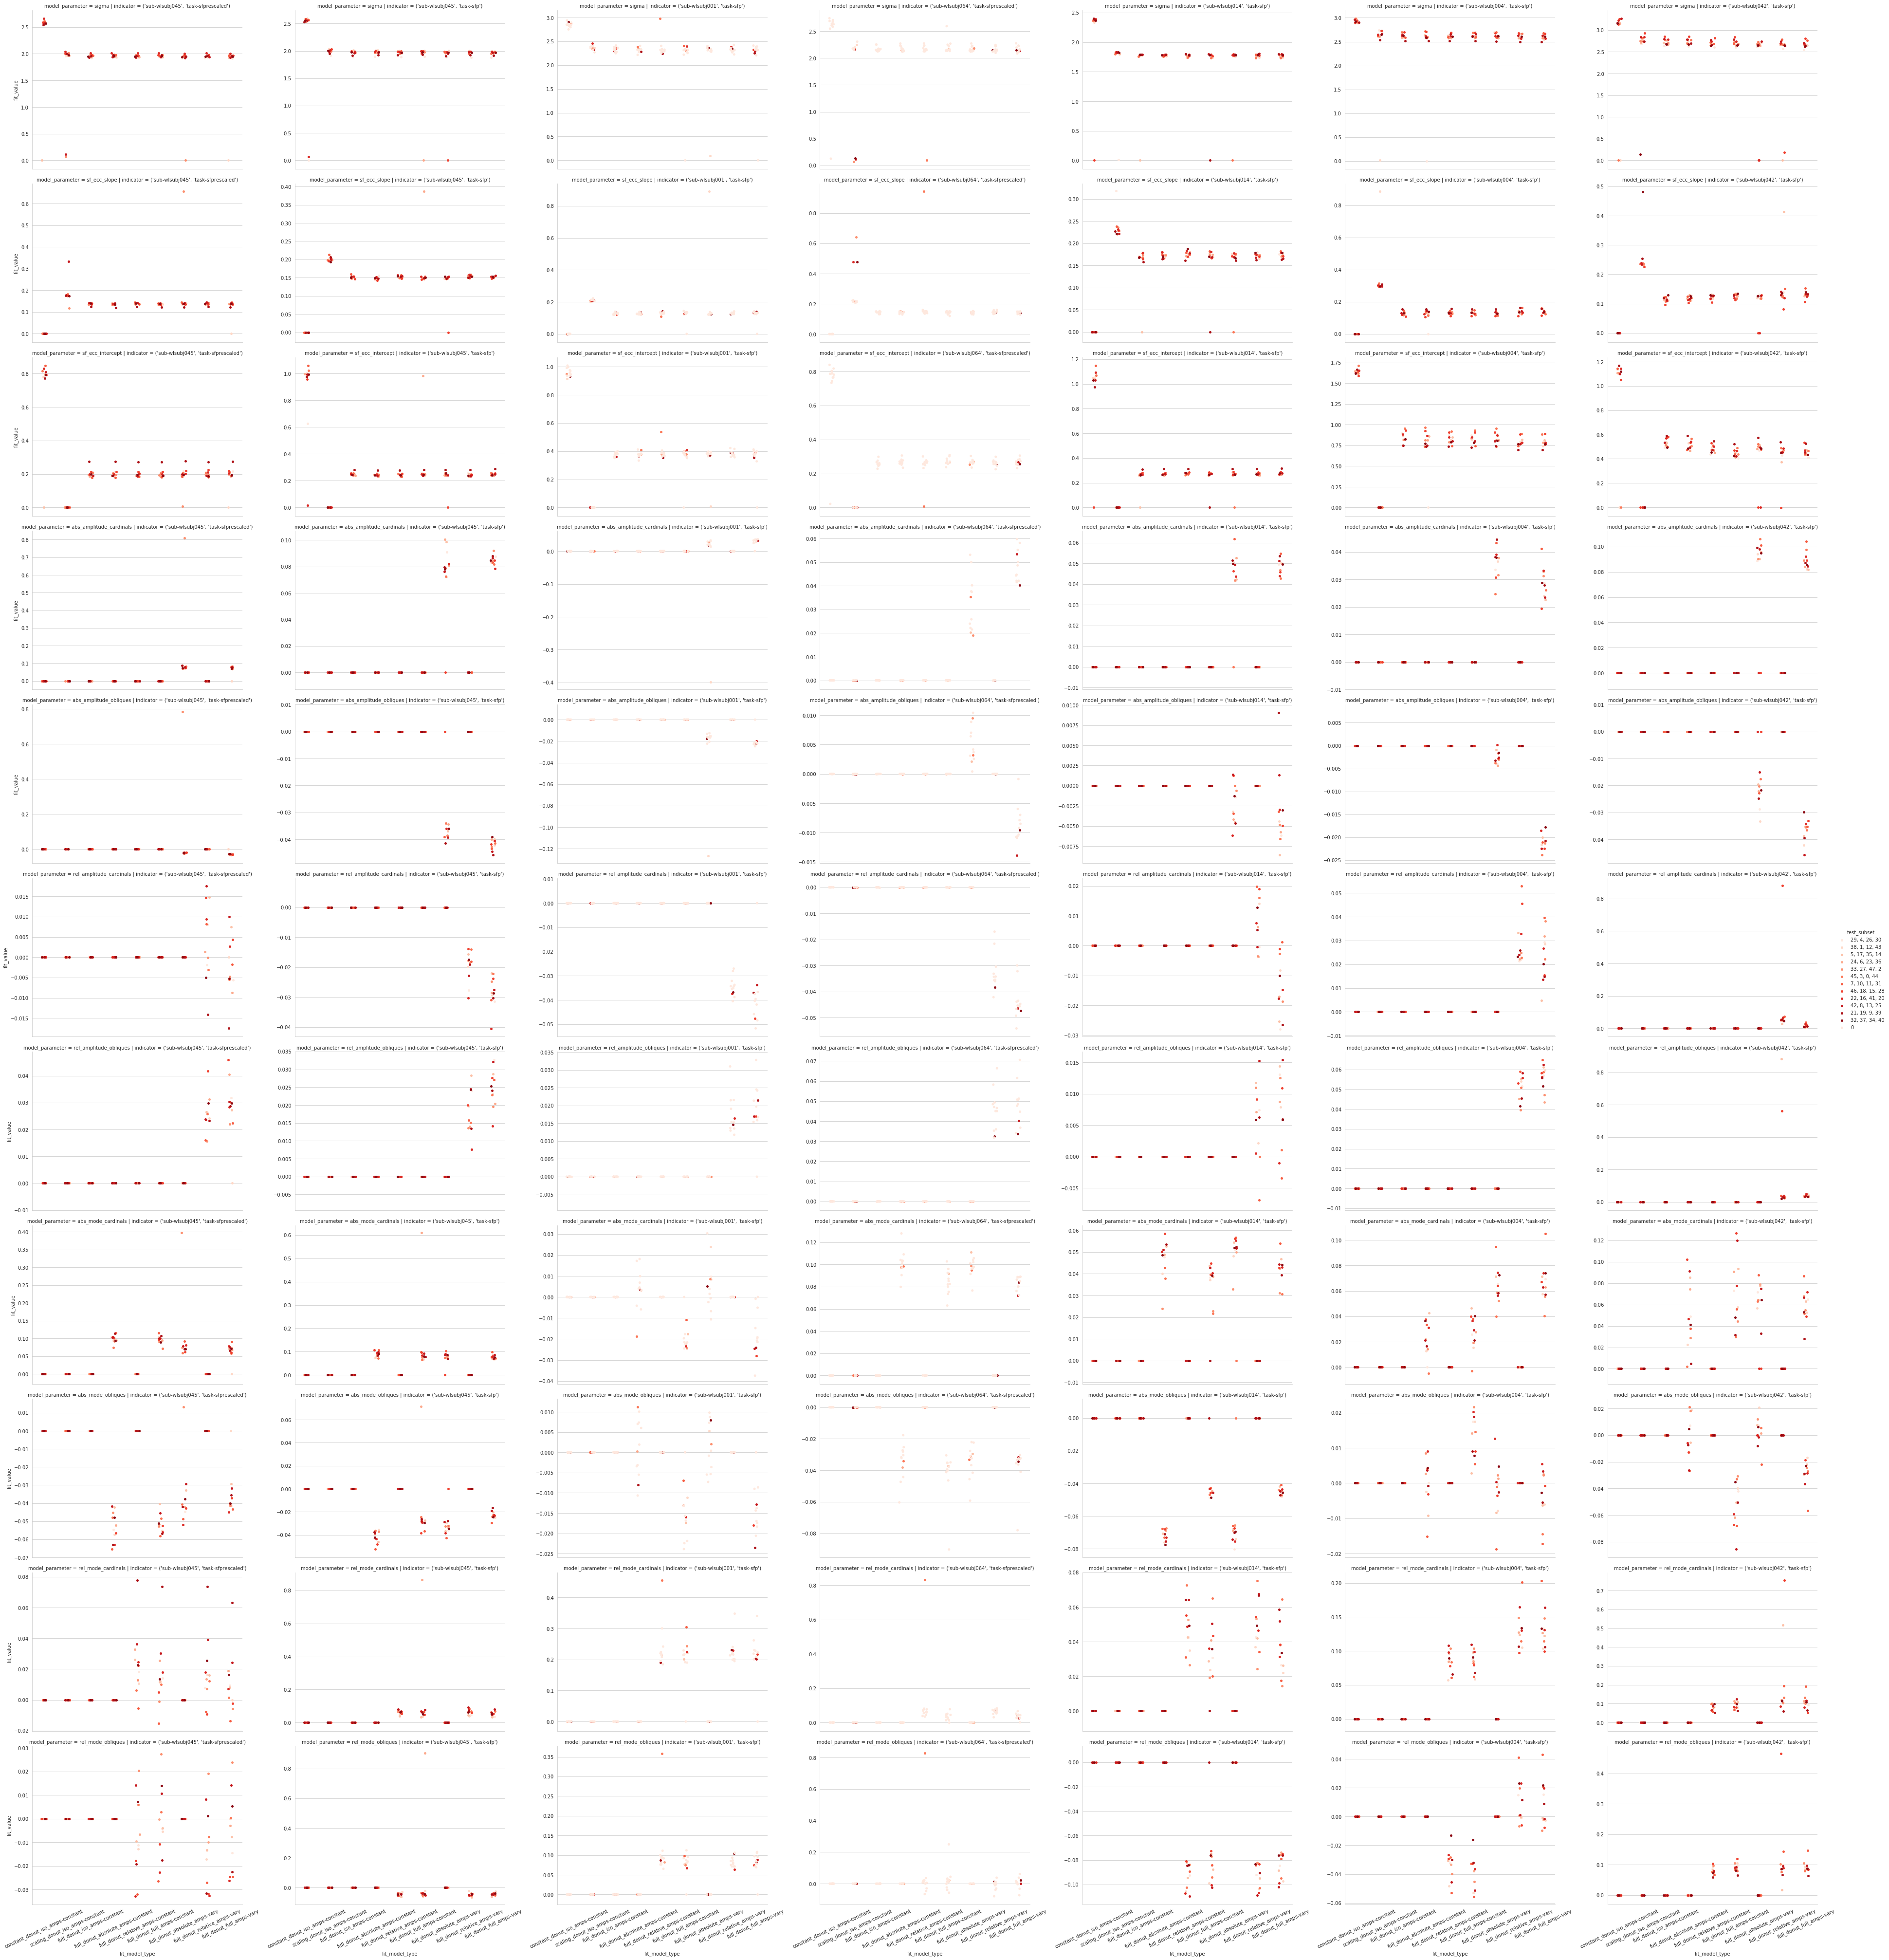

In [116]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models, row='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col='indicator', row_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sns.stripplot, 'fit_model_type', 'fit_value', order=model_order, )
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

In [127]:
models.indicator.values[0]

"('sub-wlsubj045', 'task-sfprescaled')"

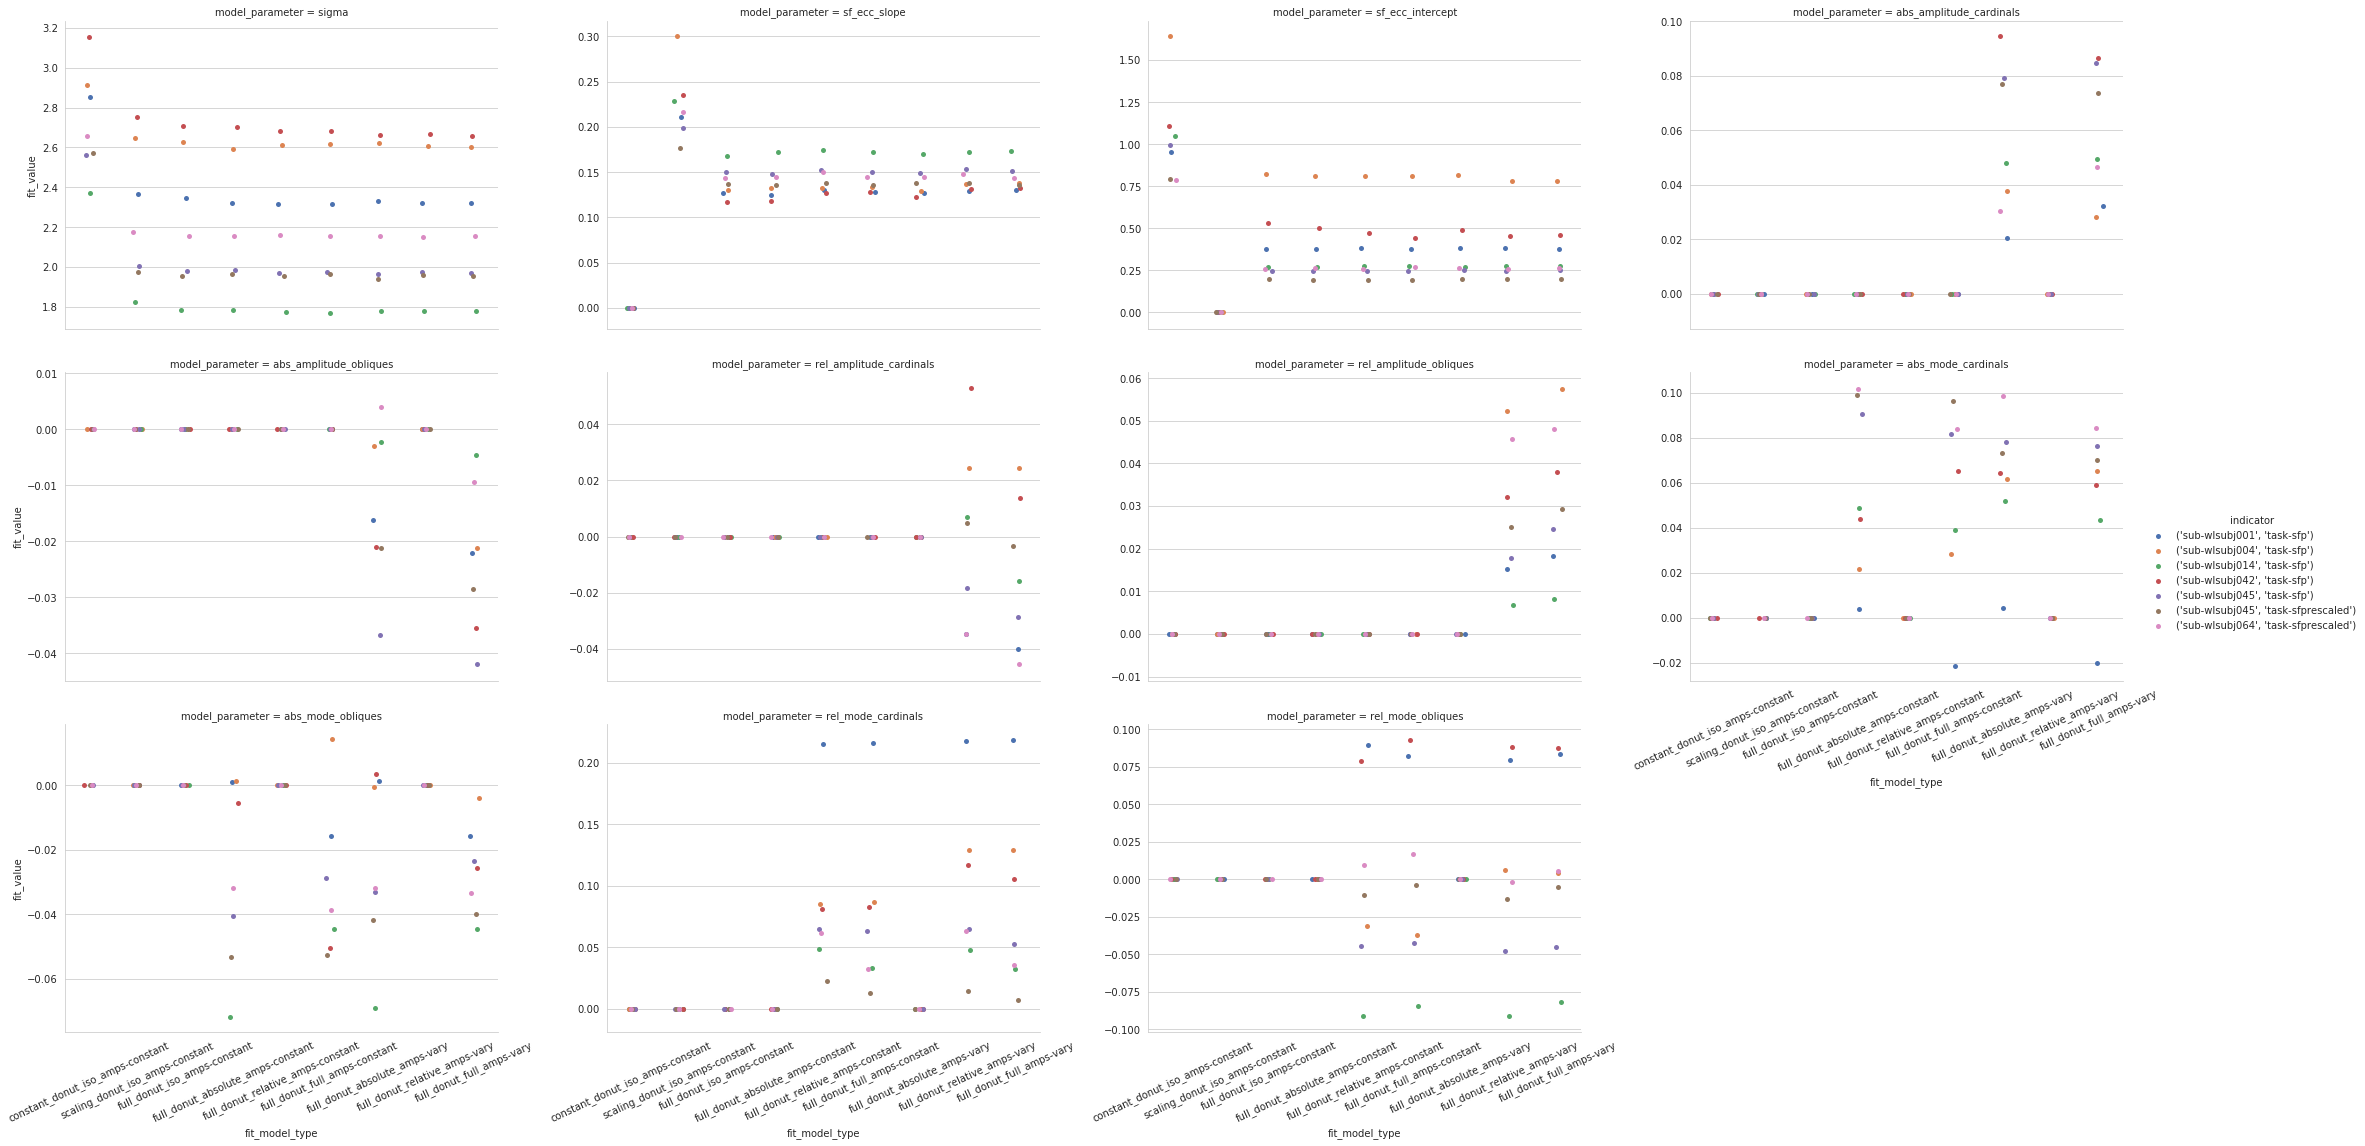

In [122]:
tmp = models.groupby(['model_parameter', 'indicator', 'fit_model_type']).fit_value.median().reset_index()

param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=tmp, col='model_parameter', hue='indicator',
                  palette=sns.color_palette('deep', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sns.stripplot, 'fit_model_type', 'fit_value', order=model_order, )
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

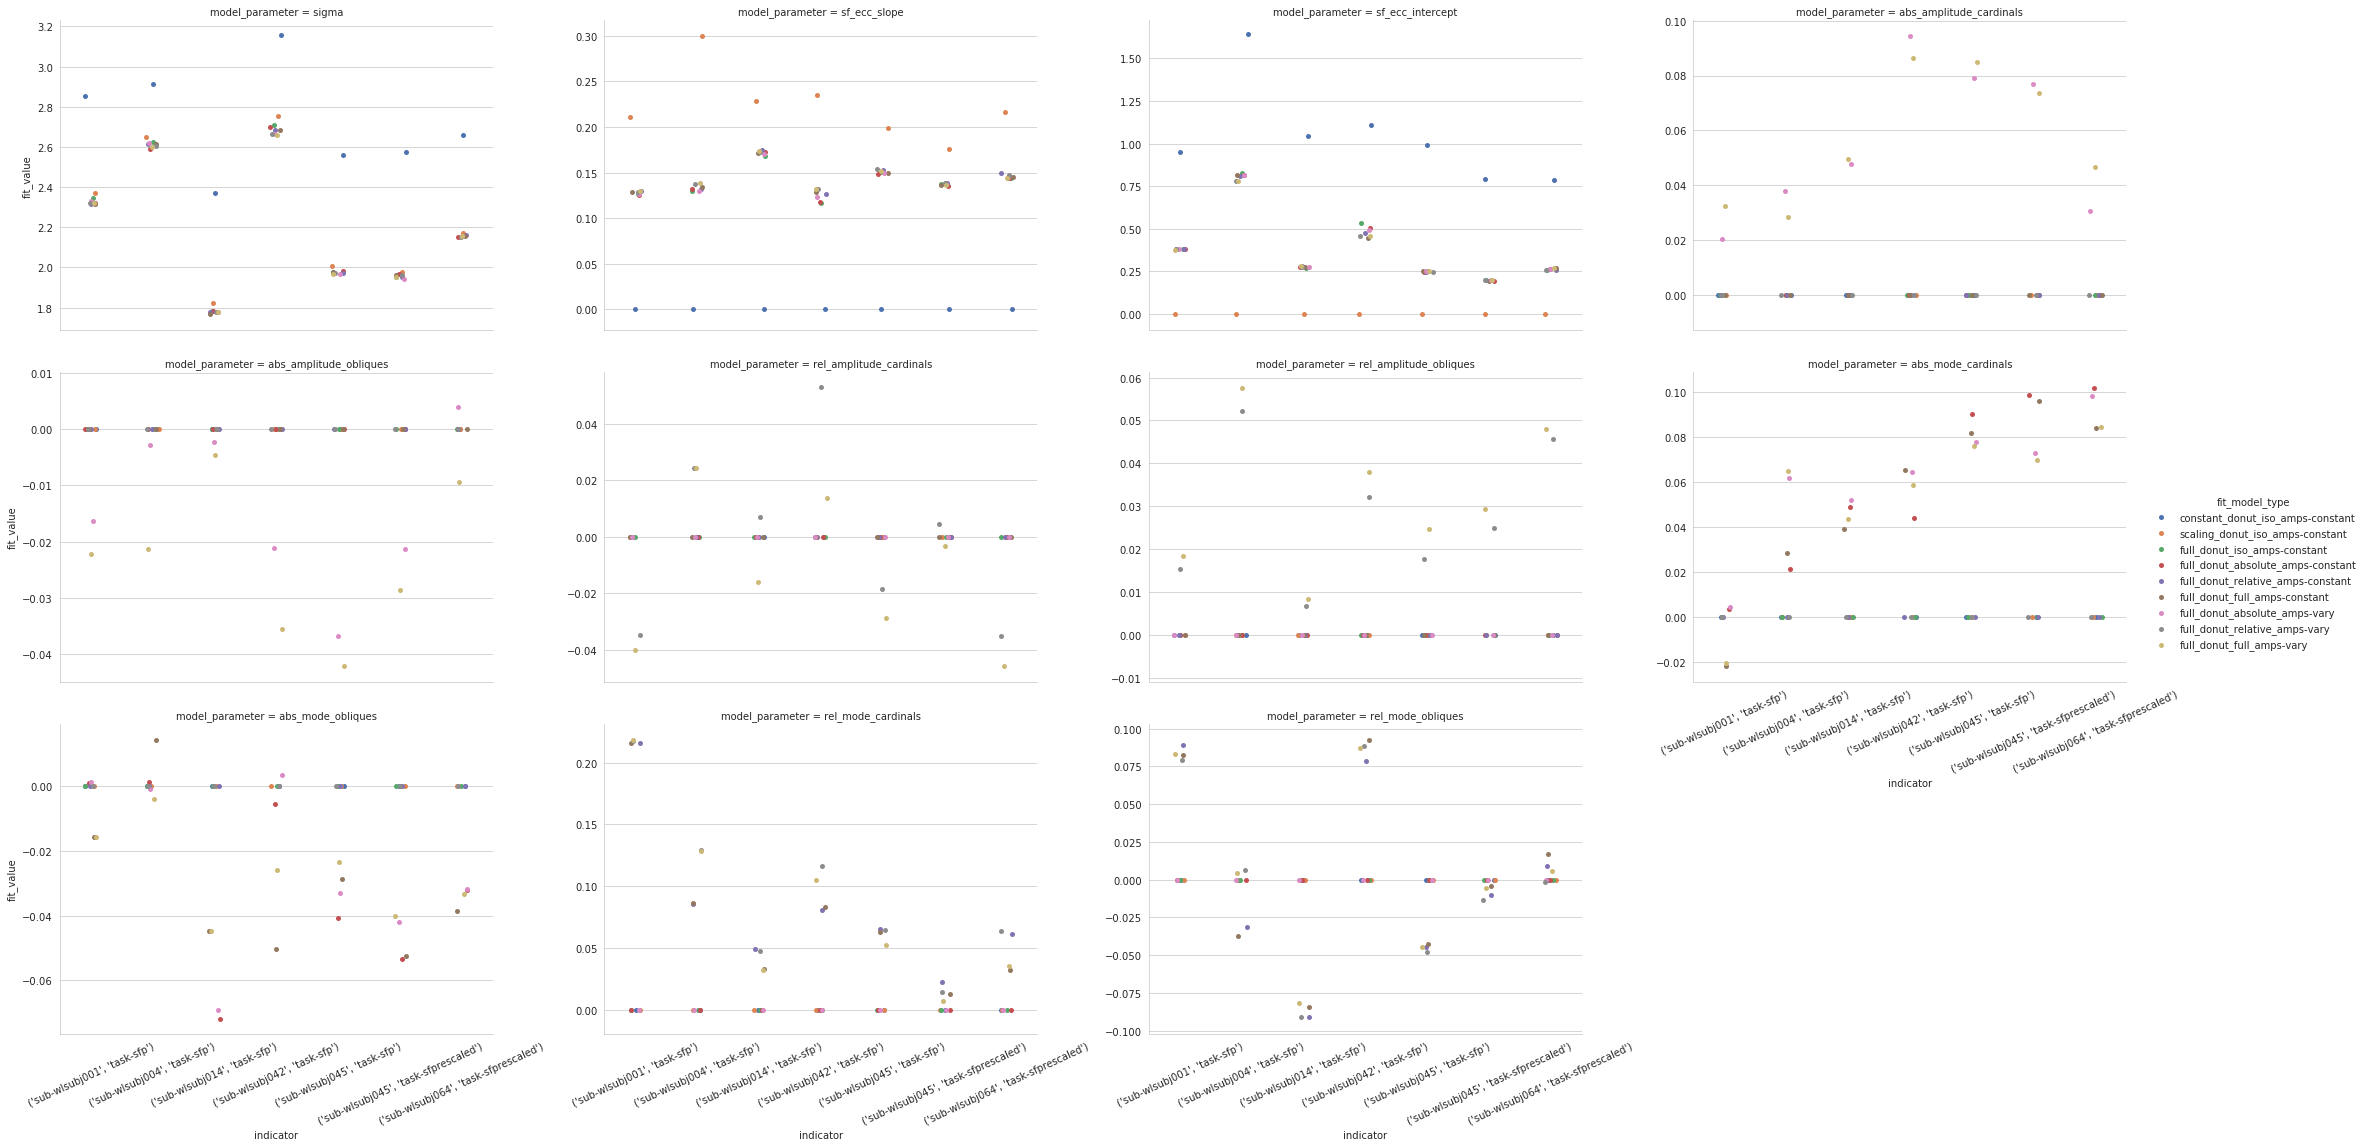

In [137]:
tmp = models.groupby(['model_parameter', 'indicator', 'fit_model_type']).fit_value.median().reset_index()

param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=tmp, col='model_parameter', hue='fit_model_type', hue_order=model_order,
                  palette=sns.color_palette('deep', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sns.stripplot, 'indicator', 'fit_value', )
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

## Other stuff

In [70]:
base_str = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g0_cNone_'
full_constant,_,_ = sfp.analyze_model.load_single_model(base_str+'full_full_constant', False)
full_vary,_,_ = sfp.analyze_model.load_single_model(base_str+'full_full_vary', False)
iso_constant,_,_ = sfp.analyze_model.load_single_model(base_str+'iso_full_constant', False)
features = sfp.analyze_model.create_feature_df([full_constant,full_vary,iso_constant], orientation_range=(0, np.pi), orientation_n_steps=48, retinotopic_angle_n_steps=50)
example_oris = np.linspace(0, np.pi, num=4, endpoint=False)

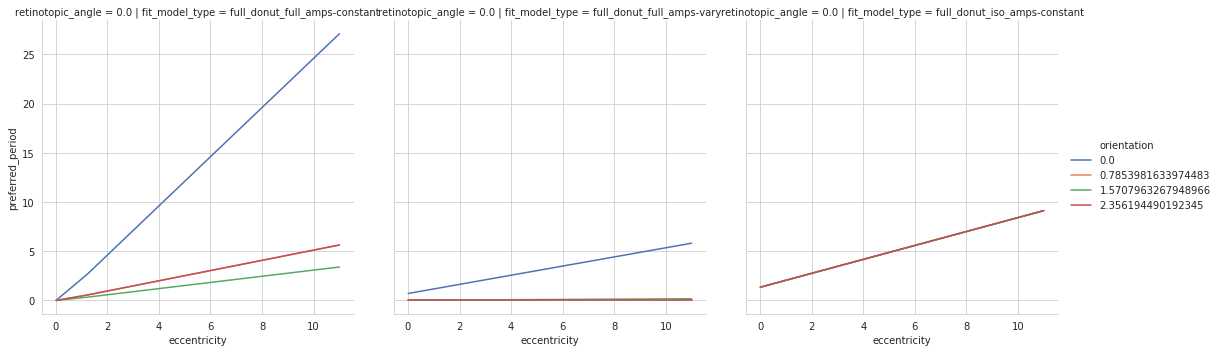

In [71]:
g = sns.relplot('eccentricity', 'preferred_period', 'orientation', data=features[(features.retinotopic_angle==0)&(features.orientation.isin(example_oris))],
                col='fit_model_type',
                row='retinotopic_angle', kind='line', palette=sns.color_palette('deep', 4))

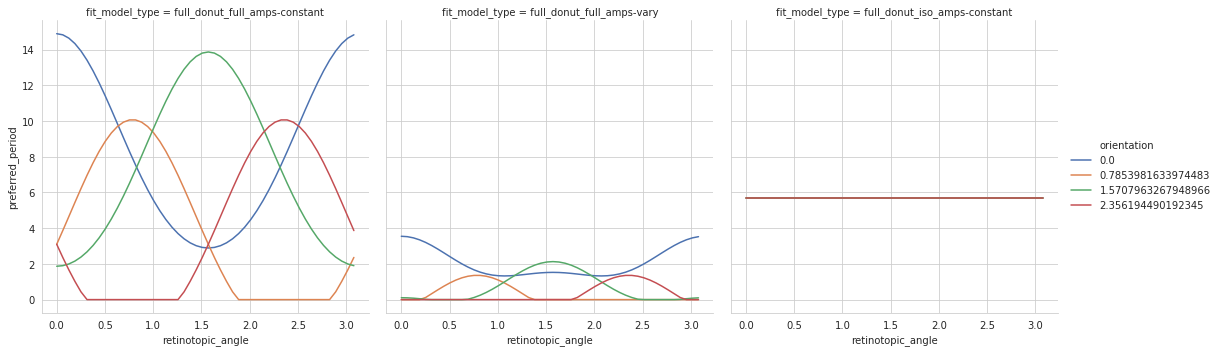

In [72]:
g = sns.relplot('retinotopic_angle', 'preferred_period', 'orientation',
                data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))],
                col='fit_model_type', kind='line', palette=sns.color_palette('deep', 4))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


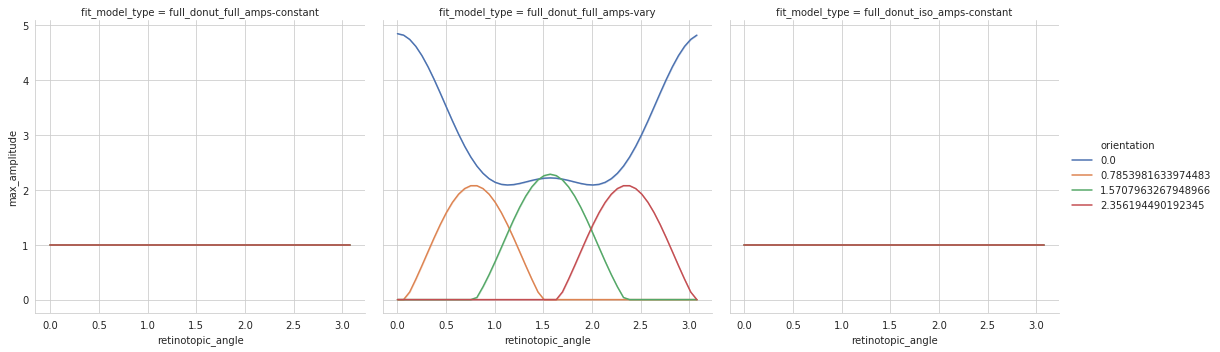

In [73]:
sns.relplot('retinotopic_angle', 'max_amplitude', 'orientation', data=features[(features.orientation.isin(example_oris))], col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 4))

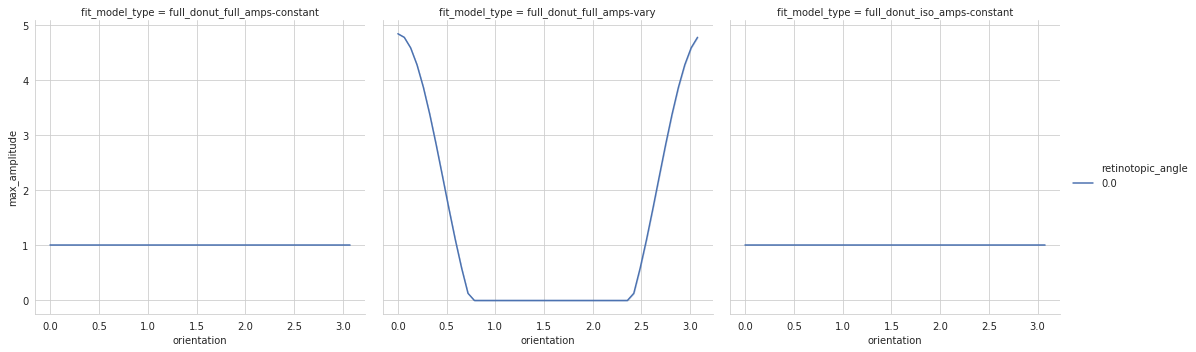

In [74]:
sns.relplot('orientation', 'max_amplitude', 'retinotopic_angle', data=features[features.retinotopic_angle==0],
            col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 1))

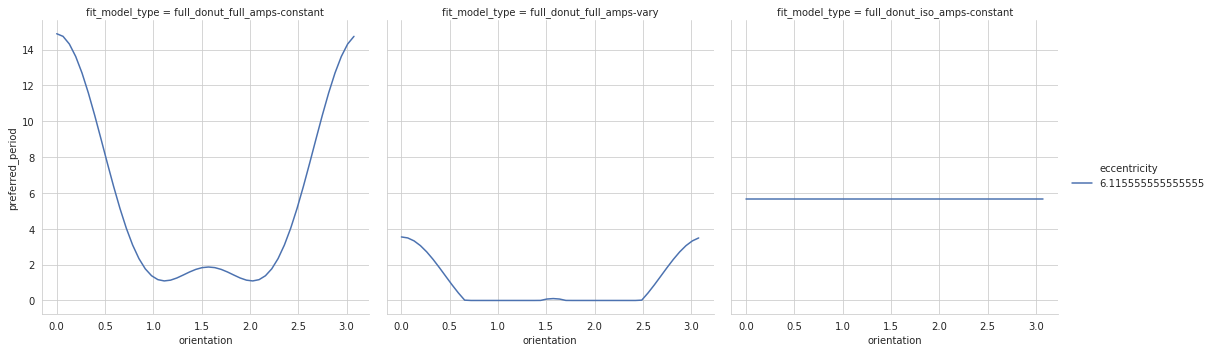

In [75]:
sns.relplot('orientation', 'preferred_period', 'eccentricity', data=features[(features.retinotopic_angle==0)&(features.eccentricity==features.eccentricity.unique()[5])],
            col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 1))

# Deprecated

The stuff below here doesn't run at the moment, but should be able to without too much of an issue

In [29]:
reduced_results = results_df.drop_duplicates(['fit_model_type', 'voxel', 'test_subset'])
reduced_results = reduced_results.groupby(['fit_model_type', 'voxel'])[['model_prediction_loss','model_prediction_correlation', 'eccen', 'angle', 'precision']].mean().reset_index()

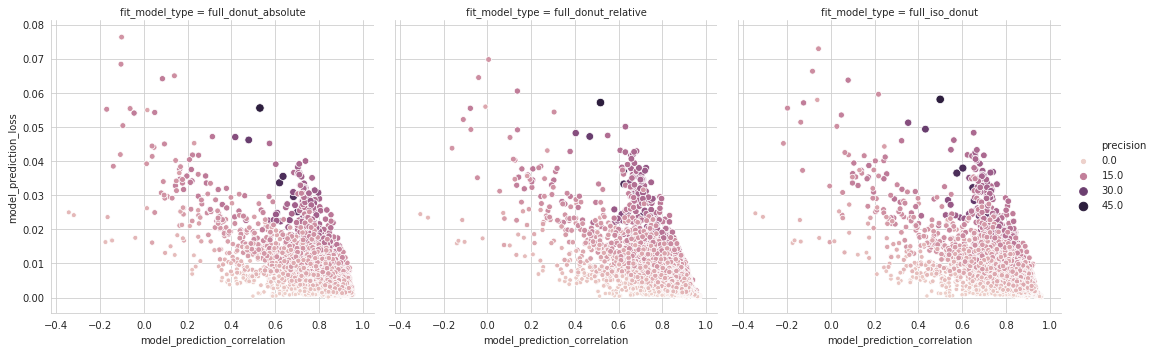

In [34]:
sns.relplot('model_prediction_correlation', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

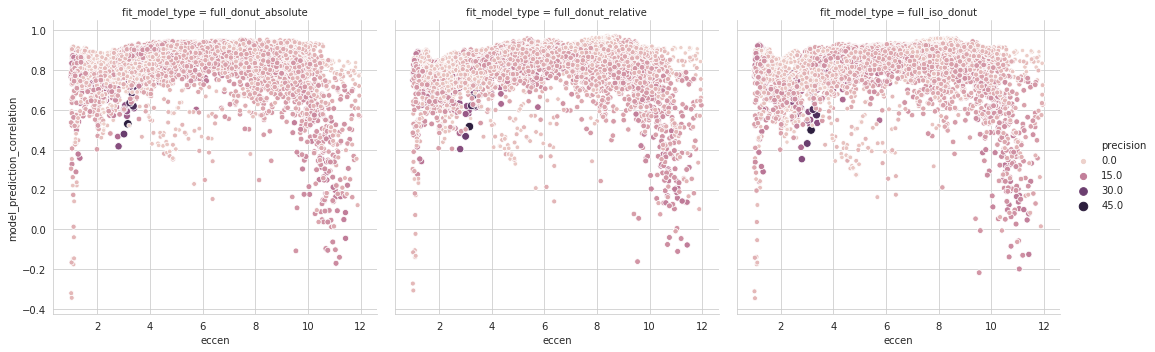

In [37]:
sns.relplot('eccen', 'model_prediction_correlation', 'precision', 'precision', data=reduced_results, col='fit_model_type')

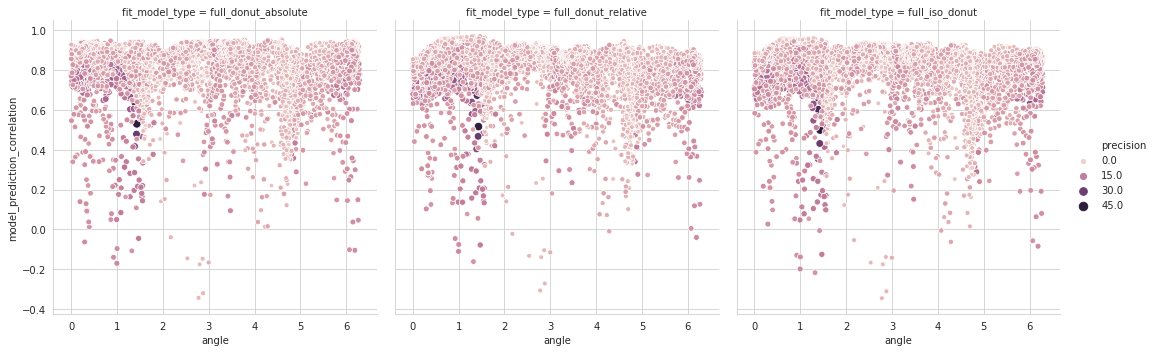

In [41]:
sns.relplot('angle', 'model_prediction_correlation', 'precision', 'precision', data=reduced_results, col='fit_model_type')

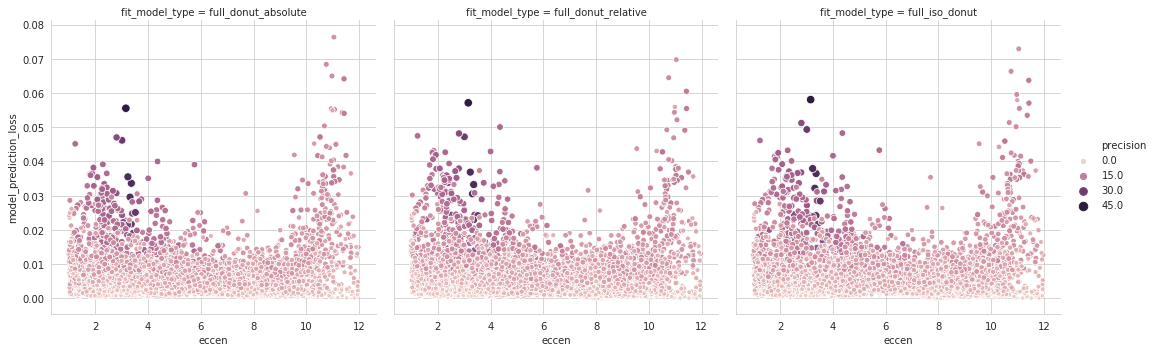

In [38]:
sns.relplot('eccen', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

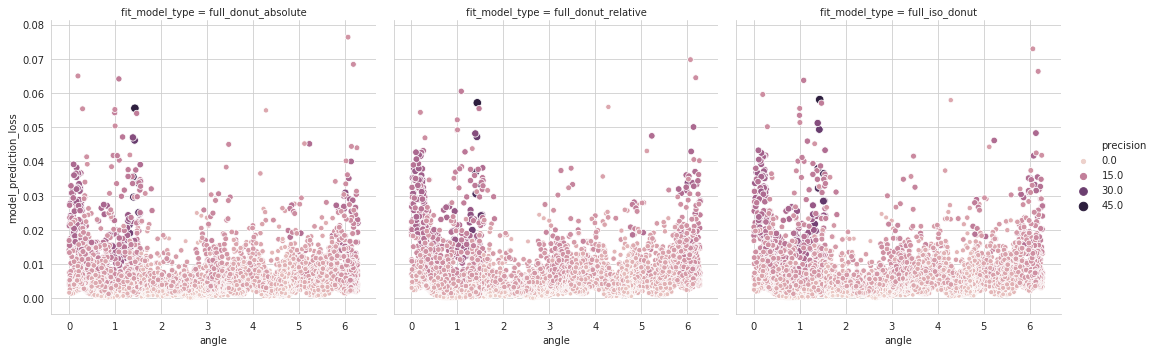

In [42]:
sns.relplot('angle', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

In [88]:
a = m.sf_ecc_slope.detach().numpy()
b = m.sf_ecc_intercept.detach().numpy()
s = m.sigma.detach().numpy()
eccen = np.linspace(0.01, 10, 120)
period = np.linspace(.01, 2, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = m.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

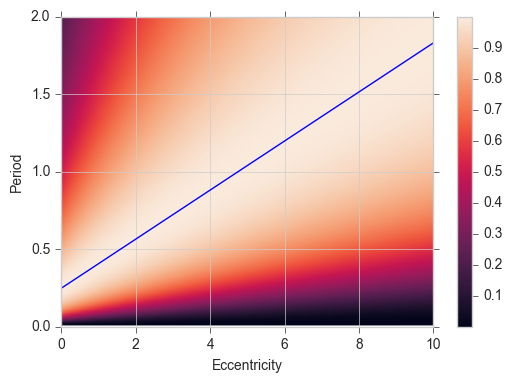

In [90]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
#plt.plot(eccen,(a/(1+s)*eccen+b), 'b--')
y = (1+s)*a*eccen+b
#plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()
plt.savefig('new_results.pdf')

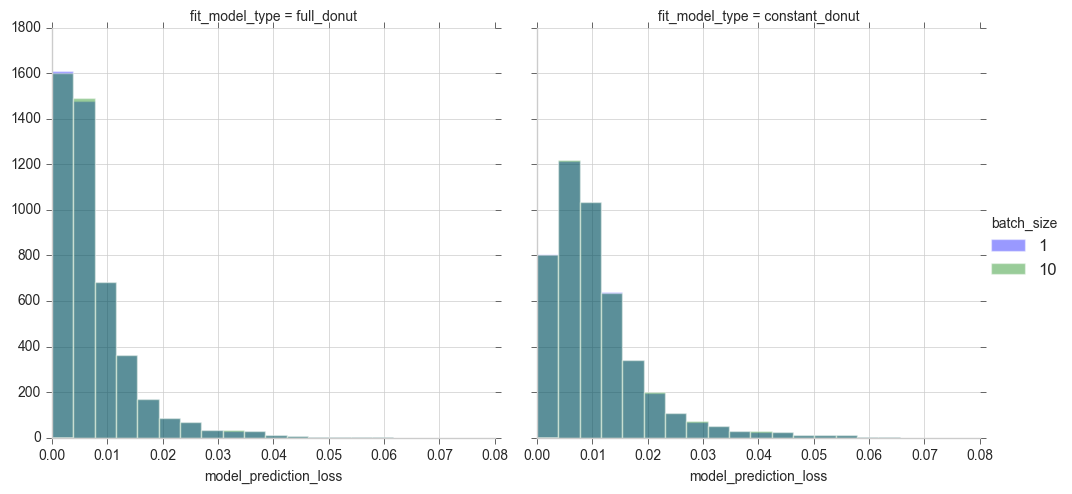

In [7]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type',hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_loss', kde=False, bins=np.linspace(0, results_df.model_prediction_loss.max(), 20))
g.add_legend()

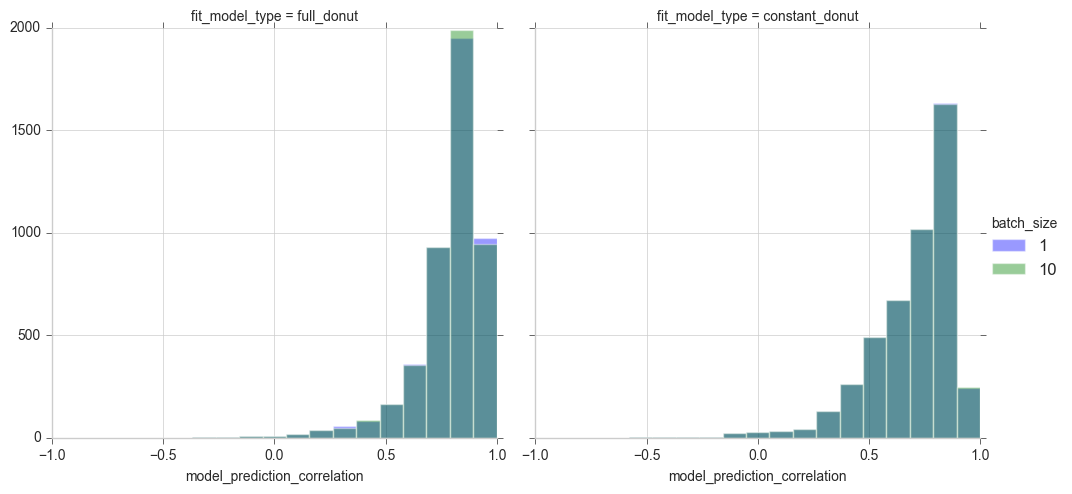

In [4]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type', hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_correlation', kde=False, bins=np.linspace(-1, 1, 20))
g.add_legend()

In [9]:
voxel_df = results_df[results_df.voxel == results_df.voxel.unique()[0]]

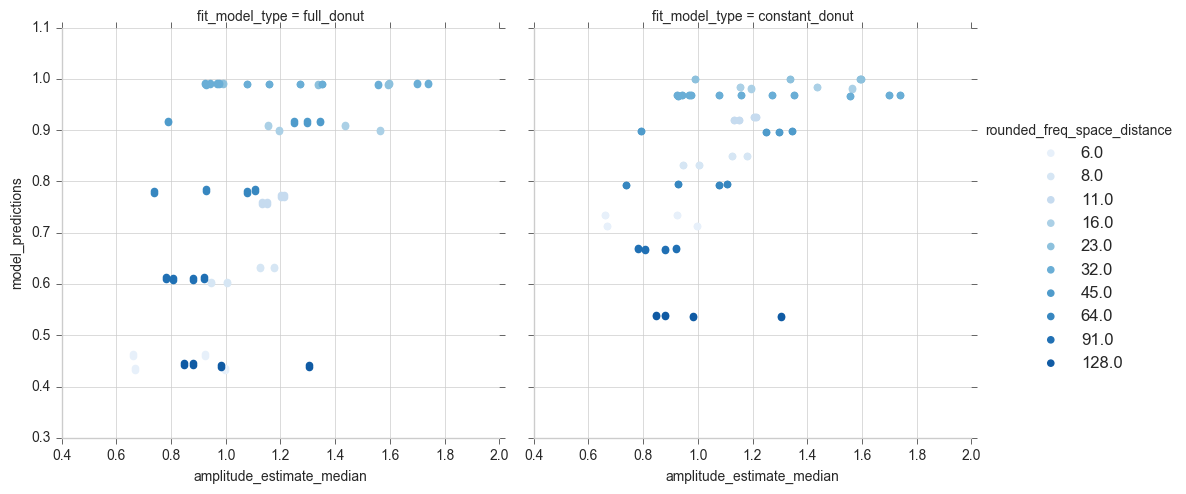

In [22]:
g = sns.FacetGrid(voxel_df, col='fit_model_type', hue='rounded_freq_space_distance',palette=sns.color_palette('Blues', 11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
g.add_legend()

In [39]:
best_voxels = results_df[(results_df.batch_size==10)&(results_df.fit_model_type=='full_donut')&(results_df.model_prediction_loss<.001)]
print(best_voxels.voxel.nunique())

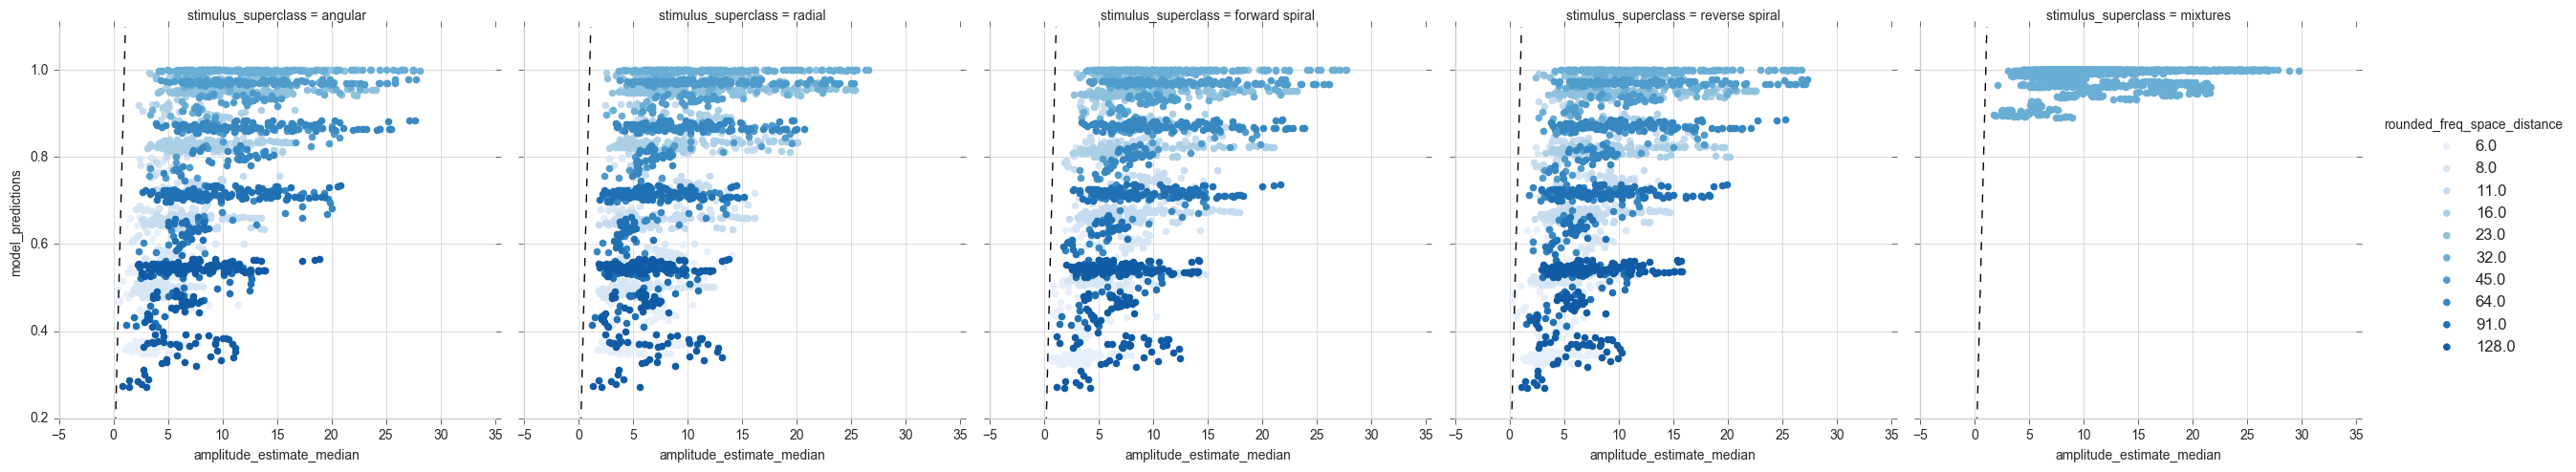

In [41]:
g = sns.FacetGrid(best_voxels, hue='rounded_freq_space_distance', col='stimulus_superclass', palette=sns.color_palette('Blues',11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
xlim = g.axes.flatten()[0].get_xlim()
ylim = g.axes.flatten()[0].get_ylim()
for ax in g.axes.flatten():
    ax.plot(xlim, xlim, 'k--')
g.set(xlim=xlim, ylim=ylim)
g.add_legend()